| <p align="center" style="font-size: 24px;"><strong>TABLE of CONTENT</strong></p> |
| --- |
| I/ [Collect & Store Data](#Collect-Store-Data) |
| II/ [Data preparation & transformation](#Data-preparation-transformation) |
| III/ [Customer Segmentation with Kmeans & RFM](#Customer-Segmentation-with-Kmeans-&-RFM) |
| IV/ [Final Result](#final-result) |
_____

## I/ <a id='Collect-Store-Data'></a>Collect & Store Data

In [1087]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from operator import attrgetter

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from prefixspan import PrefixSpan
import networkx as nx

from datetime import timedelta

In [1088]:
def ingest_as_df(data_name):
    path = '/Users/thailinhpham/Downloads/Python/hftf/data/' + data_name
    xls = pd.ExcelFile(path)
    return pd.read_excel(xls)

In [1089]:
data_bills = ingest_as_df('2. bills.xlsx')
data_users = ingest_as_df('3. users.xlsx')
data_products = ingest_as_df('4. products.xlsx') 
data_occasions = ingest_as_df('5. occasions.xlsx')
data_relationships = ingest_as_df('6. relationships.xlsx')
data_user_relationships = ingest_as_df('7. user_relationships.xlsx')
data_overview = [data_bills, data_users, data_products, data_occasions, data_relationships, data_user_relationships]
data_overview_dict = {
    'bills': data_bills,
    'users': data_users,
    'products': data_products,
    'occasions': data_occasions,
    'relationships': data_relationships,
    'user_relationships': data_user_relationships
}

In [1090]:
# riêng update databills
# Do quan data mới cung cấp không hề thay đổi về mặt thông số, chỉ thêm 1 cột chi phí vận chuyển và cột occasions
# nên chỉ cần bổ sung cột đấy vào data xử lý với excel là xong, không cần phải import data với dòng code dưới,
# giảm bớt thời gian chuẩn bị và biến đổi data
# data_bills = pd.read_csv('bills_new_122023_edit.csv')

In [1091]:
data_bills.head()

_id               customer_id  \
0  5c2ca5fd819a4edc2e65eb36  5a5ea602652fe8de52ecb5cf   
1  5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   
2  5c2c9162819a4e681965eb4f  5bf60ee0819a4e76518c6393   
3  5c2f2fad819a4e865065eb39  5a1cf33e652fe8c33d030d6f   
4  5c35b574819a4e314f76c332  597f4d5c652fe882468b590b   

                  master_id country_id  summary.grand_total   \
0  6066c157066c9a03055f2b10         MO               150000d   
1  6066c157066c9a03055f2b10         VN              1350000d   
2  6066c157066c9a03055f2b10         VN             500000vnd   
3  6066c157066c9a03055f2b10         US             800000vnd   
4  6066c157066c9a03055f2b10         IL             500000vnd   

   summary.discount.money  summary.commission   s_shipfee   \
0                     0.0                30000        -      
1                     NaN               270000        -      
2                     NaN               100000        -      
3                     NaN               160000        -      
4                     NaN               100000        -      

  to_user.location.province_id to_user.relationship_id  \
0     5016fd6b7f8b9ac842000000                     NaN   
1     5016fd6b7f8b9ac842000000                     NaN   
2     5016fd6b7f8b9ac842000000                     NaN   
3     5016fd6b7f8b9ac842000000                     NaN   
4     5016fd6b7f8b9ac842000000                     NaN   

        to_user.occasion_id       to_user.relative_id  \
0  62b445e29612dcb691028846  62bc900756bcb11219006029   
1                         0  62bc701a56bcb11219005312   
2  62374e382511770c643d9a5a  62bc730756bcb11219005467   
3  62b44615e7faf931dd003dd6  62bc99f556bcb112190063f8   
4                         0  62bca8b956bcb11219006a36   

               to_user.date       create_info.created  
0  2019-01-09T02:00:00.000Z  2019-01-02T11:52:29.714Z  
1  2019-01-05T00:00:00.000Z  2019-01-04T08:22:36.831Z  
2  2019-01-01T03:00:00.000Z  2019-01-02T10:24:34.952Z  
3  2019-01-07T02:00:00.000Z  2019-01-04T10:04:29.107Z  
4  2019-01-10T02:00:00.000Z  2019-01-09T08:48:52.720Z

## II/ <a id='Data-preparation-transformation'></a>Data preparation & transformation
##### (including exploration, data types, wrong/ missing values, standardization, outliers detection, feature extraction, etc...)

### 2.1. Rename columns

In [1092]:
def data_overview():
    data_overview_dict = {
        'bills': data_bills,
        'users': data_users,
        'products': data_products,
        'occasions': data_occasions,
        'relationships': data_relationships,
        'user_relationships': data_user_relationships
    }
    for data_name, data_frame in data_overview_dict.items():
        df_name = 'data_' + data_name
        print('data name is: ', data_name.upper())
        print('dataframe name is: ', df_name)
        print('with info: ', '\n', data_frame.info())
        print('='*60)

In [1093]:
# data_overview()

In [1094]:
# Remove head, tail space
data_bills.columns = data_bills.columns.str.strip()

# Rename the columns
data_bills.rename(columns={
    'summary.grand_total': 's_grand_total',
    'summary.discount.money': 's_discount_money',
    'summary.commission': 's_commission',
    'to_user.location.province_id': 'to_user_province_id',
    'to_user.relationship_id': 'to_user_relationship_id',
    'to_user.occasion_id': 'to_user_occasion_id',
    'to_user.relative_id': 'to_user_relative_id',
    'to_user.date': 'to_user_date',
    'create_info.created': 'create_info_created',
    'master_id': 'product_id'
}, inplace=True)

data_users.rename(columns={'_id': 'user_id', 'full_name': 'user_full_name'}, inplace=True)

data_products.rename(columns={'_id': 'product_id', 'name': 'product_name'}, inplace=True)

data_occasions.rename(columns={'_id': 'occasion_id', 'name': 'occasion_name'}, inplace=True)

data_relationships.rename(columns={'_id': 'relationship_id', 'name': 'relationship_name'}, inplace=True)

data_user_relationships.rename(columns={'_id': 'user_relationship_id', 'full_name': 'user_relationship_full_name'}, inplace=True)

### 2.2. Prepare data_bills

In [1095]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'product_id' has 150 NaN values.
Column 'country_id' has 308 NaN values.
Column 's_discount_money' has 798 NaN values.
Column 's_commission' has 438 NaN values.
Column 's_shipfee' has 1 NaN values.
Column 'to_user_province_id' has 28 NaN values.
Column 'to_user_relationship_id' has 5921 NaN values.
Column 'to_user_occasion_id' has 177 NaN values.
Column 'to_user_relative_id' has 741 NaN values.


Total   Percent
to_user_relationship_id   5921  0.896985
s_discount_money           798  0.120891
to_user_relative_id        741  0.112256
s_commission               438  0.066354
country_id                 308  0.046660

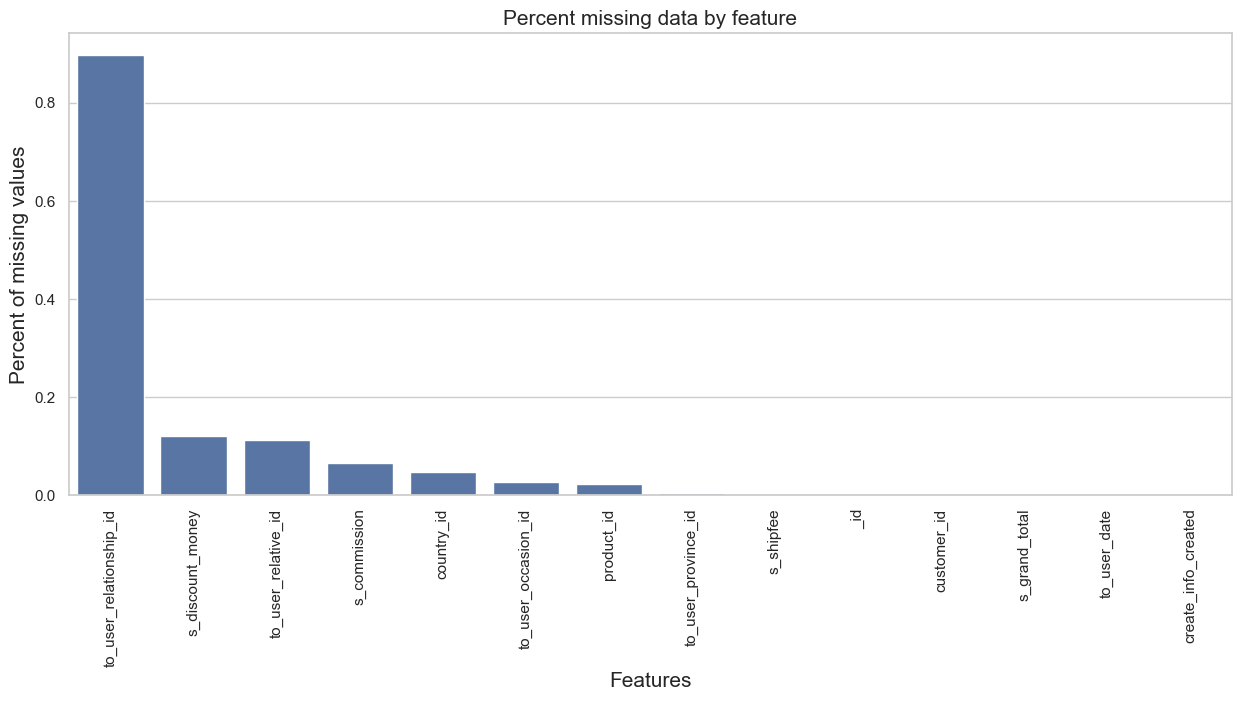

In [1096]:
total = data_bills.isnull().sum().sort_values(ascending=False)
percent = (data_bills.isnull().sum()/data_bills.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='vertical')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [1097]:
data_bills['country_id'].unique()

array(['MO', 'VN', 'US', 'IL', 'GB', 'FR', 'DE', 'HK', 'PL', 'ID', 'MY',
       'CA', 'MX', 'NL', 'SG', 'CH', 'AU', 'KR', 'TH', 'KH', 'RU', 'IT',
       'TW', 'SE', nan, 'LK', 'IN', 'PH', 'FI', 'JP', 'KZ', 'TR', 'DK',
       'EE', 'NO', 'EG', 'UA', 'RS', 'HU', 'BE', 'SK', 'CN', 'GU', 'NZ',
       'BR', 'CM', 'IE', 'IS', 'LU', 'BD'], dtype=object)

In [1098]:
data_bills_original = data_bills.copy()

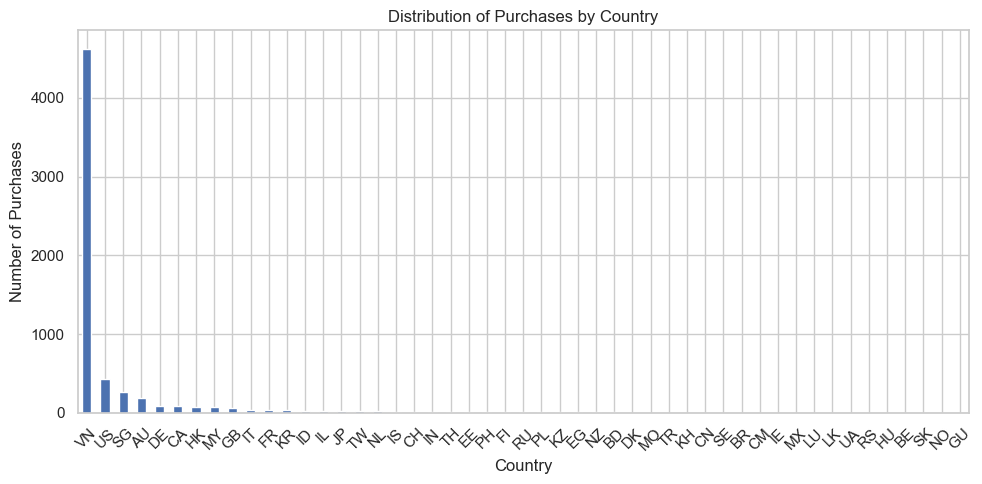

In [1099]:
country_counts = data_bills['country_id'].value_counts()

country_counts.plot(kind='bar', figsize=(10, 5))

plt.title('Distribution of Purchases by Country')
plt.xlabel('Country')
plt.ylabel('Number of Purchases')

plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

In [1100]:
# Lọc data_bills để chỉ giữ lại record thị trường VN
data_bills = data_bills[data_bills['country_id'] == 'VN'].copy()

In [1101]:
data_provinces = pd.read_csv("provinces.csv") # data được cung cấp sau khi btc bổ sung

In [1102]:
data_provinces.rename(columns={'_id': 'province_id', 'name': 'province_name'}, inplace=True)
data_provinces['province_id'] = data_provinces['province_id'].str.extract(r'ObjectId\((.*?)\)', expand=False)

In [1103]:
data_bills = data_bills.merge(data_provinces, how='left', left_on='to_user_province_id', right_on='province_id')

data_bills.rename(columns={'province_name': 'to_province'}, inplace=True)

data_bills.head(1)

_id               customer_id  \
0  5c2f17cc819a4eb96065eb26  5c2f17cc819a4eb96065eb25   

                 product_id country_id s_grand_total  s_discount_money  \
0  6066c157066c9a03055f2b10         VN      1350000d               NaN   

  s_commission s_shipfee       to_user_province_id to_user_relationship_id  \
0       270000      -     5016fd6b7f8b9ac842000000                     NaN   

  to_user_occasion_id       to_user_relative_id              to_user_date  \
0                   0  62bc701a56bcb11219005312  2019-01-05T00:00:00.000Z   

        create_info_created               province_id     to_province  
0  2019-01-04T08:22:36.831Z  5016fd6b7f8b9ac842000000  TP Hồ Chí Minh

In [1104]:
data_bills.drop('province_id', axis=1, inplace=True)

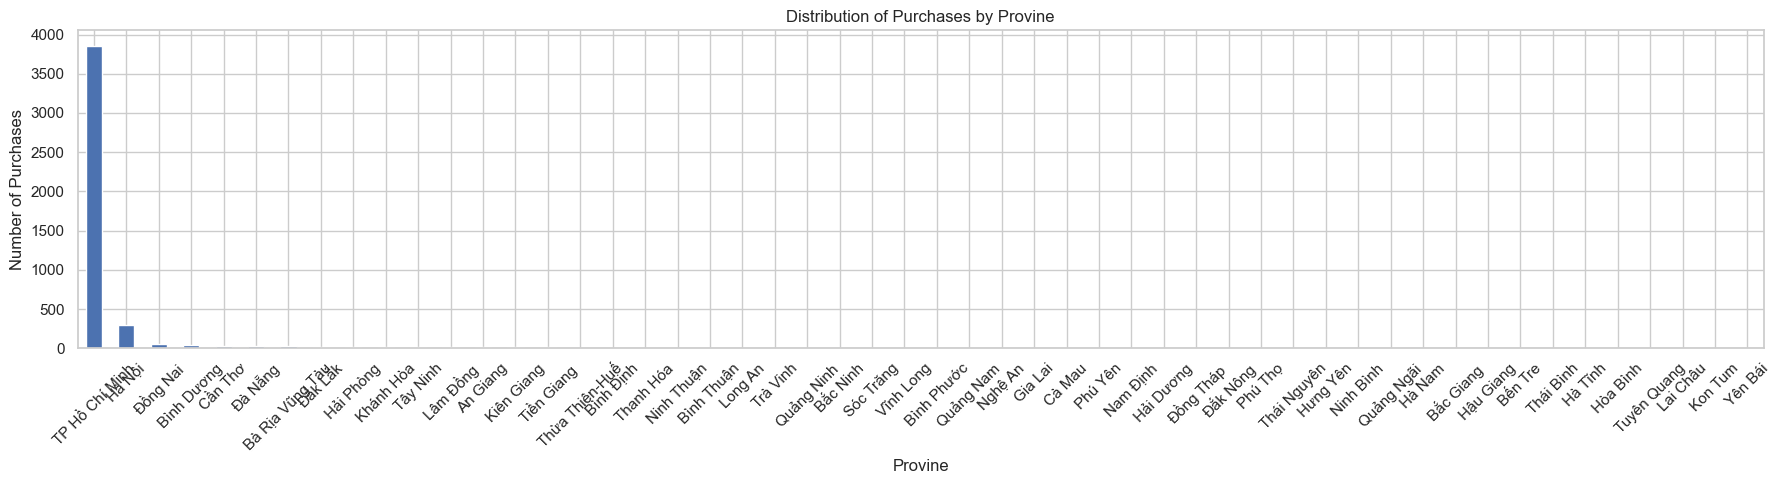

In [1105]:
Provine_counts = data_bills['to_province'].value_counts()

Provine_counts.plot(kind='bar', figsize=(18, 5))

plt.title('Distribution of Purchases by Provine')
plt.xlabel('Provine')
plt.ylabel('Number of Purchases')

plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

* In this case, I will not filter the destination is HCM city only, because the sender can be everywhere, but It could not deny a hypothesis that the sender are almost located in HCM city
* I focus on VN because the user located in Vietnam has been occupied the most, and it could be also good for customer behaviour analysis

In [1106]:
data_bills['s_grand_total'] = data_bills['s_grand_total'].str.extract('(\d+)').astype(float)
# print(data_bills['s_grand_total'])

In [1107]:
# Convert the 's_shipfee' column to float and replace non-numeric characters
data_bills['s_shipfee'] = data_bills['s_shipfee'].str.replace(',', '', regex=True)
data_bills['s_shipfee'] = data_bills['s_shipfee'].str.replace('[^\d.]', '', regex=True)
data_bills['s_shipfee'] = pd.to_numeric(data_bills['s_shipfee'], errors='coerce').fillna(0)

# Replace '-' with 0
data_bills['s_shipfee'] = data_bills['s_shipfee'].replace('-', 0)

# Replace NaN with 0
data_bills['s_shipfee'] = data_bills['s_shipfee'].fillna(0)

In [1108]:
# print(data_bills['s_shipfee'])

In [1109]:
def print_columns_with_nan(dataframe):
    for column in dataframe.columns:
        nan_count = dataframe[column].isna().sum()
        if nan_count > 0:
            print(f"Column '{column}' has {nan_count} NaN values.")
print_columns_with_nan(data_bills)

Column 'product_id' has 70 NaN values.
Column 's_grand_total' has 11 NaN values.
Column 's_discount_money' has 379 NaN values.
Column 's_commission' has 145 NaN values.
Column 'to_user_province_id' has 14 NaN values.
Column 'to_user_relationship_id' has 4142 NaN values.
Column 'to_user_occasion_id' has 128 NaN values.
Column 'to_user_relative_id' has 453 NaN values.
Column 'to_province' has 14 NaN values.


### Note: Ưu tiên xử lý các features quan trọng trước như s_commision, s_discount_money, s_grand_total
### Rồi sau đó lọc outlier rồi mới xử lý tiếp những NaN value

In [1110]:
# data_bills.info()

In [1111]:
def commission_conversion(row):
    if row['s_commission'] == ' -   ':
        # Calculate 20% of s_grand_total if s_commission is ' -   '
        return float(row['s_grand_total']) * 20 / 100
    else:
        return float(row['s_commission'])  # Otherwise, just convert to float

mask = data_bills['s_commission'] == ' -   '
data_bills.loc[mask, 's_commission'] = data_bills[mask].apply(commission_conversion, axis=1)

# Now let's ensure that the entire s_commission column is float
data_bills['s_commission'] = data_bills['s_commission'].astype(float)

In [1112]:
mask = data_bills['s_grand_total'].isna()
data_bills.loc[mask, 's_grand_total'] = data_bills.loc[mask, 's_commission'] * 100 / 20

print(data_bills['s_grand_total'].unique())

[1350000.  500000.  350000. ...  957744.  340200. 1318000.]


In [1113]:
data_bills['to_user_date'] = pd.to_datetime(data_bills['to_user_date'], errors='coerce', utc=True)
data_bills['create_info_created'] = pd.to_datetime(data_bills['create_info_created'], errors='coerce', utc=True)

In [1114]:
# data_bills.info()

In [1115]:
# data 2019 có 1 data point nên lọc luôn
start_date = pd.to_datetime('2020-01-01').tz_localize('UTC')
data_bills = data_bills[data_bills['create_info_created'] >= start_date]

In [1116]:
# remove 1 rows 
data_bills = data_bills[data_bills['s_discount_money'] >= 0]

In [1117]:
# def print_columns_with_nan(dataframe):
#     for column in dataframe.columns:
#         nan_count = dataframe[column].isna().sum()
#         if nan_count > 0:
#             print(f"Column '{column}' has {nan_count} NaN values.")
# print_columns_with_nan(data_bills)

In [1118]:
data_bills['product_id'].fillna('6066c157066c9a03055f2b10', inplace=True) # Hoa (dễ thấy ở các visualization sau)
data_bills['to_user_province_id'].fillna('5016fd6b7f8b9ac842000000', inplace=True) # hypothesis TPHCM
# data_bills['to_user_relationship_id'].fillna('62b43ee94a645a789f05dac2', inplace=True) # 'Một ai đó' 
# data_bills['to_user_relative_id'].fillna('62bc674256bcb11219004f32', inplace=True) # match ngược rela trả về 'Một ai đó' 
data_bills['to_province'].fillna('TP Hồ Chí Minh', inplace=True) # vì dữ liệu cho thấy đa số là tphcm
# data_bills['to_user_occasion_id'].fillna('62b44615e7faf931dd003dd6', inplace=True) # 'Dịp khác' 
fill_values = {
    'product_id': '6066c157066c9a03055f2b10',
    'to_user_province_id': '5016fd6b7f8b9ac842000000',
    # 'to_user_relationship_id': '62b43ee94a645a789f05dac2', 
    # 'to_user_relative_id': '62bc674256bcb11219004f32',
    'to_province': 'TP Hồ Chí Minh',
    # 'to_user_occasion_id': '62b44615e7faf931dd003dd6' 
}

data_bills.fillna(value=fill_values, inplace=True)

In [1119]:
# def print_columns_with_nan(dataframe):
#     for column in dataframe.columns:
#         nan_count = dataframe[column].isna().sum()
#         if nan_count > 0:
#             print(f"Column '{column}' has {nan_count} NaN values.")
# print_columns_with_nan(data_bills)

In [1120]:
# in case rerun a part of code
if 's_profit' not in data_bills:
    data_bills['s_profit'] = pd.Series(0, index=data_bills.index)
    
data_bills['s_profit'] = data_bills['s_profit'].astype(float)

# data_bills['s_discount_money'] = data_bills['s_discount_money'].fillna(0)

data_bills['s_grand_total'] = data_bills['s_grand_total'].astype(float)
data_bills['s_commission'] = data_bills['s_commission'].astype(float)

In [1121]:
# data_bills.info()

In [1122]:
data_bills.loc[data_bills['s_commission'] > 0, 's_profit'] = (
    data_bills['s_commission'] - data_bills['s_discount_money']
).astype(float)

data_bills.loc[data_bills['s_commission'] < 0, 's_profit'] = (
    0.2 * data_bills['s_grand_total'] - data_bills['s_discount_money'] - abs(data_bills['s_commission'])
).astype(float)

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/2892960337.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shipfee_group_counts.index, y=shipfee_group_counts.values, palette="viridis")


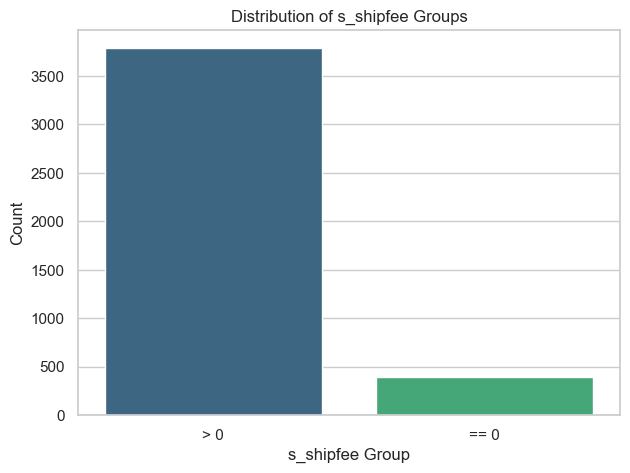

In [1123]:
# Classify each bill by whether s_shipfee is greater than 0 or equal to 0
data_bills['shipfee_group'] = data_bills['s_shipfee'].apply(lambda x: '> 0' if x > 0 else '== 0')

# Calculate the counts of the two groups
shipfee_group_counts = data_bills['shipfee_group'].value_counts()

# Using a bar chart to plot the counts
plt.figure(figsize=(7, 5))
sns.barplot(x=shipfee_group_counts.index, y=shipfee_group_counts.values, palette="viridis")
plt.title('Distribution of s_shipfee Groups')
plt.xlabel('s_shipfee Group')
plt.ylabel('Count')
plt.show()

In [1124]:
# data_bills.head(3)

#### Export to CSV for further analytics using other tools

In [1381]:
def to_csv(data_dict):
    for data_name, data_frame in data_dict.items():
        file_name = data_name + '.csv'
        data_frame.to_csv(file_name)
        print('Export to CSV. Done! File ', file_name, 'is ready to use')


to_csv(data_overview_dict)

Export to CSV. Done! File  bills.csv is ready to use
Export to CSV. Done! File  users.csv is ready to use
Export to CSV. Done! File  products.csv is ready to use
Export to CSV. Done! File  occasions.csv is ready to use
Export to CSV. Done! File  relationships.csv is ready to use
Export to CSV. Done! File  user_relationships.csv is ready to use


## III/ <a id='Customer-Segmentation-with-Kmeans-&-RFM'></a>Customer Segmentation with Kmeans & RFM

Notes: Sau khi thử nghiệm nhiều thuật toán phân loại khác nhau, nhóm đề xuất sử dụng Kmeans & RFM với 5 clusters

In [1382]:
data_bills_deep_analytics = data_bills.copy()
data_1 = data_bills_deep_analytics.copy()
# data_1.info()

In [1383]:
from datetime import timedelta

# Assuming data_1 is your DataFrame with the 'to_user_date' and 's_grand_total' columns correctly formatted
latest_date = data_1['to_user_date'].max() + timedelta(days=1)

rfm = data_1.groupby('customer_id').agg({
    'to_user_date': lambda x: (latest_date - x.max()).days,  # Recency
    'customer_id': 'size',  # Frequency
    's_grand_total': 'sum',  # Total spent (used for calculating AOV)
    's_discount_money': 'sum'
}).rename(columns={'to_user_date': 'Recency', 'customer_id': 'Frequency'})

# Calculating AOV
# rfm['AOV'] = (rfm['s_grand_total'] - rfm['s_discount_money'])/ rfm['Frequency']

# rfm['AOV'] = abs(rfm['s_grand_total'] - rfm['s_discount_money']) / rfm['Frequency']


rfm['AOV'] = np.where(rfm['s_grand_total'] > rfm['s_discount_money'],
                      (rfm['s_grand_total'] - rfm['s_discount_money']) / rfm['Frequency'],
                      rfm['s_grand_total'] / rfm['Frequency'])


# Drop the total spent column if you only need the AOV
rfm.drop(columns=['s_grand_total'], inplace=True)

# RFM dataframe now has Recency, Frequency, and AOV for each customer
rfm = rfm.rename(columns={'AOV': 'Monetary'})

# rfm

#### buộc phải remove outlier nếu không kết quả Segmentation sẽ ảnh hưởng nghiêm trọng (đã thử nghiệm)

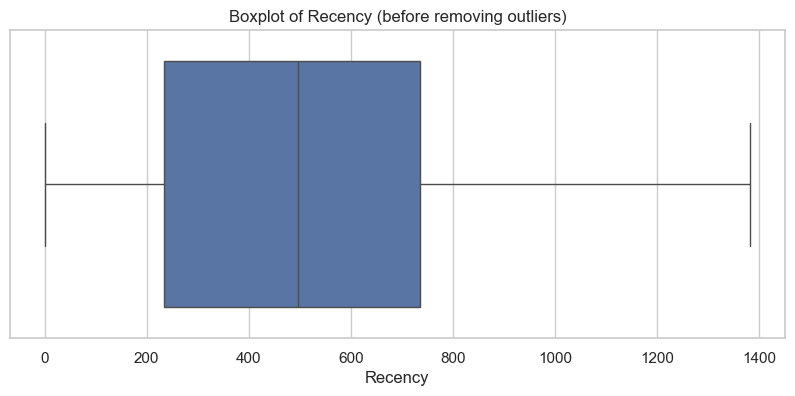

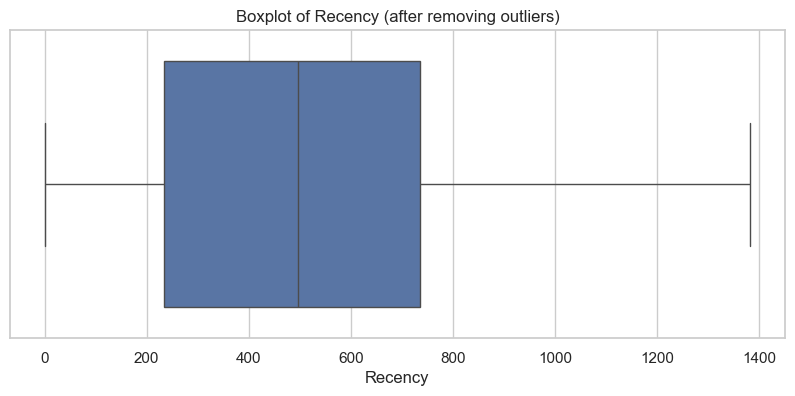

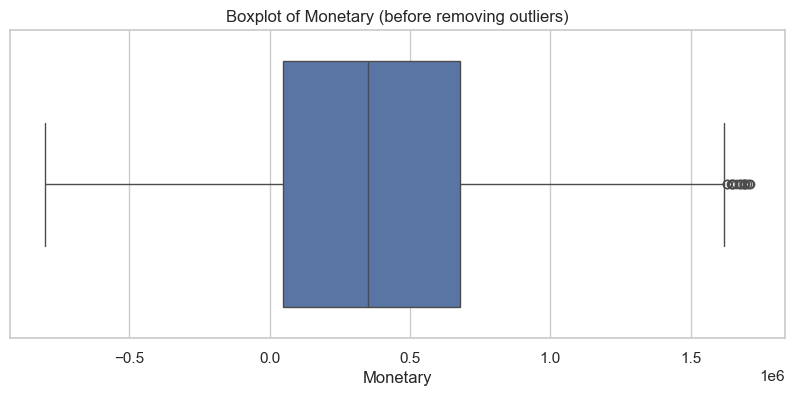

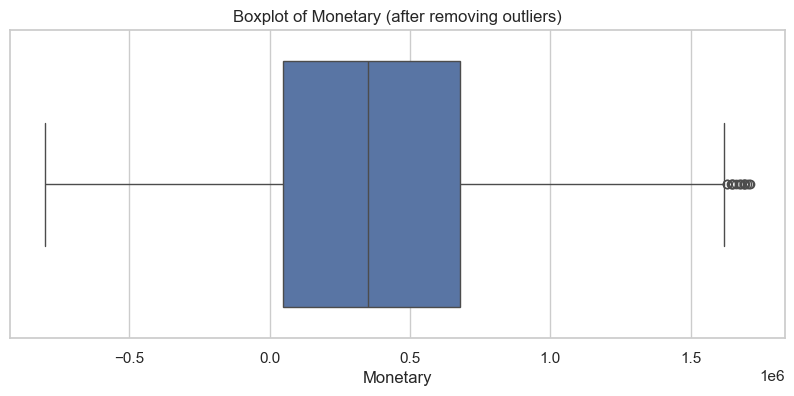

In [1391]:
# lower and upper bounds for outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

rfm_no_outliers = remove_outliers_iqr(rfm_no_outliers, 'Recency')
# rfm_no_outliers = remove_outliers_iqr(rfm_no_outliers, 'Frequency')
rfm_no_outliers = remove_outliers_iqr(rfm_no_outliers, 'Monetary')

for column in ['Recency', 
               # 'Frequency', 
               'Monetary']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=rfm_no_outliers[column])
    plt.title(f'Boxplot of {column} (before removing outliers)')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=rfm_no_outliers[column])
    plt.title(f'Boxplot of {column} (after removing outliers)')
    plt.show()

In [1435]:
rfm = rfm_no_outliers.copy()

In [1436]:
scaler = StandardScaler()
rfm_normalized = rfm[['Recency', 'Frequency', 'Monetary']]
rfm_normalized.head(1)

rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized.columns = ['Recency', 'Frequency', 'Monetary']
rfm_normalized.head(1)

Recency  Frequency  Monetary
0 -0.479106   9.104534   2.16345

/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: Fut

For _clusters=2, the silhouette score is 0.40177217297527723
For _clusters=3, the silhouette score is 0.44284101179183255


/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For _clusters=4, the silhouette score is 0.4520337693313904
For _clusters=5, the silhouette score is 0.4598117396132439


/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For _clusters=6, the silhouette score is 0.43508410170402056
For _clusters=7, the silhouette score is 0.3995831250493788


/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For _clusters=8, the silhouette score is 0.4106098200988744


/Users/thailinhpham/anaconda3/envs/t1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/870029727.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_counts.index, y=unique_counts.values, palette="viridis")


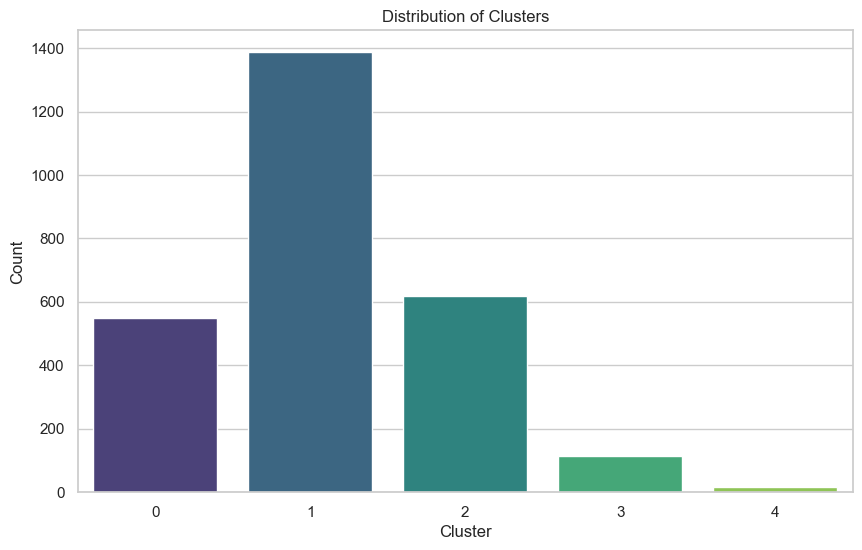

In [1437]:
nclusters = 5

kmeans = KMeans (n_clusters=nclusters, max_iter=50)
kmeans.fit(rfm_normalized)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    ssd.append(kmeans.inertia_)

from sklearn.metrics import silhouette_score

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans =  KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For _clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

kmeans = KMeans (n_clusters=nclusters, max_iter=50)
kmeans.fit(rfm_normalized)

rfm = rfm.reset_index(drop=False)
# rfm.head(1)

rfm_normalized.loc[:,'customer_id'] = rfm['customer_id']
# rfm_normalized.head(1)

rfm_normalized['cluster'] = kmeans.labels_
# rfm_normalized.head(1)

unique_counts = rfm_normalized['cluster'].value_counts().sort_index()

# Using a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_counts.index, y=unique_counts.values, palette="viridis")
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(len(unique_counts.index)), unique_counts.index)  # ensures that all cluster labels are shown
plt.show()

In [1438]:
# #### DEFINE CLUSTER

# # print(rfm_normalized['cluster'].unique())
# cluster_to_segment = {
#     0: 'Best Customer',
#     1: 'New Customer',
#     2: 'At risk of leaving/churned',
#     # 3: 'Lost customer'
# }

# # Map the 'cluster' column to the 'Segment' column using the dictionary
# rfm_normalized['Segment'] = rfm_normalized['cluster'].map(cluster_to_segment)

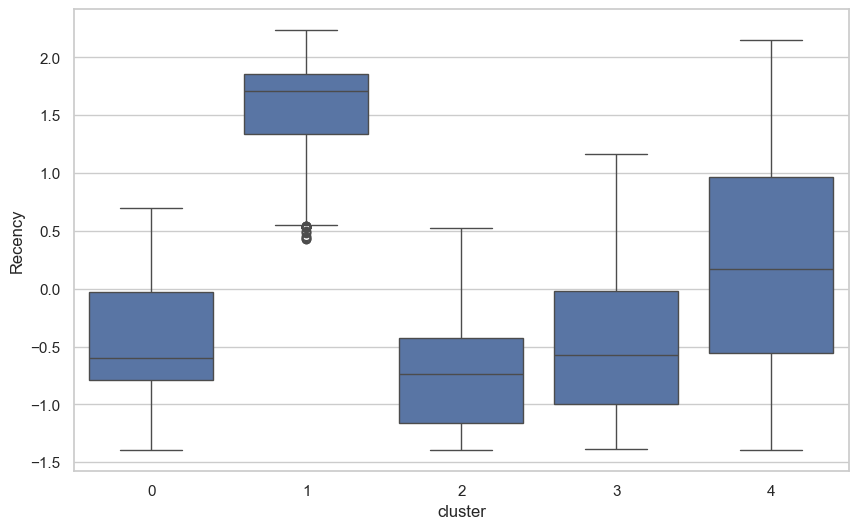

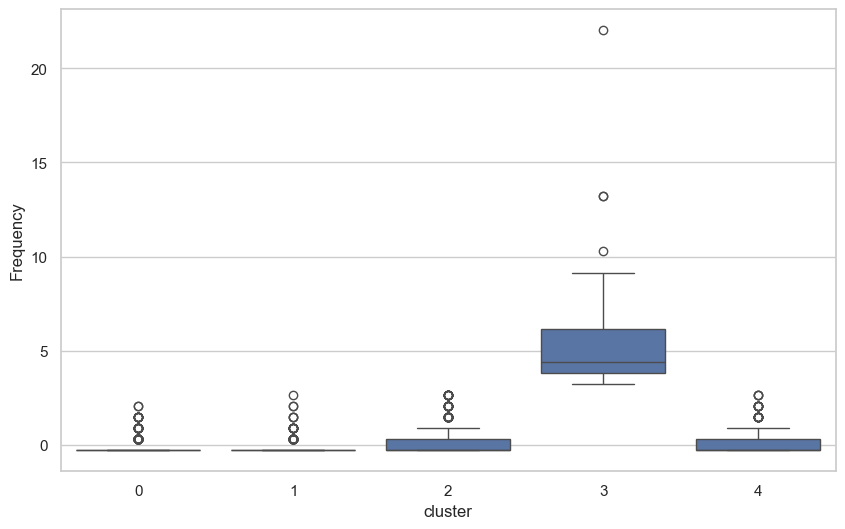

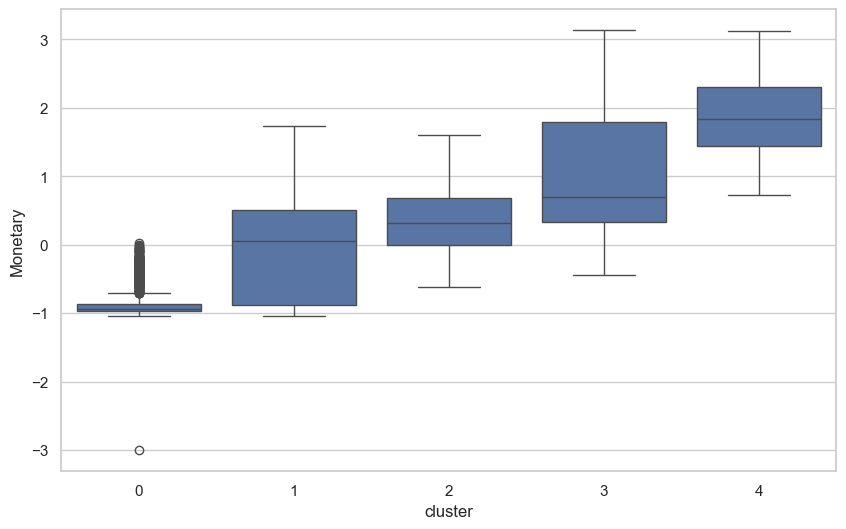

In [1396]:
plt.figure(figsize=(10, 6))
sns.boxplot (x='cluster', y='Recency', data=rfm_normalized)
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot (x='cluster', y='Frequency', data=rfm_normalized)
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot (x='cluster', y='Monetary', data=rfm_normalized)
plt.show()

In [1432]:
# # Set the style for seaborn
# sns.set(style="whitegrid")

# # Define a consistent size for the scatter plots
# scatter_size = 50

# # Plotting Recency vs. Monetary
# plt.figure(figsize=(8, 4))
# sns.scatterplot(
#     x='Recency', 
#     y='Monetary', 
#     hue='Segment', 
#     data=rfm_normalized, 
#     palette='Set1', 
#     s=scatter_size
# )
# plt.title('Recency vs. Monetary Segmentation')
# plt.xlabel('Recency')
# plt.ylabel('Monetary')
# plt.legend(title='Customer Segment')
# plt.show()

# # Plotting Frequency vs. Monetary
# plt.figure(figsize=(8, 4))
# sns.scatterplot(
#     x='Frequency', 
#     y='Monetary', 
#     hue='Segment', 
#     data=rfm_normalized, 
#     palette='Set1', 
#     s=scatter_size
# )
# plt.title('Frequency vs. Monetary Segmentation')
# plt.xlabel('Frequency')
# plt.ylabel('Monetary')
# plt.legend(title='Customer Segment')
# plt.show()

# # Plotting Frequency vs. Recency
# plt.figure(figsize=(8, 4))
# sns.scatterplot(
#     x='Frequency', 
#     y='Recency', 
#     hue='Segment', 
#     data=rfm_normalized, 
#     palette='Set1', 
#     s=scatter_size
# )
# plt.title('Frequency vs. Recency Segmentation')
# plt.xlabel('Frequency')
# plt.ylabel('Recency')
# plt.legend(title='Customer Segment')
# plt.show()

In [1398]:
# sns.pairplot(
#     rfm_normalized,
#     hue='Segment',  # make sure 'Segment' column exists in your dataframe
#     palette='Set1',
#     diag_kind='kde'
# )
# plt.suptitle('Pair Plot of RFM metrics with Customer Segments', y=1.02)
# plt.show()

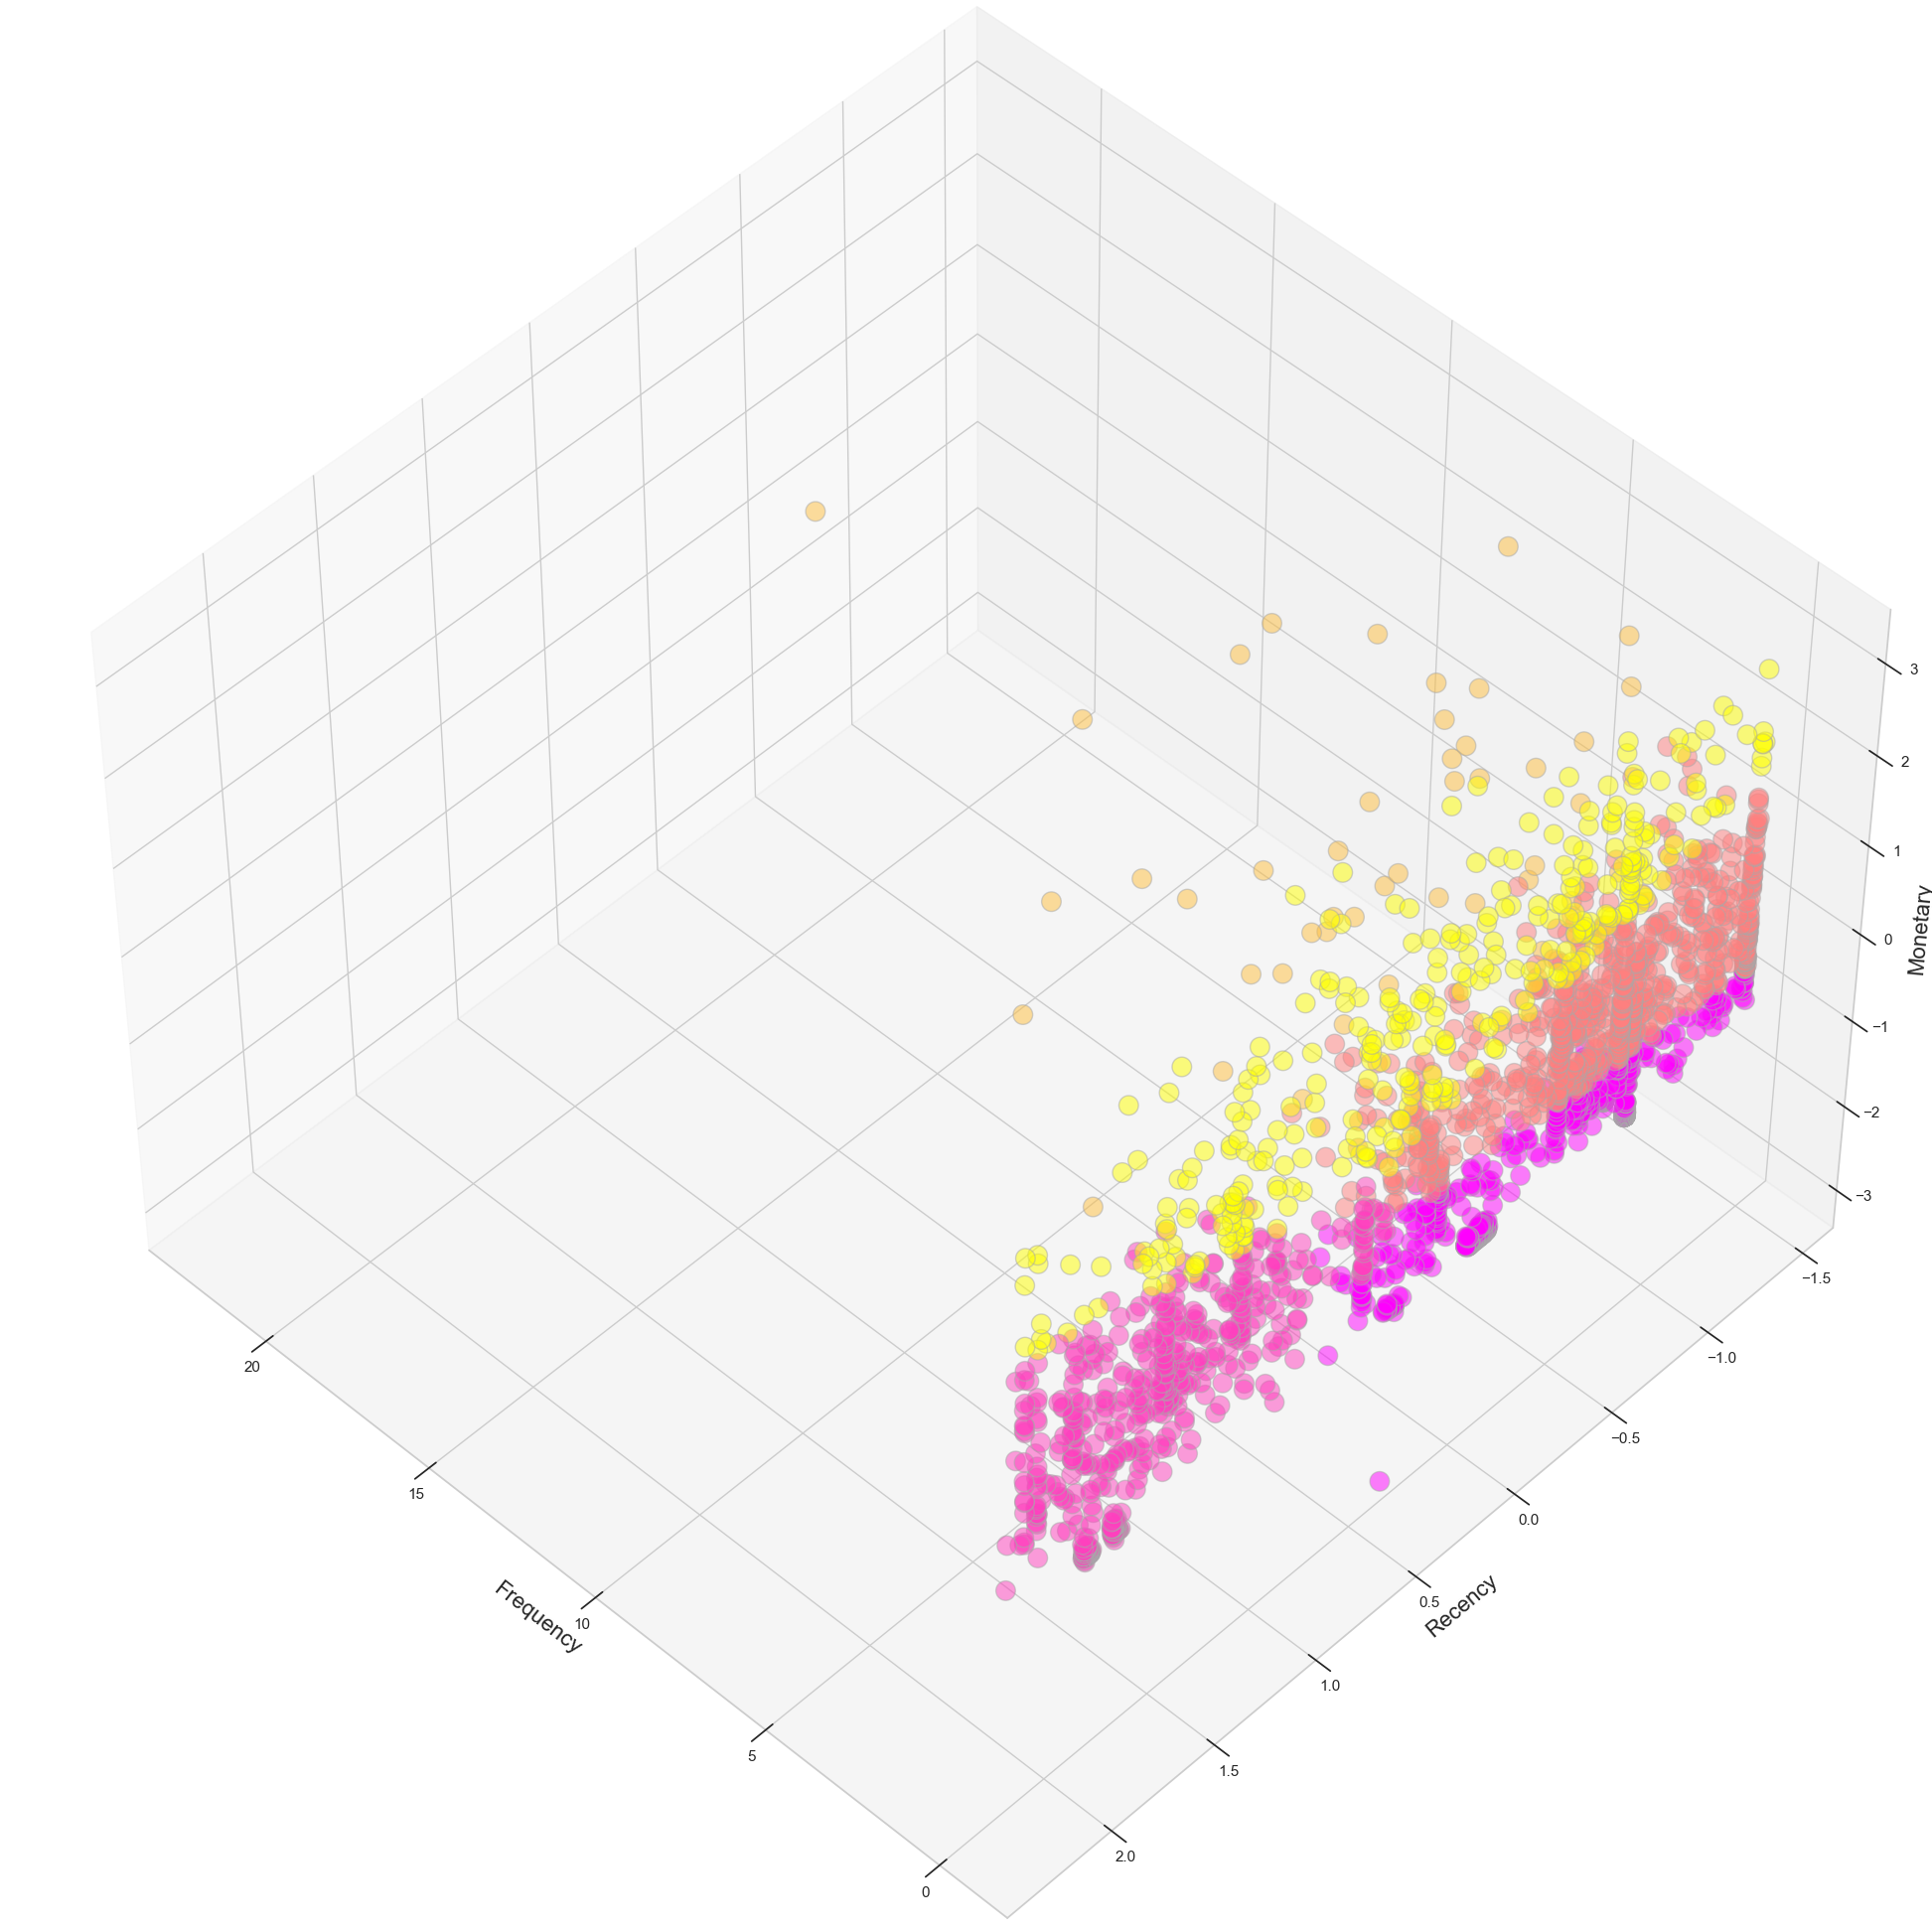

In [1399]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = (25, 25)

fig = plt.figure(1)
plt.clf()

ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)

ax.scatter(rfm_normalized['Frequency'], rfm_normalized['Recency'], rfm_normalized['Monetary'],
           c=rfm_normalized['cluster'], s=200, cmap='spring',
           alpha=0.5, edgecolor='darkgrey')

ax.set_xlabel('Frequency', fontsize=16)
ax.set_ylabel('Recency', fontsize=16)
ax.set_zlabel('Monetary', fontsize=16)

plt.show()

KeyError: 3

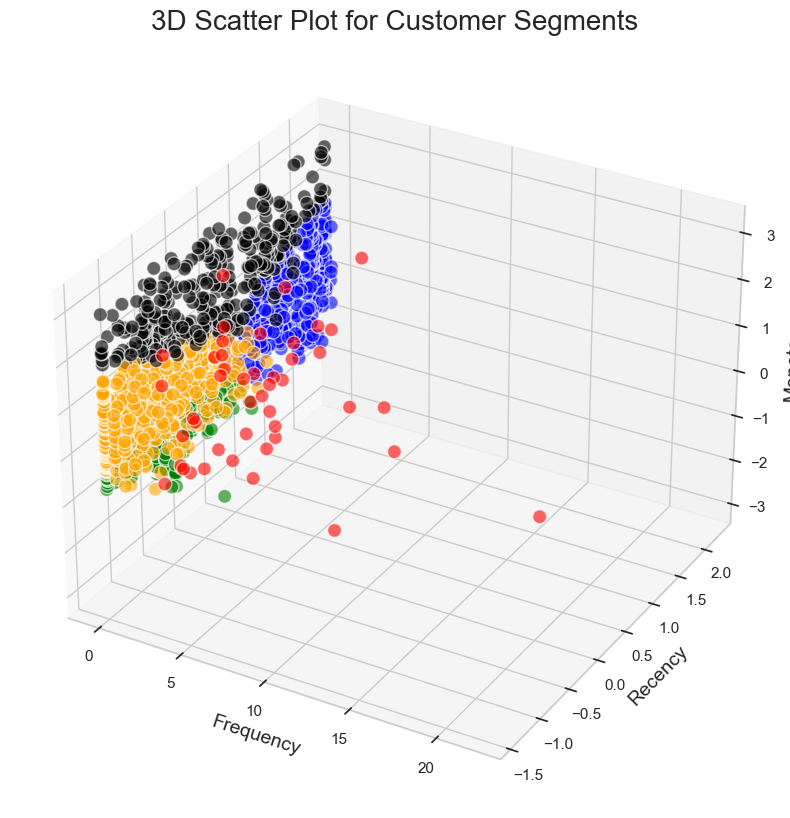

In [1434]:
from mpl_toolkits.mplot3d import Axes3D

# Set the figure size
plt.rcParams["figure.figsize"] = (12, 10)

# Create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = {0: 'green', 1: 'blue', 2: 'orange', 
          3: 'red', 4: 'black'} ## IGNORE ERROR
# Map cluster labels to colors
cluster_colors = rfm_normalized['cluster'].map(colors)

# Create a scatter plot
scatter = ax.scatter(
    rfm_normalized['Frequency'],
    rfm_normalized['Recency'],
    rfm_normalized['Monetary'],
    c=cluster_colors,  # Use the cluster_colors defined by the color dict
    s=100,
    alpha=0.6,
    edgecolor='w'
)

# Customize labels
ax.set_xlabel('Frequency', fontsize=14)
ax.set_ylabel('Recency', fontsize=14)
ax.set_zlabel('Monetary', fontsize=14)

# Customize title
ax.set_title('3D Scatter Plot for Customer Segments', fontsize=20)

# Produce a legend with custom colors
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cluster_to_segment[k],
                          markerfacecolor=v, markersize=10) for k, v in colors.items()]
legend = ax.legend(handles=legend_elements, loc="upper left", title="Customer Segments")
legend.get_title().set_fontsize('14')  # Set font size for legend title

# Show the plot
plt.show()

In [1401]:
# def filter_customers_by_cluster(data_bills, data_cluster):
#     # Hợp nhất (merge) data_bills với data_cluster dựa trên 'customer_id' để 
#     # lọc ra tất cả records từ data_bills có customer_id nằm trong data_cluster
#     merged_data = data_bills.merge(data_cluster[['customer_id']], on='customer_id', how='inner')
#     return merged_data



# data_all_clusers = filter_customers_by_cluster(data_bills, rfm_normalized)

# data_all_clusers

In [1402]:
# Retrieve the standardized values of 'Recency', 'Frequency', 'Monetary'
scaled_values = rfm_normalized[['Recency', 'Frequency', 'Monetary']]

# Apply the inverse transformation to those values
original_values = scaler.inverse_transform(scaled_values)

# Replace the scaled values with the original values in your dataframe
rfm[['Recency', 'Frequency', 'Monetary']] = original_values

# Now rfm dataframe should have the original 'Recency', 'Frequency', 'Monetary' values

In [1403]:
rfm

customer_id  Recency  Frequency  s_discount_money  \
0     571c3c1d7f8b9ae9557fd9c5    350.0       17.0               0.0   
1     57677b207f8b9a2b763b525a   1320.0        1.0            7000.0   
2     57700cd07f8b9a04150fa788   1095.0        1.0               0.0   
3     57aedb7a7f8b9a9c25b6666d    735.0        3.0           59400.0   
4     57b179d57f8b9a200bde7d85   1101.0        1.0           14000.0   
...                        ...      ...        ...               ...   
2679  65334e6a1f53361b710da7c7      4.0        1.0               0.0   
2680  6534c923b389fcc1f10b41e8      1.0        1.0               0.0   
2681  65350ae183b945e45308ccd2      3.0        1.0               0.0   
2682  65362f2f058e39e1cf0ae5f3      1.0        2.0               0.0   
2683  65364da659ec9f648f021e06      2.0        1.0               0.0   

          Monetary  
0     1.313824e+06  
1     4.760000e+05  
2     5.140000e+05  
3     4.181067e+05  
4     1.420000e+05  
...            ...  
2679  3.402000e+05  
2680  9.700000e+05  
2681  8.000000e+05  
2682  4.347000e+05  
2683  1.318000e+06  

[2684 rows x 5 columns]

In [1404]:
rfm_normalized = rfm_normalized.set_index(rfm.index)  # Ensuring the index is aligned for merging
rfm_combined = rfm.merge(rfm_normalized, left_index=True, right_index=True, suffixes=('', '_normalized'))
rfm_combined

customer_id  Recency  Frequency  s_discount_money  \
0     571c3c1d7f8b9ae9557fd9c5    350.0       17.0               0.0   
1     57677b207f8b9a2b763b525a   1320.0        1.0            7000.0   
2     57700cd07f8b9a04150fa788   1095.0        1.0               0.0   
3     57aedb7a7f8b9a9c25b6666d    735.0        3.0           59400.0   
4     57b179d57f8b9a200bde7d85   1101.0        1.0           14000.0   
...                        ...      ...        ...               ...   
2679  65334e6a1f53361b710da7c7      4.0        1.0               0.0   
2680  6534c923b389fcc1f10b41e8      1.0        1.0               0.0   
2681  65350ae183b945e45308ccd2      3.0        1.0               0.0   
2682  65362f2f058e39e1cf0ae5f3      1.0        2.0               0.0   
2683  65364da659ec9f648f021e06      2.0        1.0               0.0   

          Monetary  Recency_normalized  Frequency_normalized  \
0     1.313824e+06           -0.479106              9.104534   
1     4.760000e+05            2.071722             -0.292565   
2     5.140000e+05            1.480035             -0.292565   
3     4.181067e+05            0.533336              0.882072   
4     1.420000e+05            1.495814             -0.292565   
...            ...                 ...                   ...   
2679  3.402000e+05           -1.388989             -0.292565   
2680  9.700000e+05           -1.396878             -0.292565   
2681  8.000000e+05           -1.391618             -0.292565   
2682  4.347000e+05           -1.396878              0.294753   
2683  1.318000e+06           -1.394248             -0.292565   

      Monetary_normalized    customer_id_normalized  cluster  
0                2.163450  571c3c1d7f8b9ae9557fd9c5        3  
1                0.115038  57677b207f8b9a2b763b525a        1  
2                0.207945  57700cd07f8b9a04150fa788        1  
3               -0.026507  57aedb7a7f8b9a9c25b6666d        1  
4               -0.701566  57b179d57f8b9a200bde7d85        1  
...                   ...                       ...      ...  
2679            -0.216983  65334e6a1f53361b710da7c7        2  
2680             1.322829  6534c923b389fcc1f10b41e8        2  
2681             0.907192  65350ae183b945e45308ccd2        2  
2682             0.014062  65362f2f058e39e1cf0ae5f3        2  
2683             2.173662  65364da659ec9f648f021e06        4  

[2684 rows x 10 columns]

## ----> Kết quả của những kỹ thuật dưới đây, sẽ được kết hợp với nhau trở thành những ý hưởng hỗ trợ để nhìn sâu hơn vào hành vi cũng như đặc điểm của từng nhóm khách hàng

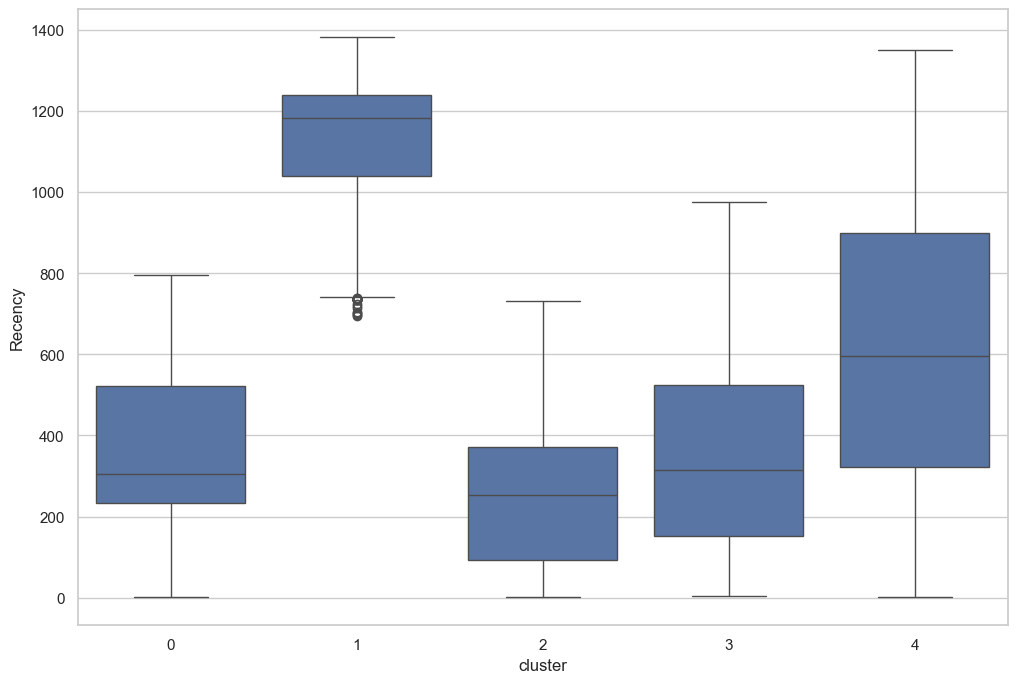

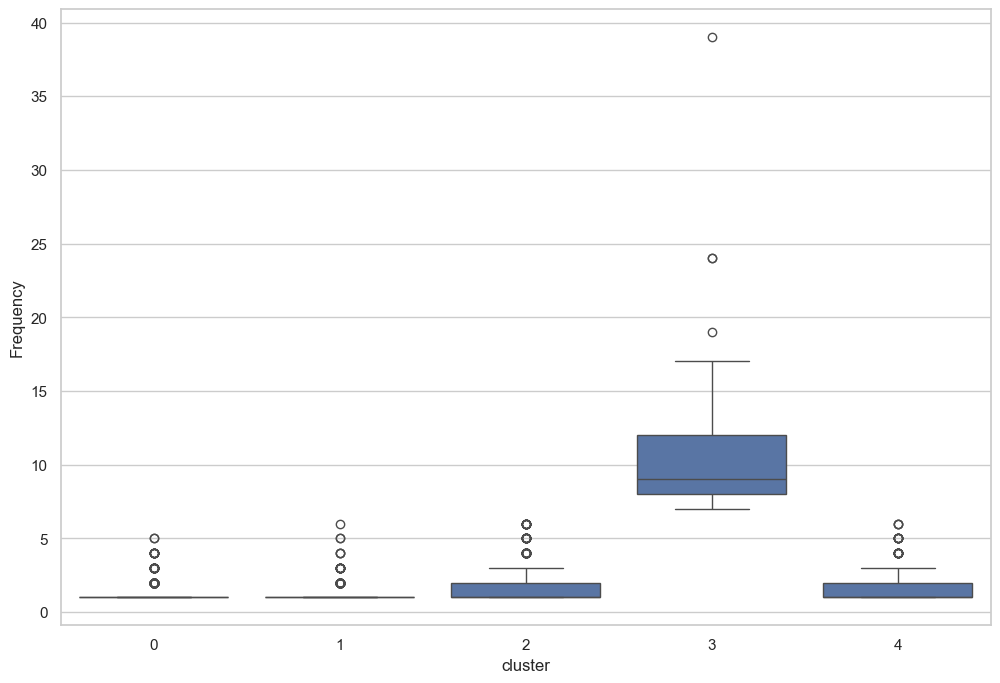

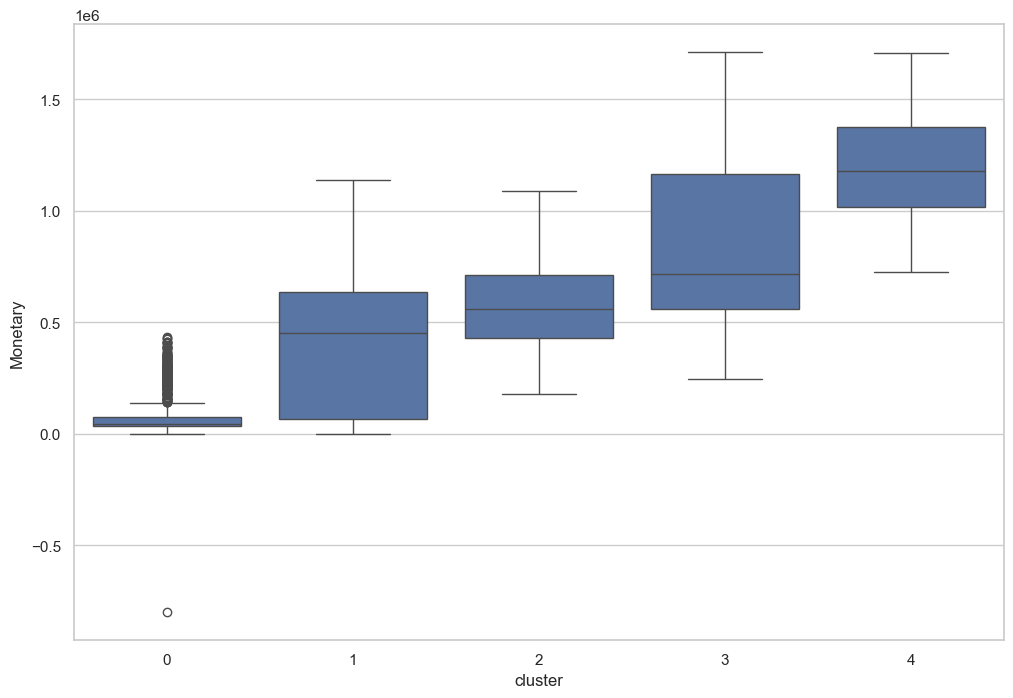

In [1405]:
plt.figure(figsize=(12, 8))
sns.boxplot (x='cluster', y='Recency', data=rfm_combined)
plt.show()
plt.figure(figsize=(12, 8))
sns.boxplot (x='cluster', y='Frequency', data=rfm_combined)
plt.show()
plt.figure(figsize=(12, 8))
sns.boxplot (x='cluster', y='Monetary', data=rfm_combined)
plt.show()

In [1406]:
data_cluster_0 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_1 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_2 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_3 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_4 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_5 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_6 = pd.DataFrame(columns=rfm_combined.columns)
data_cluster_7 = pd.DataFrame(columns=rfm_normalized.columns)

data_all_clusters = [data_cluster_0,
            data_cluster_1,
            data_cluster_2,
            data_cluster_3,
            data_cluster_4,
            data_cluster_5,
            data_cluster_6,
            data_cluster_7]

for i in range(nclusters):
    data_all_clusters[i] = rfm_combined.loc[rfm_combined['cluster'] == i]
    print(data_all_clusters[i]['Monetary'].median())

44000.0
451000.0
561000.0
714900.7
1180000.0


In [1407]:
data_bill_cluster_0 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_1 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_2 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_3 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_4 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_5 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_6 = pd.DataFrame(columns=data_bills.columns)
data_bill_cluster_7 = pd.DataFrame(columns=data_bills.columns)

data_all = [data_bill_cluster_0,
            data_bill_cluster_1,
            data_bill_cluster_2,
            data_bill_cluster_3,
            data_bill_cluster_4,
            data_bill_cluster_5,
            data_bill_cluster_6,
            data_bill_cluster_7]


def filter_customers_by_cluster(data_bills, data_cluster):
    # Hợp nhất (merge) data_bills với data_cluster dựa trên 'customer_id' để 
    # lọc ra tất cả records từ data_bills có customer_id nằm trong data_cluster
    merged_data = data_bills.merge(data_cluster[['customer_id']], on='customer_id', how='inner')
    return merged_data

sum_cus = 0.0
sum_rev = 0.0


for i in range(nclusters):
    data_all[i] = filter_customers_by_cluster(data_bills, data_all_clusters[i])
    sum_cus = sum_cus + data_all[i]['customer_id'].count()
    sum_rev = sum_rev + data_all[i]['s_grand_total'].sum()


for i in range(nclusters):
    print('%cus of cluster ', i, ' is ', data_all[i]['customer_id'].count()/ sum_cus * 100)
    print('%rev of cluster ', i, ' is ', data_all[i]['s_grand_total'].sum()/ sum_rev * 100)

%cus of cluster  0  is  30.688883362347674
%rev of cluster  0  is  5.677565067145711
%cus of cluster  1  is  16.761999502611292
%rev of cluster  1  is  14.383224900849362
%cus of cluster  2  is  27.35637901019647
%rev of cluster  2  is  30.97556635460983
%cus of cluster  3  is  12.683412086545637
%rev of cluster  3  is  19.35100970691718
%cus of cluster  4  is  12.509326038298932
%rev of cluster  4  is  29.612633970477916


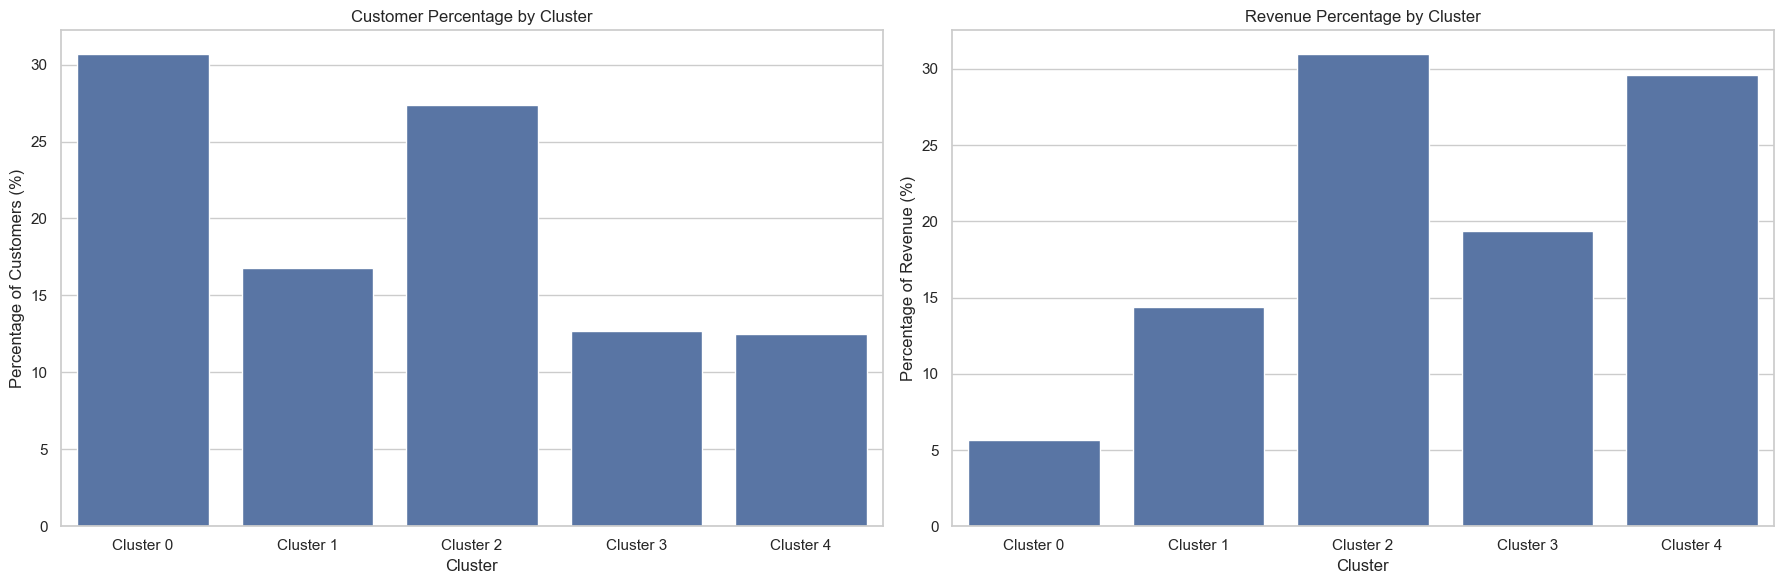

In [1408]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming nclusters and data_all_clusters are properly defined

# Collect the data for visualization
customer_percentages = []
revenue_percentages = []
cluster_labels = []

for i in range(nclusters):
    # Calculate the percentages
    cluster_cus_percentage = data_all[i]['customer_id'].count() / sum_cus * 100
    cluster_rev_percentage = data_all[i]['s_grand_total'].sum() / sum_rev * 100

    # Append data for visualization
    customer_percentages.append(cluster_cus_percentage)
    revenue_percentages.append(cluster_rev_percentage)
    cluster_labels.append('Cluster {}'.format(i))

# Now plot the data
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot customer percentages
sns.barplot(ax=axes[0], x=cluster_labels, y=customer_percentages)
axes[0].set_title('Customer Percentage by Cluster')
axes[0].set_ylabel('Percentage of Customers (%)')
axes[0].set_xlabel('Cluster')

# Plot revenue percentages
sns.barplot(ax=axes[1], x=cluster_labels, y=revenue_percentages)
axes[1].set_title('Revenue Percentage by Cluster')
axes[1].set_ylabel('Percentage of Revenue (%)')
axes[1].set_xlabel('Cluster')

# Optimize layout for better visual display
plt.tight_layout()

# Show plot
plt.show()


### 4.4. Sequential Pattern Mining:

Sử dụng thuật toán như PrefixSpan để tìm ra các chuỗi mua hàng phổ biến - sản phẩm nào thường được mua sau sản phẩm nào, hoặc sự tiêu dùng dịch vụ theo thời gian.
thông qua product_id và to_user_date, ta có thể tìm ra các mô hình mua sắm liên tục qua thời gian.

In [1409]:
def SPM_plot(data_4):
    merged_data = pd.merge(data_4, data_products, on='product_id', how='left')
    
    # sx dữ liệu theo 'customer_id' và 'to_user_date'
    merged_data_sorted = merged_data.sort_values(by=['customer_id', 'to_user_date'])
    
    transactions_with_names = merged_data_sorted.groupby('customer_id')['product_name'].apply(list)
    
    sequences_with_names = transactions_with_names.tolist()
    
    # Sequential Pattern Mining với PrefixSpan
    ps = PrefixSpan(sequences_with_names)
    
    # Tìm common patterns với minimum support
    patterns_with_names = ps.frequent(2)  # Ví dụ: đặt minimum support là 2
    
    # In ra các mẫu tìm được
    # for pattern in patterns_with_names:
    #     print(pattern)
    
    # Vẽ network graph
    G = nx.DiGraph()
    
    # Đảm bảo rằng mỗi cạnh được thêm vào có weight là số lần xuất hiện của mẫu
    for support, items in patterns_with_names:
        for i in range(len(items)-1):
            # Check xem cạnh đã có trong graph hay chưa để cộng dồn support
            if G.has_edge(items[i], items[i+1]):
                # Tăng weight (support) của cạnh nếu nó đã tồn tại
                G[items[i]][items[i+1]]['weight'] += support
            else:
                # Tạo cạnh mới với weight bằng support nếu nó chưa tồn tại
                G.add_edge(items[i], items[i+1], weight=support)
    
    pos = nx.spring_layout(G, k=200) # có thể tăng giá trị 'k' để tăng khoảng cách
    
    node_size = 300
    font_size = 10
    nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=font_size)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3) # Thử điều chỉnh label_pos để thay đổi vị trí nhãn cạnh
    
    plt.show()


    patterns_df = pd.DataFrame(patterns_with_names, columns=['Support', 'Pattern'])
    patterns_df['Length'] = patterns_df['Pattern'].apply(len)  # add cột Length vào dataframe
    
    print(patterns_df.sort_values(by='Support', ascending=False).head(10))  
    plt.figure(figsize=(8, 4))
    # Visualize: ví dụ dùng bar plot cho support
    patterns_df.sort_values(by='Support', ascending=False).head(10).plot(
        x='Pattern', 
        y='Support', 
        kind='bar', 
        legend=None,
        title='Top Sequential Patterns'
    )
    plt.xlabel('Patterns')
    plt.ylabel('Support')
    plt.xticks(rotation=45)
    plt.tight_layout() 
    plt.show()

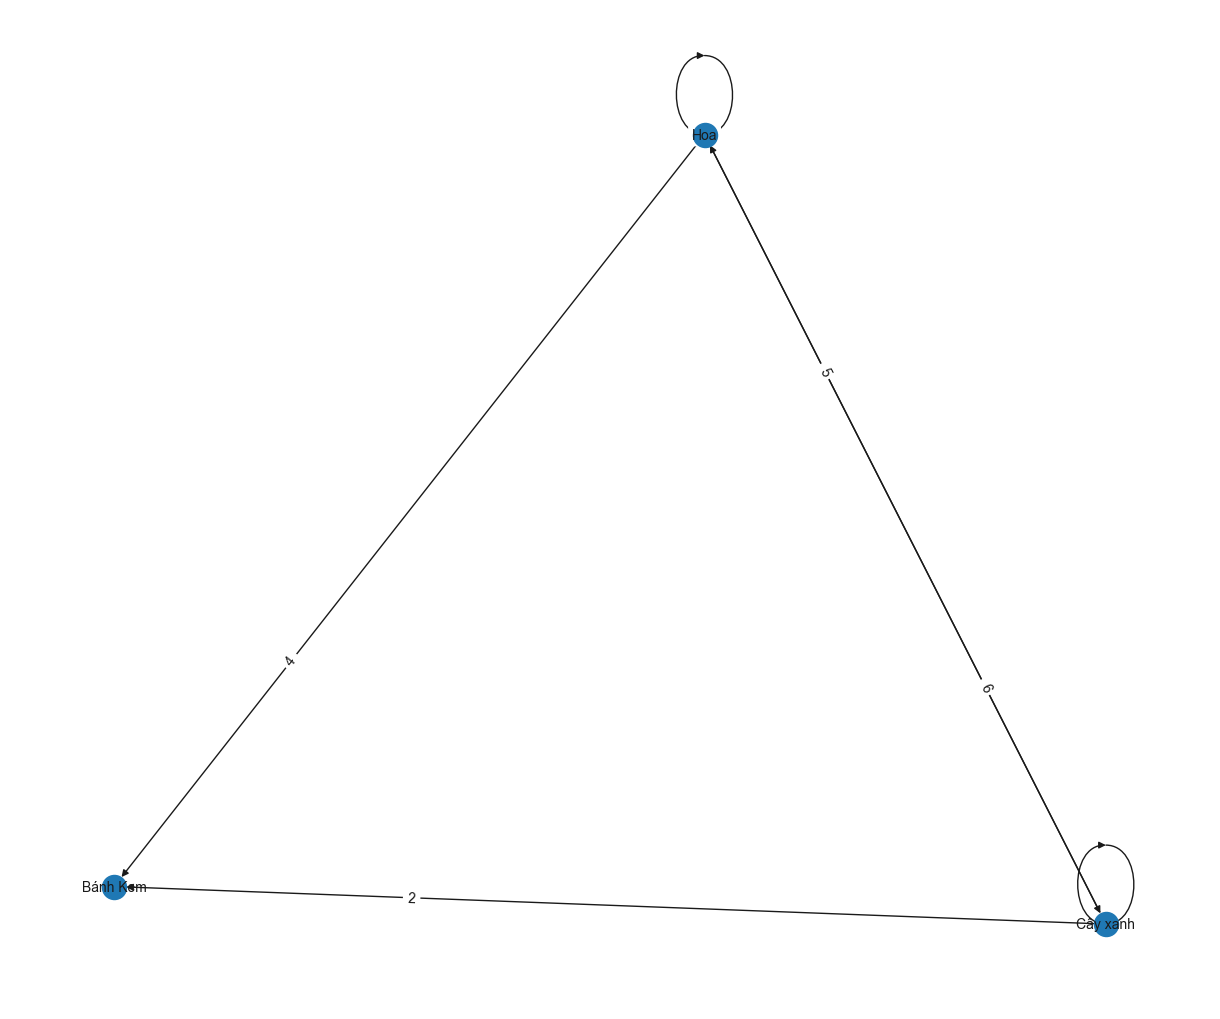

    Support                   Pattern  Length
0       585                     [Hoa]       1
8       421                [Cây xanh]       1
1        88                [Hoa, Hoa]       2
12       47                [Bánh Kem]       1
2        30           [Hoa, Hoa, Hoa]       3
7        24  [Quà trang trí/lưu niệm]       1
3        11      [Hoa, Hoa, Hoa, Hoa]       4
14        8       [Quà Tặng Sức khỏe]       1
9         7      [Cây xanh, Cây xanh]       2
13        7           [Kẹo Chocolate]       1


<Figure size 800x400 with 0 Axes>

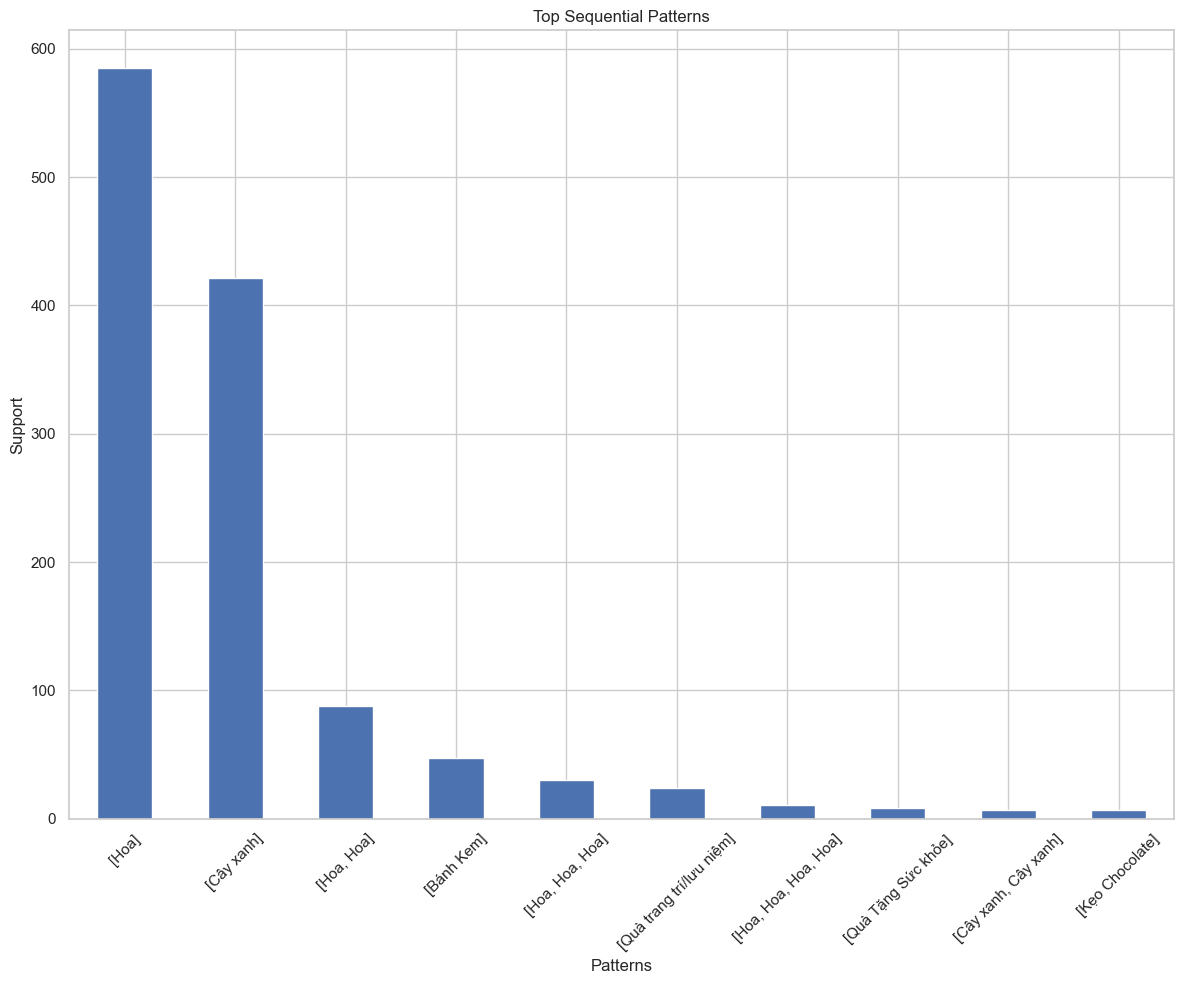

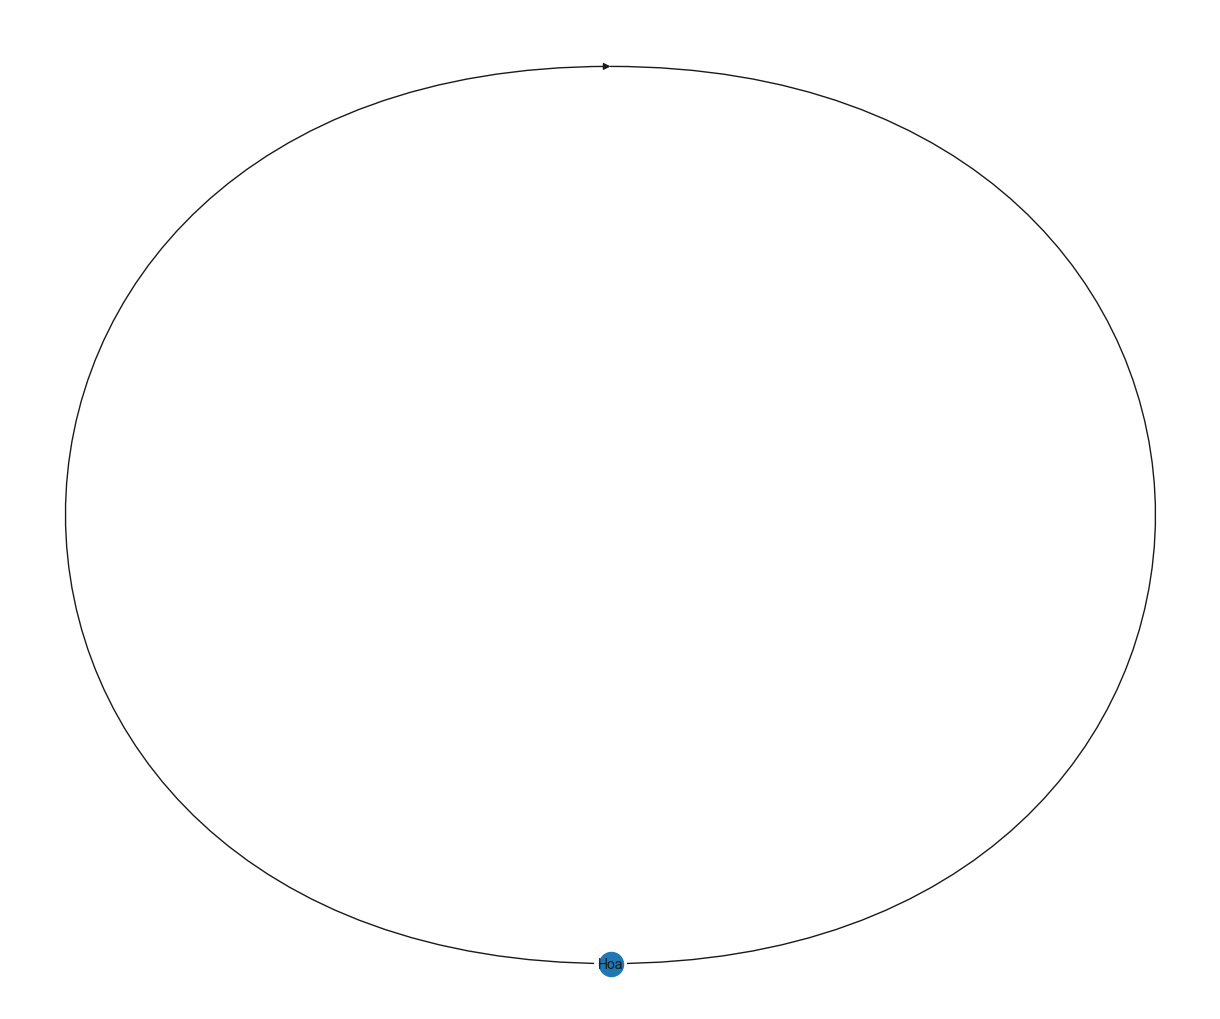

   Support                    Pattern  Length
0      563                      [Hoa]       1
1       71                 [Hoa, Hoa]       2
2       17            [Hoa, Hoa, Hoa]       3
3        6       [Hoa, Hoa, Hoa, Hoa]       4
5        6                 [Cây xanh]       1
4        3  [Hoa, Hoa, Hoa, Hoa, Hoa]       5
6        3                 [Bánh Kem]       1
7        2   [Quà trang trí/lưu niệm]       1


<Figure size 800x400 with 0 Axes>

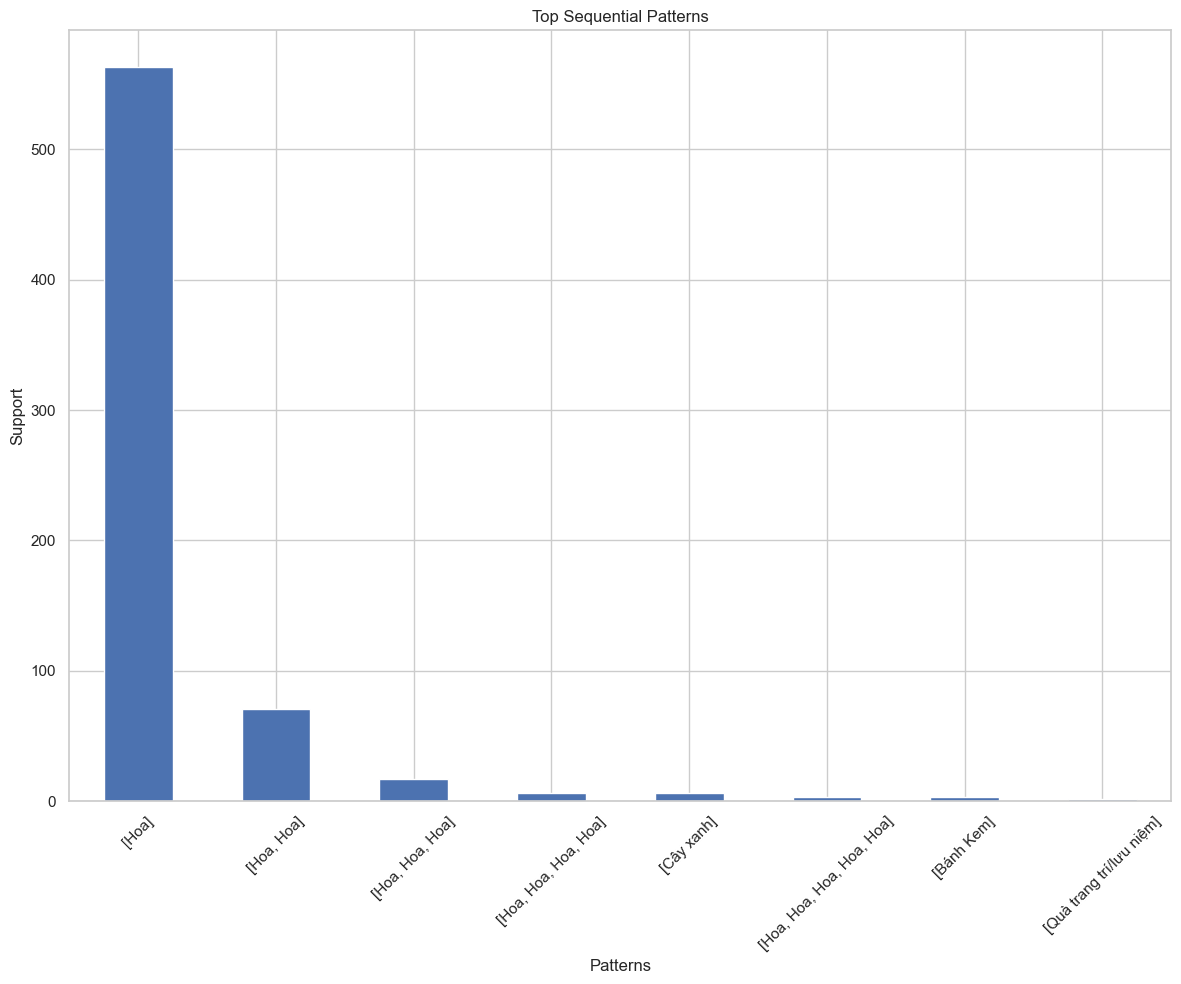

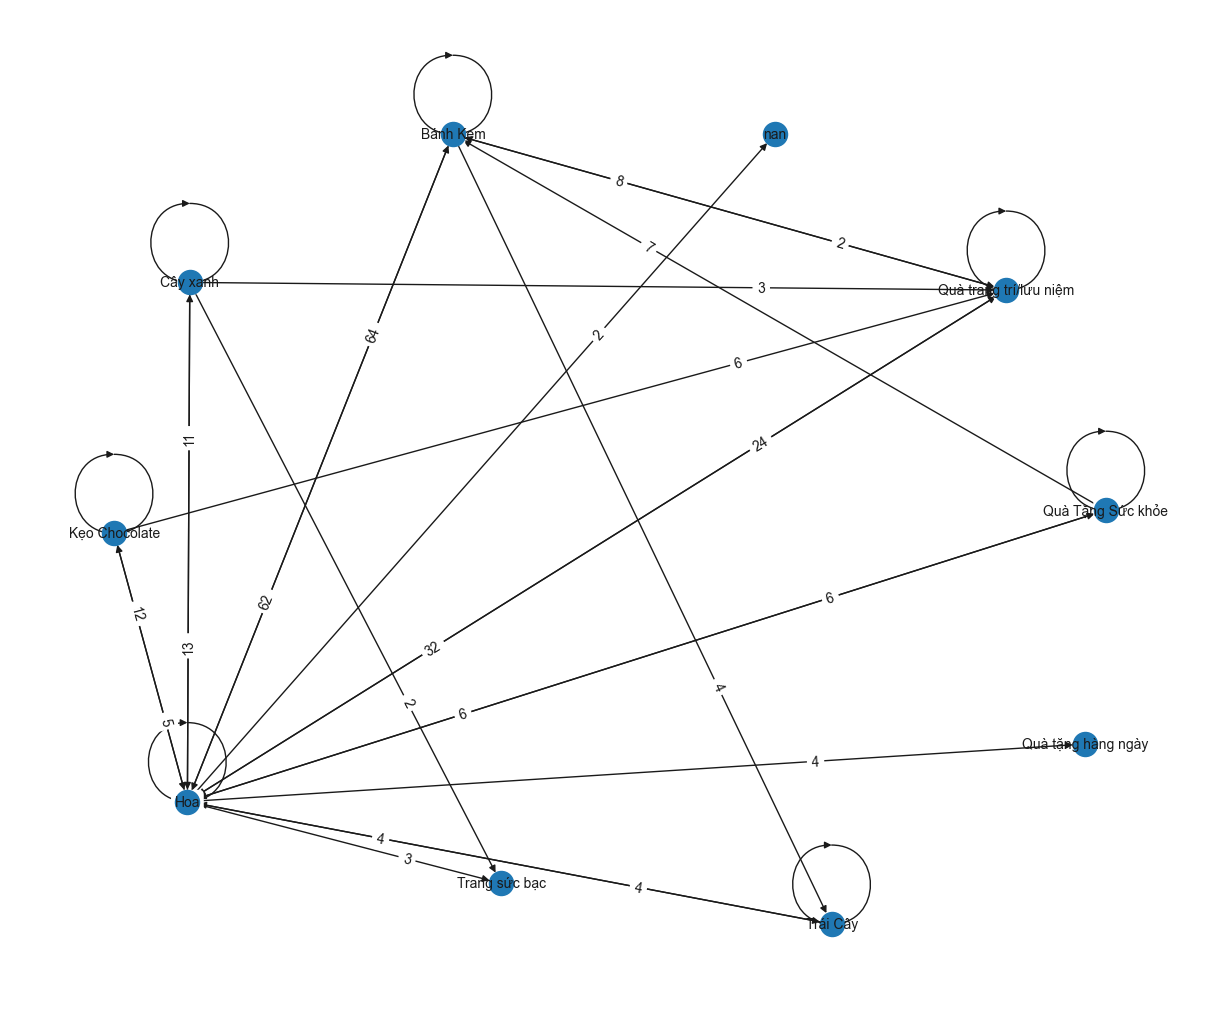

    Support                   Pattern  Length
0       489                     [Hoa]       1
1       145                [Hoa, Hoa]       2
41       80                [Bánh Kem]       1
62       63  [Quà trang trí/lưu niệm]       1
2        58           [Hoa, Hoa, Hoa]       3
54       34                [Cây xanh]       1
3        31      [Hoa, Hoa, Hoa, Hoa]       4
38       26                [Trái Cây]       1
32       23       [Quà Tặng Sức khỏe]       1
14       22           [Hoa, Bánh Kem]       2


<Figure size 800x400 with 0 Axes>

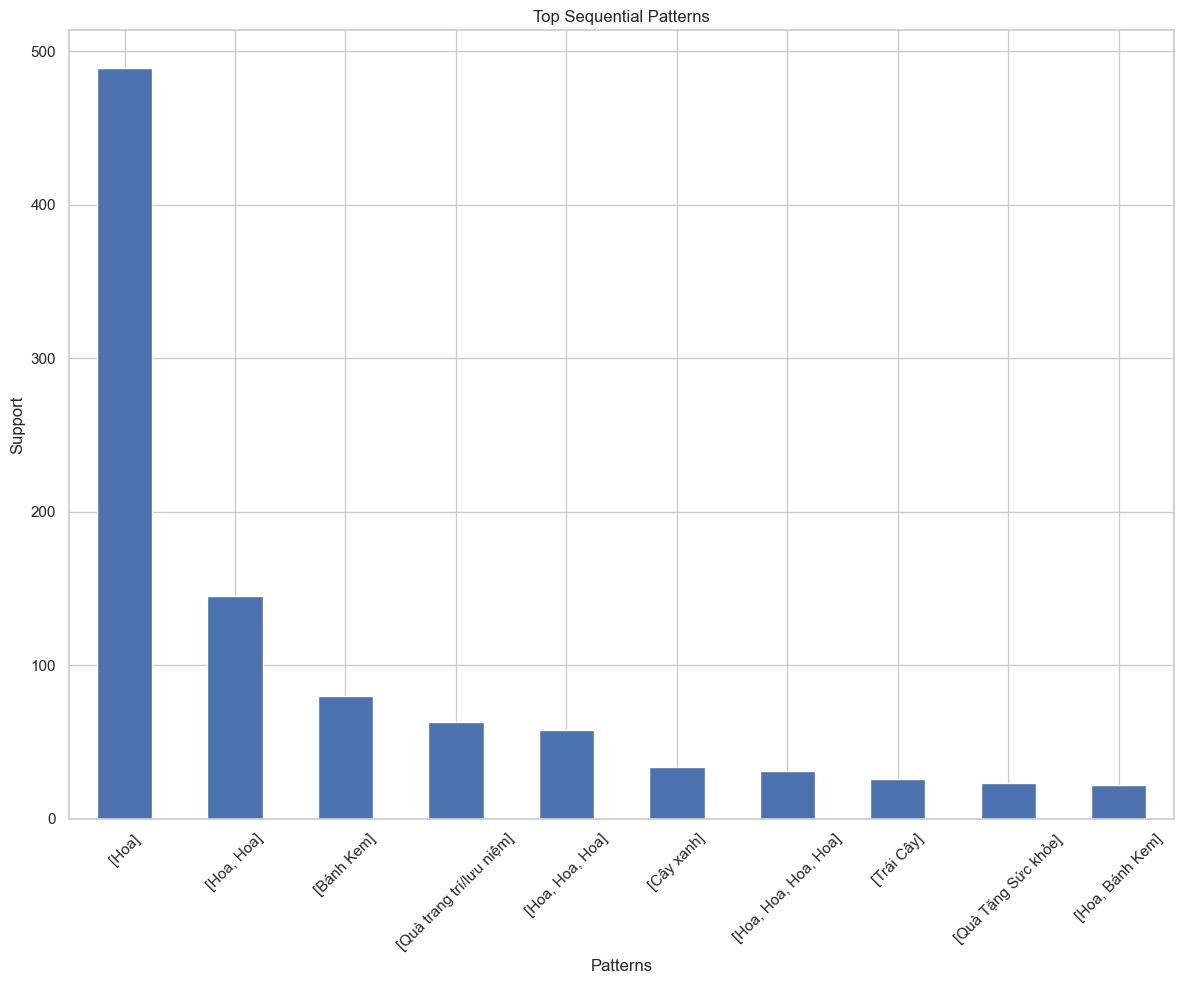

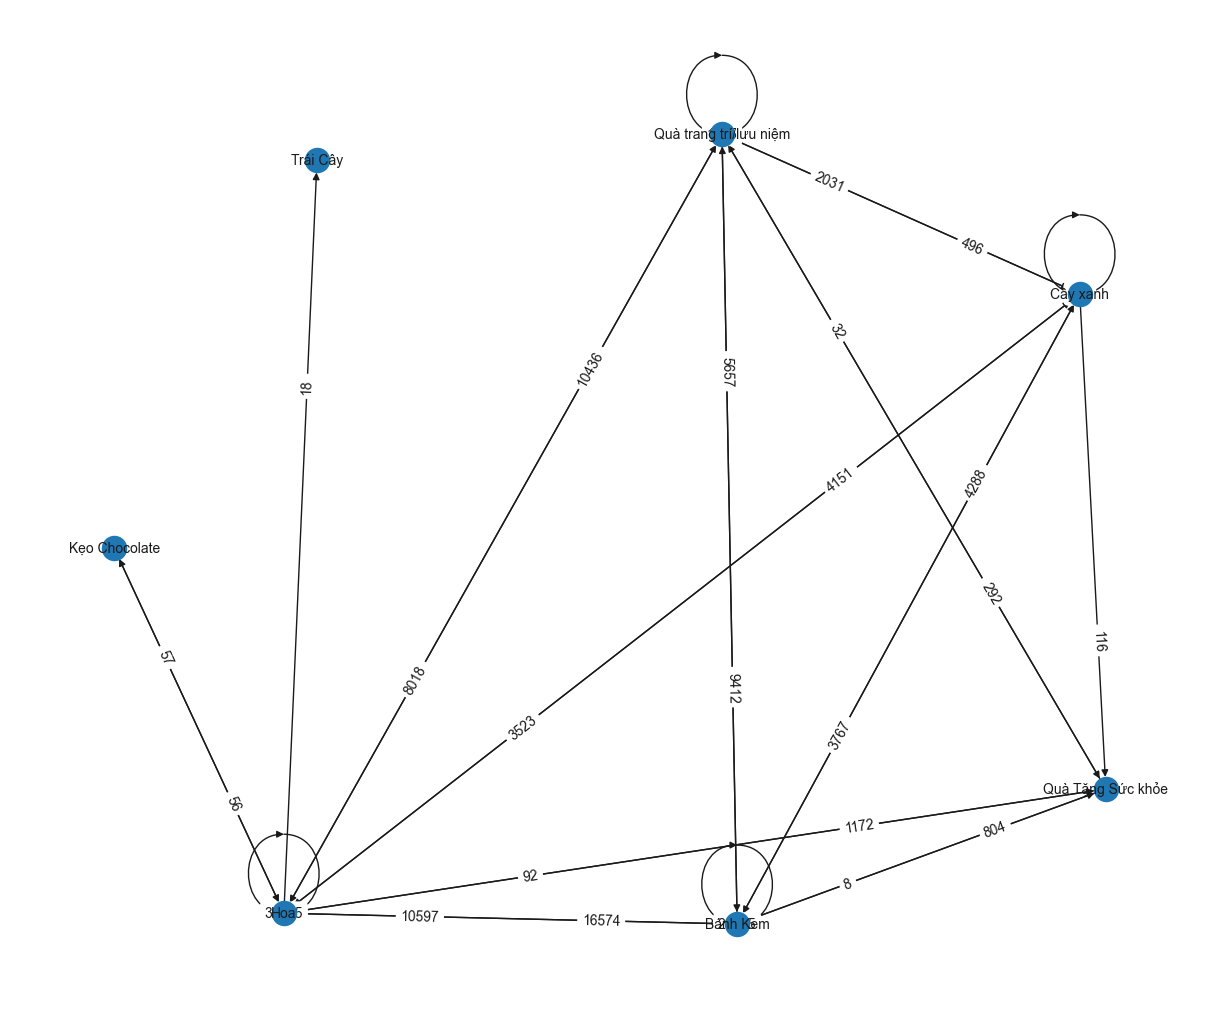

      Support                                   Pattern  Length
0          45                                     [Hoa]       1
1          45                                [Hoa, Hoa]       2
2          45                           [Hoa, Hoa, Hoa]       3
3          45                      [Hoa, Hoa, Hoa, Hoa]       4
4          42                 [Hoa, Hoa, Hoa, Hoa, Hoa]       5
5          41            [Hoa, Hoa, Hoa, Hoa, Hoa, Hoa]       6
6          36       [Hoa, Hoa, Hoa, Hoa, Hoa, Hoa, Hoa]       7
7          23  [Hoa, Hoa, Hoa, Hoa, Hoa, Hoa, Hoa, Hoa]       8
6893       18                                [Bánh Kem]       1
4692       18                           [Hoa, Bánh Kem]       2


<Figure size 800x400 with 0 Axes>

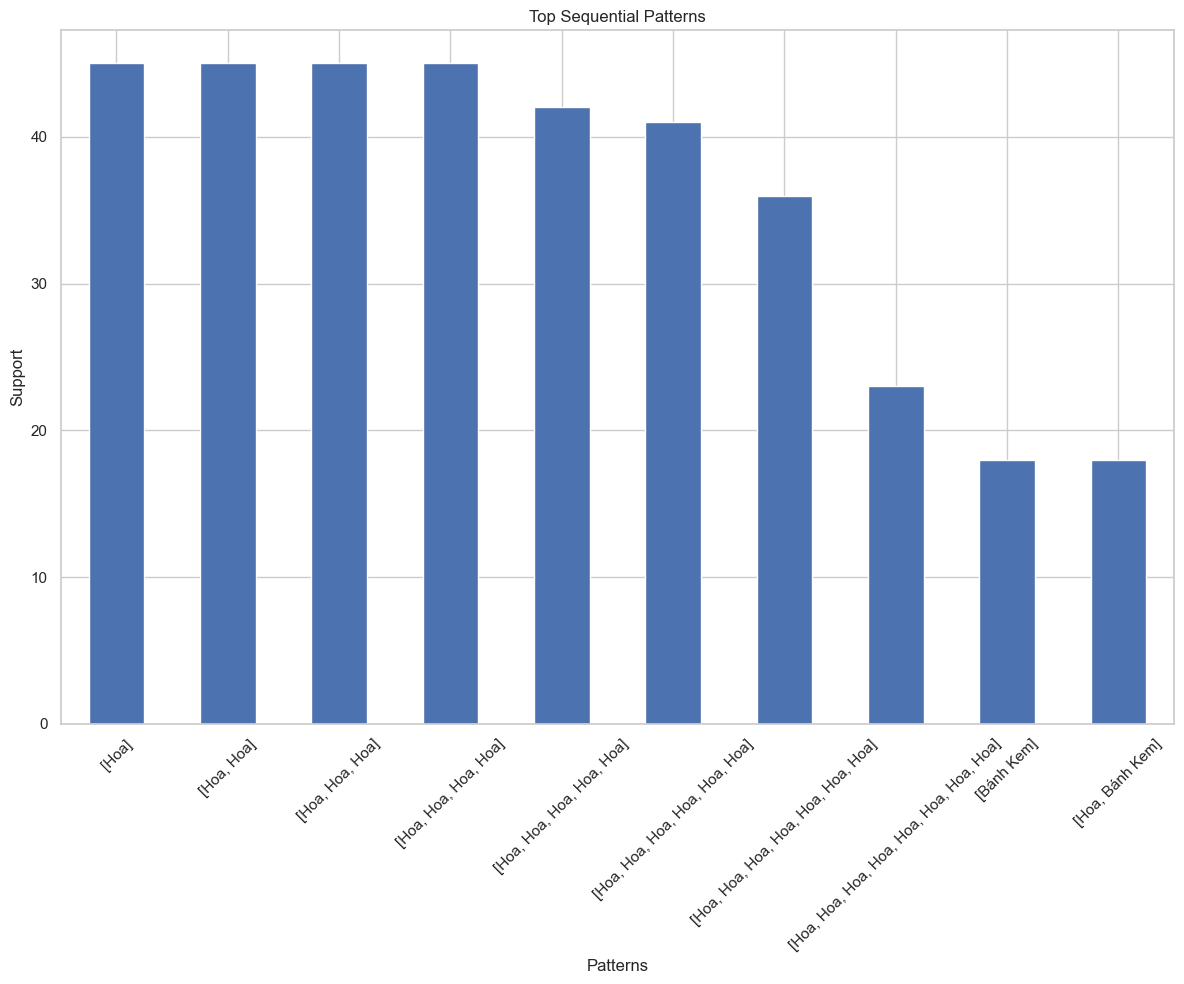

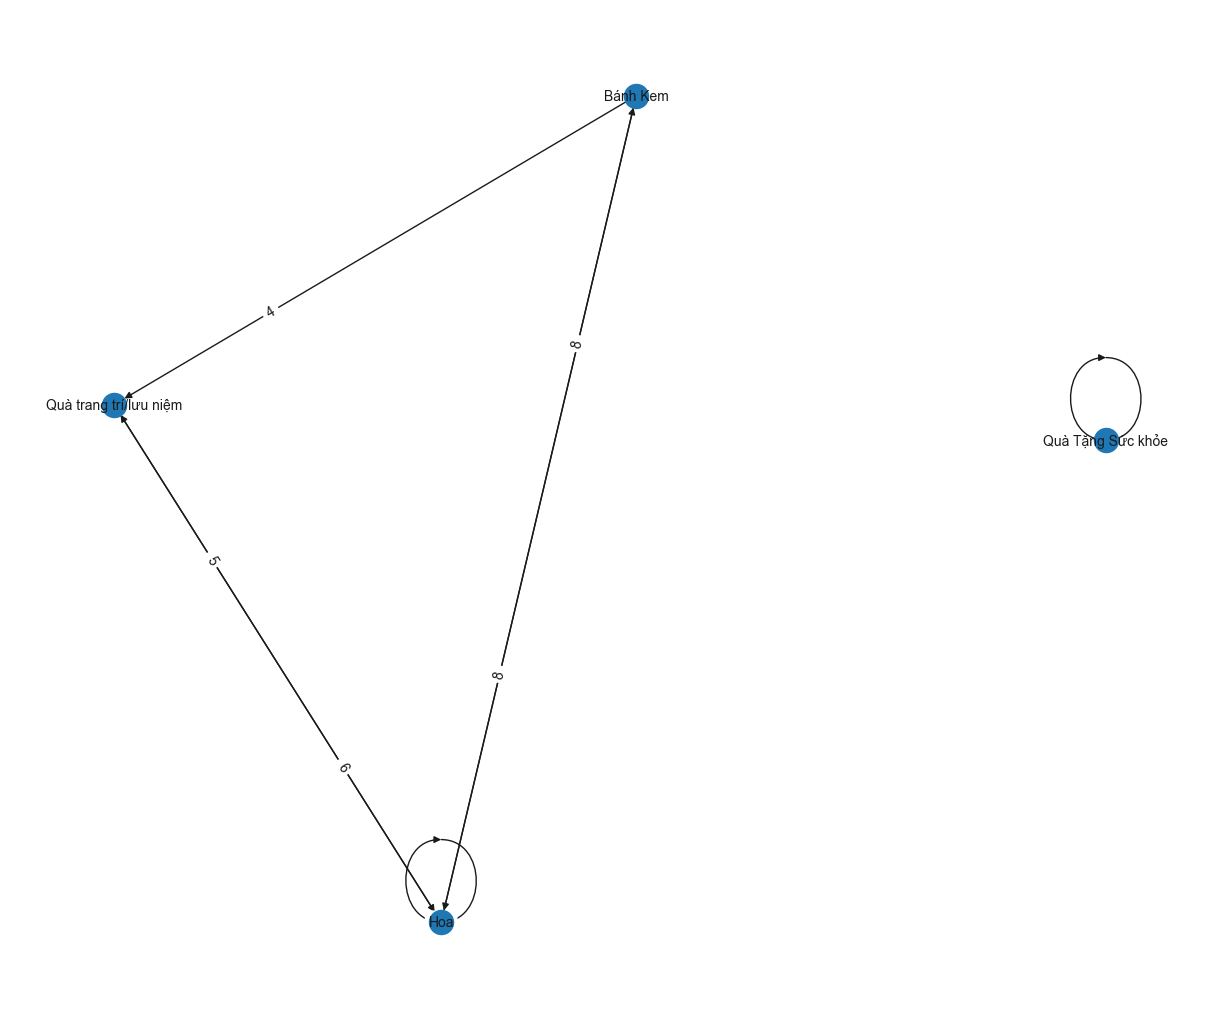

    Support                    Pattern  Length
0       294                      [Hoa]       1
1        94                 [Hoa, Hoa]       2
2        37            [Hoa, Hoa, Hoa]       3
3        18       [Hoa, Hoa, Hoa, Hoa]       4
11        8                 [Bánh Kem]       1
4         8  [Hoa, Hoa, Hoa, Hoa, Hoa]       5
18        7   [Quà trang trí/lưu niệm]       1
21        6                 [Trái Cây]       1
24        6                 [Nước hoa]       1
7         4            [Hoa, Bánh Kem]       2


<Figure size 800x400 with 0 Axes>

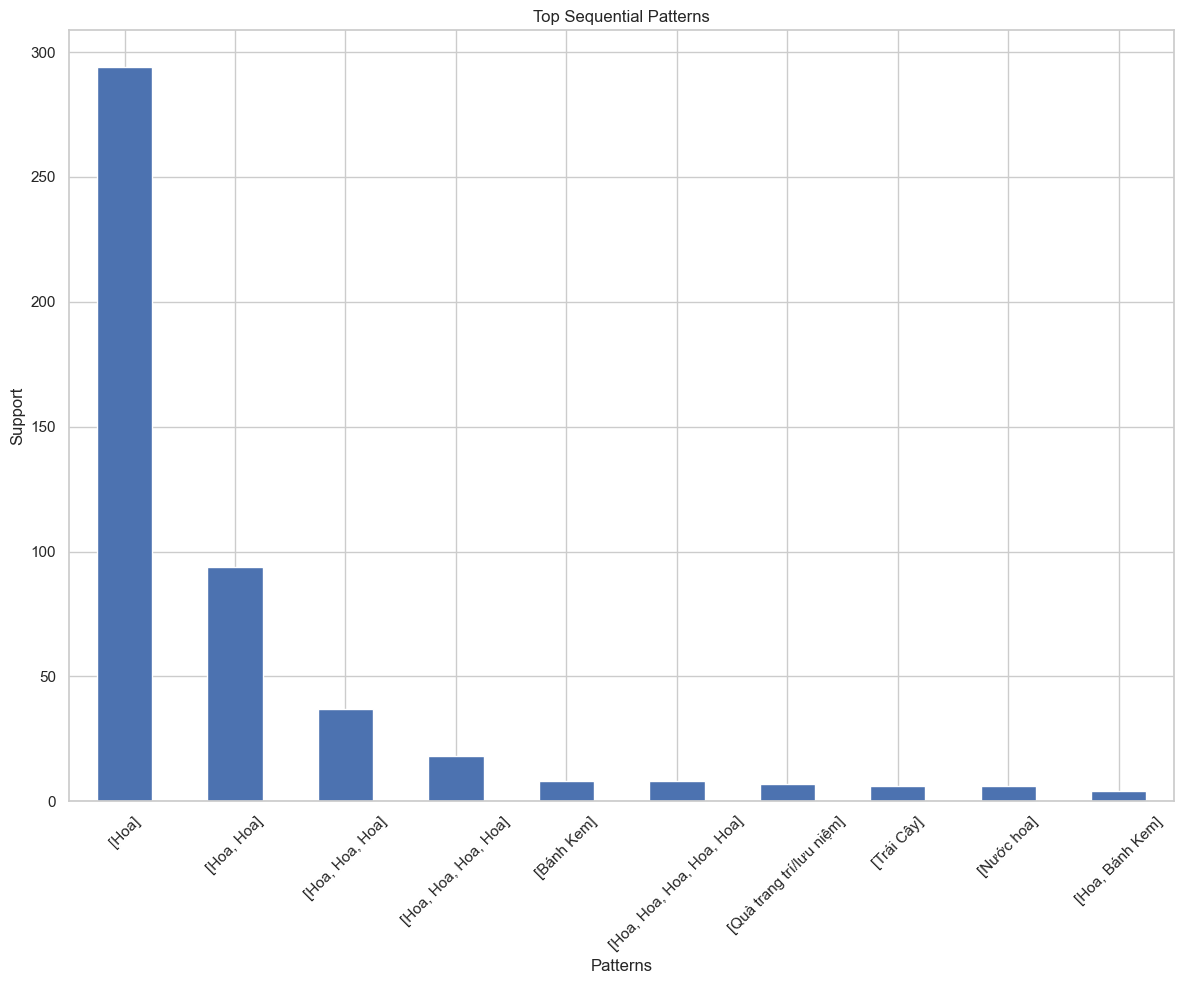

In [1410]:
for i in range(nclusters):
    SPM_plot(data_all[i])

In [1411]:
def Cohort_Analysis_and_CLV(data_1):
    first_purchase = data_1.groupby('customer_id')['create_info_created'].min().reset_index()
    first_purchase.columns = ['customer_id', 'FirstPurchaseDate']
    
    # Get the first purchase month for each customer
    first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
    
    # Merge this information back into the original dataframe
    data_1 = pd.merge(data_1, first_purchase, on='customer_id', how='left')
    data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')
    
    # Create the data needed for cohort analysis
    cohort_data = data_1.groupby(['FirstPurchaseMonth', 'OrderPeriod']) \
                        .agg(n_customers=('customer_id', 'nunique')).reset_index()
    
    # Calculate the period number (i.e., how many periods since the first purchase)
    cohort_data['PeriodNumber'] = (cohort_data['OrderPeriod'] - cohort_data['FirstPurchaseMonth']) \
                                  .apply(attrgetter('n'))
    
    # Pivot the data to create the cohort counts matrix
    cohort_counts = cohort_data.pivot_table(index='FirstPurchaseMonth', columns='PeriodNumber', values='n_customers')

    print(cohort_counts)
    
    # Select the first column and store as cohort_sizes
    cohort_sizes = cohort_counts.iloc[:,0]
    
    # Calculate retention by dividing by the cohort sizes along the row axis
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    
    # Convert to percentage format 
    retention = retention.round(4) * 100
    
    # Create a custom colormap
    # Colors will go from red to white for values below 50% and white to green for values above 50%
    colors = [(1.0, 0.5, 0.5), (0, 0, 1), (0.5, 1.0, 0.5)]  # R -> B -> G
    n_bins = 50  # Number of bins will we divide the data into
    cmap_name = 'custom_cmap'
    
    # Create the colormap
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Now, plot the heatmap again using this custom colormap
    plt.figure(figsize=(18, 14))
    sns.heatmap(retention, annot=True, fmt='.1f', cmap=cm, linewidths=.5)
    plt.title('Cohort Analysis - Retention Rate (%)')
    plt.ylabel('Cohort Month')
    plt.xlabel('Number of Months')
    plt.show()

    # Breaking down the calculation step by step to calculate average_customer_lifespan:
    # Step 1 - Calculate the products of period number and customer count for each cohort period.
    
    #based on above
    cohort_lifespan = cohort_counts.copy()
    for i in cohort_lifespan.columns:
        cohort_lifespan[i] = cohort_lifespan[i] * i
    
    # Step 2 - Sum these products for each cohort.
    cohort_lifetime_months = cohort_lifespan.sum(axis=1)
    
    # Step 3 - Sum the initial customer counts across all cohorts.
    total_customers = cohort_counts[0].sum()
    
    # Step 4 - Compute the average customer lifespan.
    average_customer_lifespan = cohort_lifetime_months.sum() / total_customers
    
    print(f'The average customer lifespan is: {average_customer_lifespan} months')
    
    # 1. Timeframe: Assuming the data covers the full timeframe of interest
    #    If you want to focus on a specific period adjust the dataframe accordingly.
    
    # 2. Average purchase value
    average_purchase_value = data_1['s_grand_total'].sum() / data_1['s_grand_total'].count()
    
    # 3. Average purchase frequency rate
    average_purchase_frequency = data_1['s_grand_total'].count() / data_1['customer_id'].nunique()
    
    # 4. Customer value
    customer_value = average_purchase_value * average_purchase_frequency
    
    # 5. Average customer lifespan: You'd typically need historical data to calculate this.
    # Here, we will need to figure out the repeat purchase rate or use industry benchmarks if we lack historical data.
    # Assuming you somehow computed this value:
    
    # average_customer_lifespan = # calculated
    # 6. Calculate CLV
    CLV = customer_value * average_customer_lifespan
    print('Customer lifetime value of this segment is: ', CLV)

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


PeriodNumber           0    1    2    3    4    5    6    7    8    9   ...  \
FirstPurchaseMonth                                                      ...   
2020-05               2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-06               2.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  ...   
2020-07               4.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  ...   
2020-10               1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2021-08               1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2021-10              13.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2021-11               9.0  1.0  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...   
2021-12              23.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  ...   
2022-01              11.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2022-02              14.0  1.0  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  ...   
2022-03              28.0  1.0  2.0  1.0  NaN  NaN  

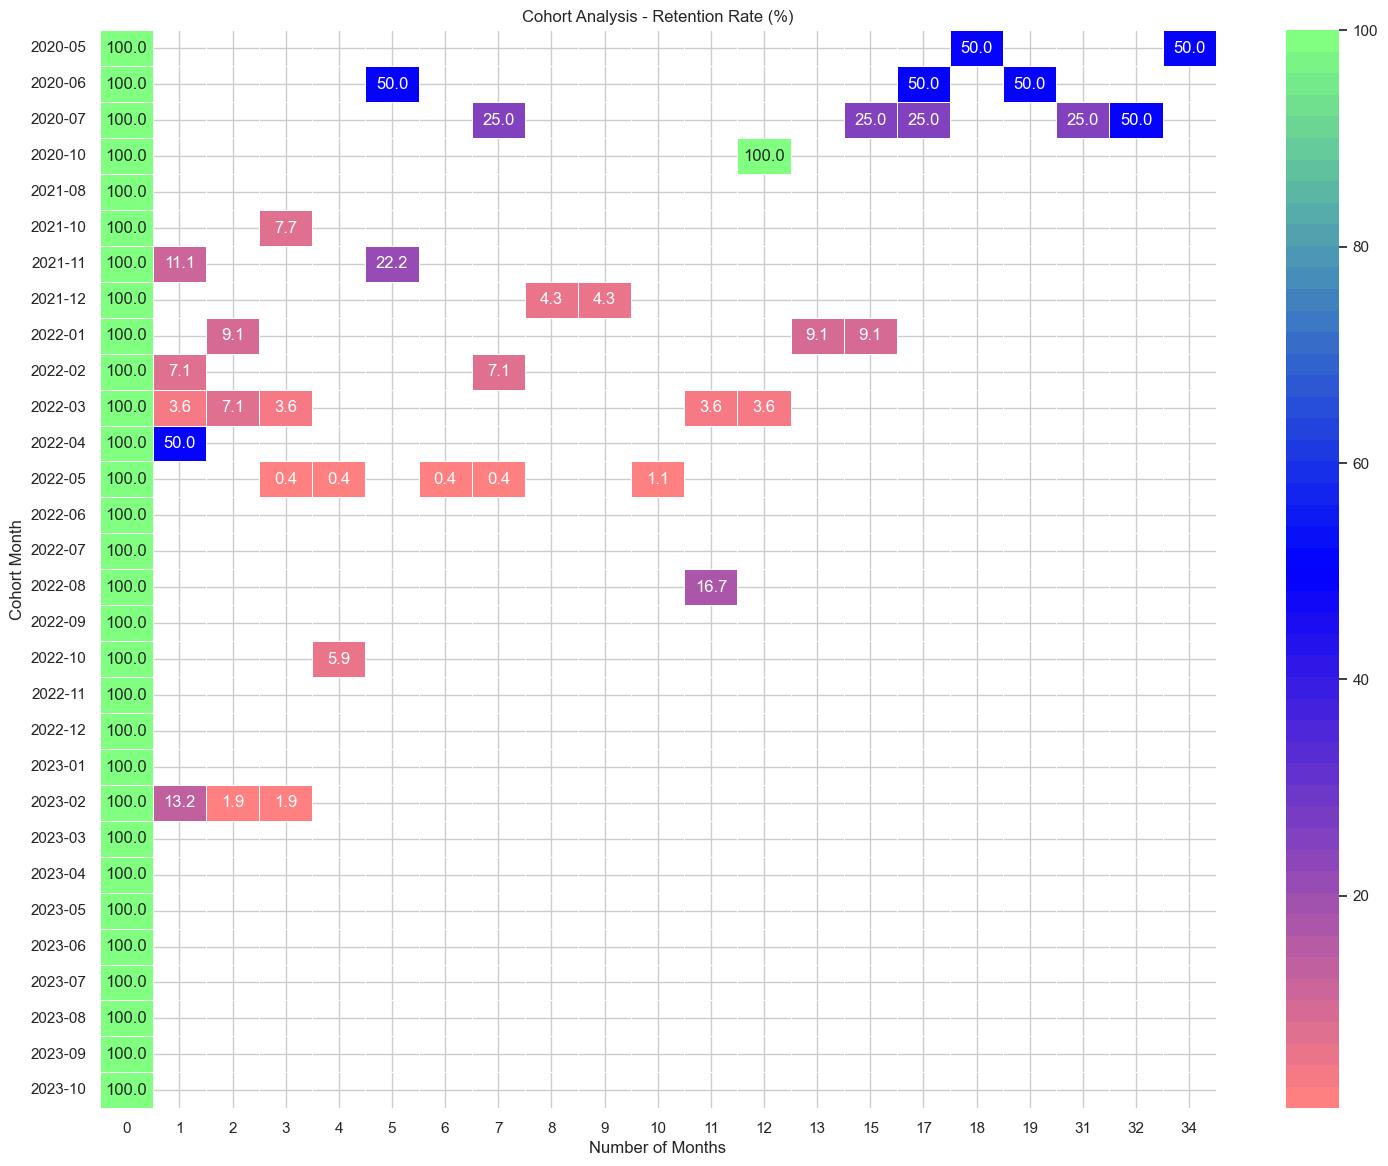

The average customer lifespan is: 0.38935574229691877 months
Customer lifetime value of this segment is:  42849.68534603383
PeriodNumber          0    1    2    3    4    5    6    7    8    9    10  \
FirstPurchaseMonth                                                           
2020-01              2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2020-02             23.0  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  1.0   
2020-03             28.0  NaN  NaN  NaN  NaN  NaN  1.0  2.0  NaN  NaN  NaN   
2020-04             16.0  NaN  NaN  2.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2020-05             89.0  1.0  3.0  2.0  3.0  2.0  NaN  NaN  1.0  1.0  NaN   
2020-06             89.0  2.0  NaN  1.0  1.0  1.0  NaN  NaN  NaN  1.0  1.0   
2020-07             70.0  2.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2020-08             17.0  NaN  NaN  NaN  1.0  1.0  1.0  1.0  NaN  NaN  NaN   
2020-09             22.0  NaN  2.0  2.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN   
2020-10           

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


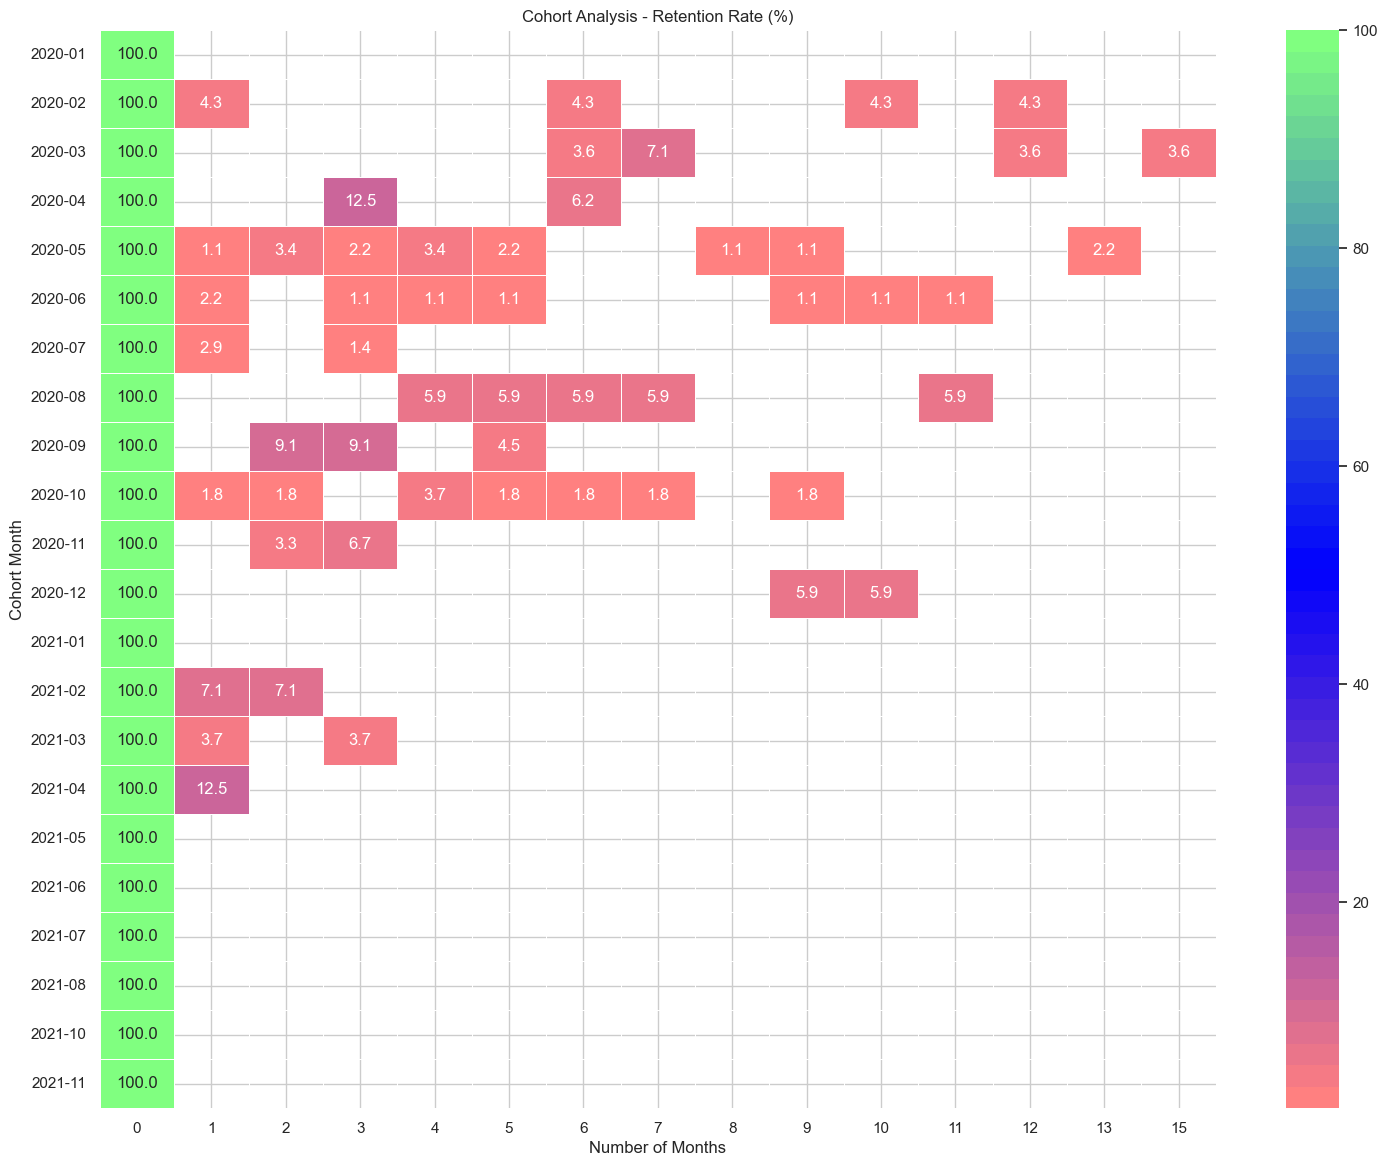

The average customer lifespan is: 0.5863874345549738 months
Customer lifetime value of this segment is:  305572.81039445195
PeriodNumber           0    1    2    3    4    5    6    7    8    9   ...  \
FirstPurchaseMonth                                                      ...   
2020-01               1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-02               1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-03               2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-04               1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-05               2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-06               2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-07               2.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-08               3.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-09               5.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-10

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


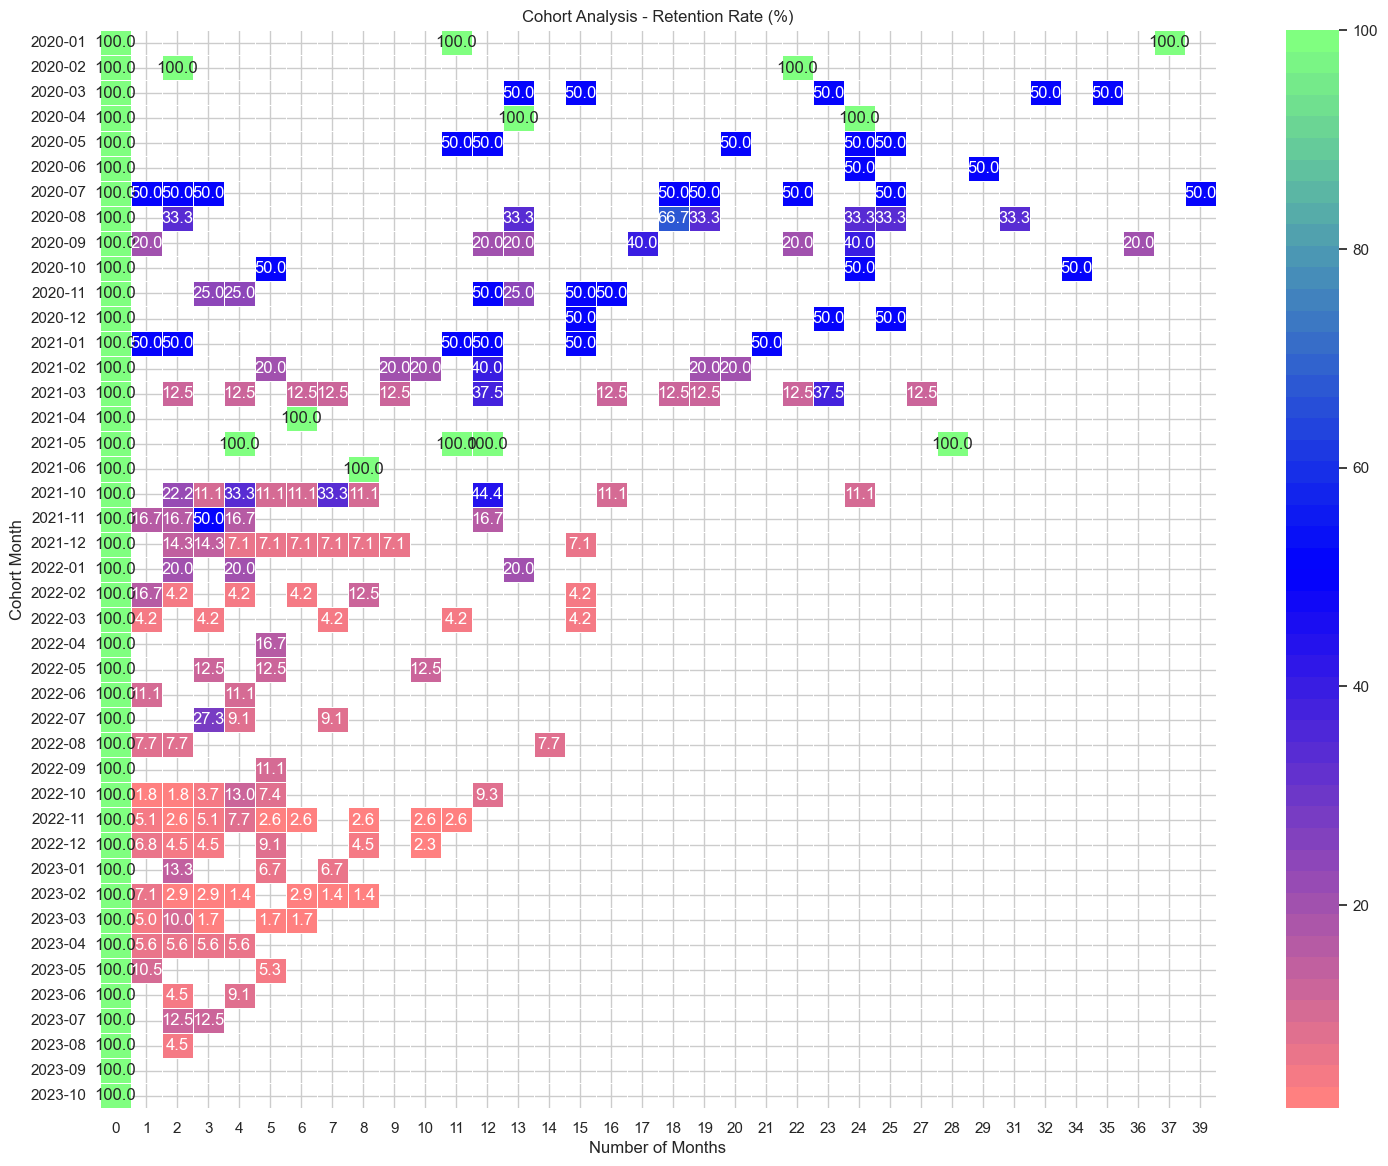

The average customer lifespan is: 3.402674591381872 months
Customer lifetime value of this segment is:  3251269.8248732137
PeriodNumber         0    1    2    3    4    5    6    7    8    9   ...  \
FirstPurchaseMonth                                                    ...   
2020-02             3.0  NaN  NaN  2.0  1.0  2.0  NaN  1.0  3.0  1.0  ...   
2020-03             1.0  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN  ...   
2020-05             3.0  NaN  1.0  NaN  1.0  1.0  1.0  2.0  NaN  NaN  ...   
2020-06             4.0  1.0  1.0  NaN  2.0  NaN  2.0  NaN  2.0  2.0  ...   
2020-07             1.0  NaN  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-08             2.0  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   
2020-09             1.0  NaN  1.0  1.0  NaN  1.0  1.0  1.0  1.0  NaN  ...   
2020-10             5.0  3.0  2.0  2.0  1.0  3.0  NaN  1.0  1.0  NaN  ...   
2020-11             3.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN  1.0  NaN  ...   
2020-12             2.0  NaN  

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


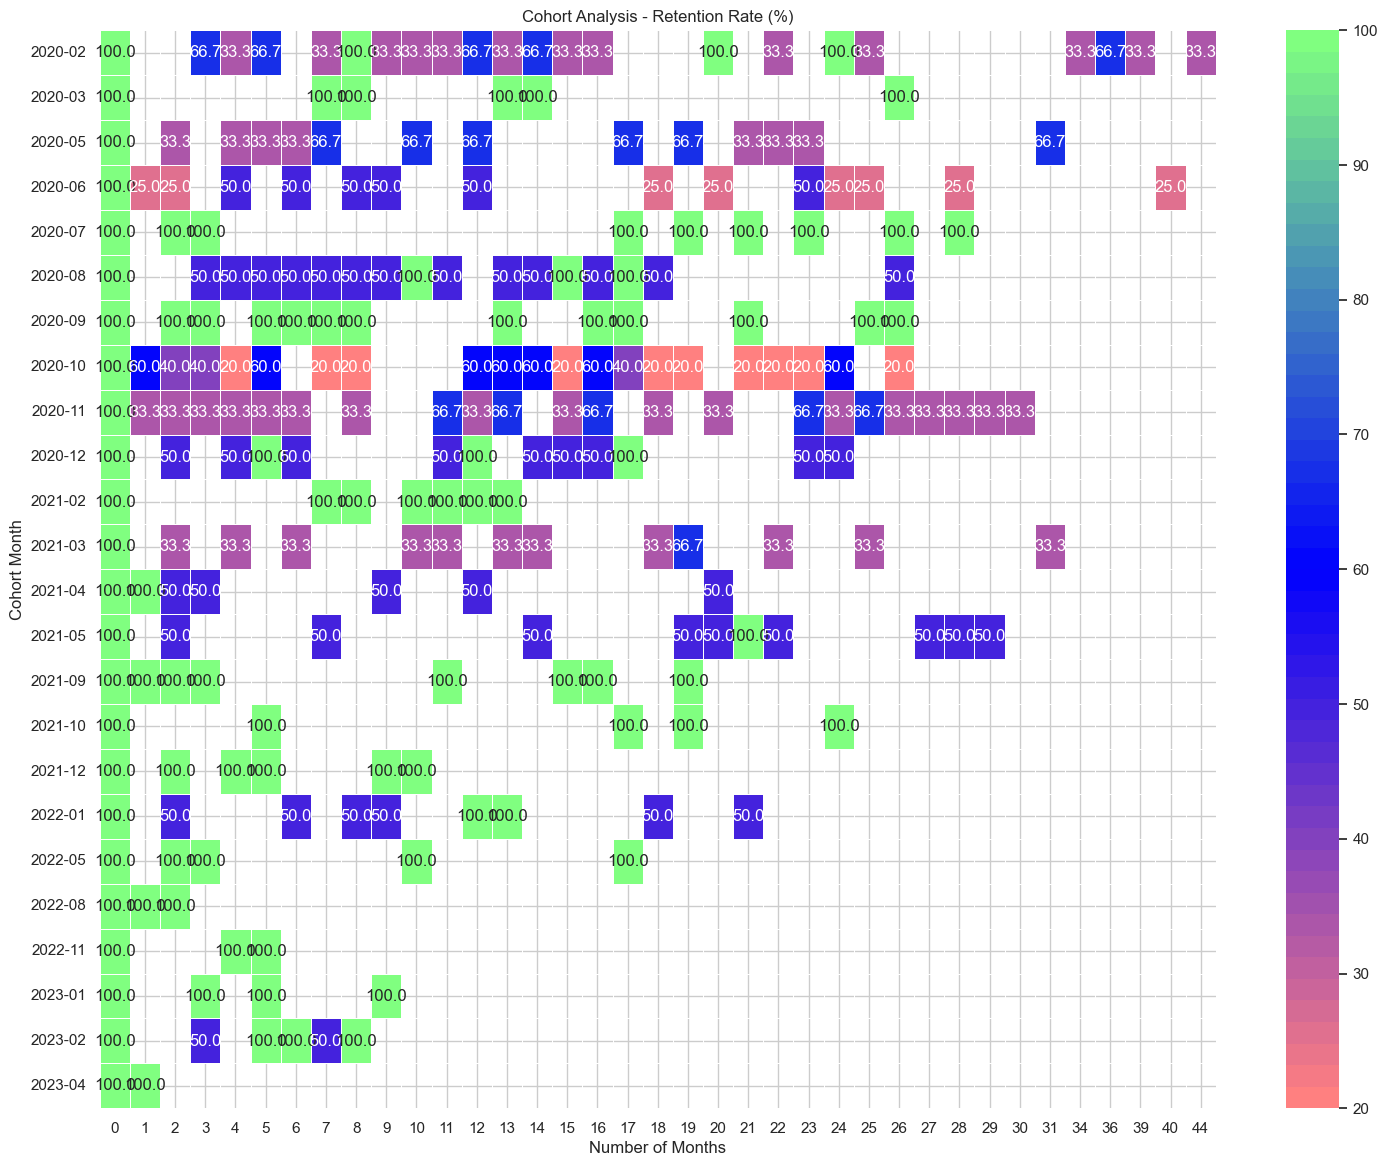

The average customer lifespan is: 81.33333333333333 months
Customer lifetime value of this segment is:  726086049.0962963
PeriodNumber          0    1    2    3    4    5    6    7    8    9   ...  \
FirstPurchaseMonth                                                     ...   
2020-02              6.0  NaN  NaN  1.0  NaN  NaN  1.0  NaN  NaN  NaN  ...   
2020-03              6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-04              4.0  NaN  NaN  1.0  NaN  NaN  1.0  1.0  1.0  NaN  ...   
2020-05              4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-06              3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-07              5.0  1.0  NaN  3.0  NaN  NaN  NaN  NaN  1.0  NaN  ...   
2020-08              3.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  1.0  NaN  ...   
2020-09              5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
2020-10             14.0  NaN  NaN  1.0  1.0  2.0  NaN  NaN  1.0  NaN  ...   
2020-11             

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  first_purchase['FirstPurchaseMonth'] = first_purchase['FirstPurchaseDate'].dt.to_period('M')
/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/3211292781.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_1['OrderPeriod'] = data_1['create_info_created'].dt.to_period('M')


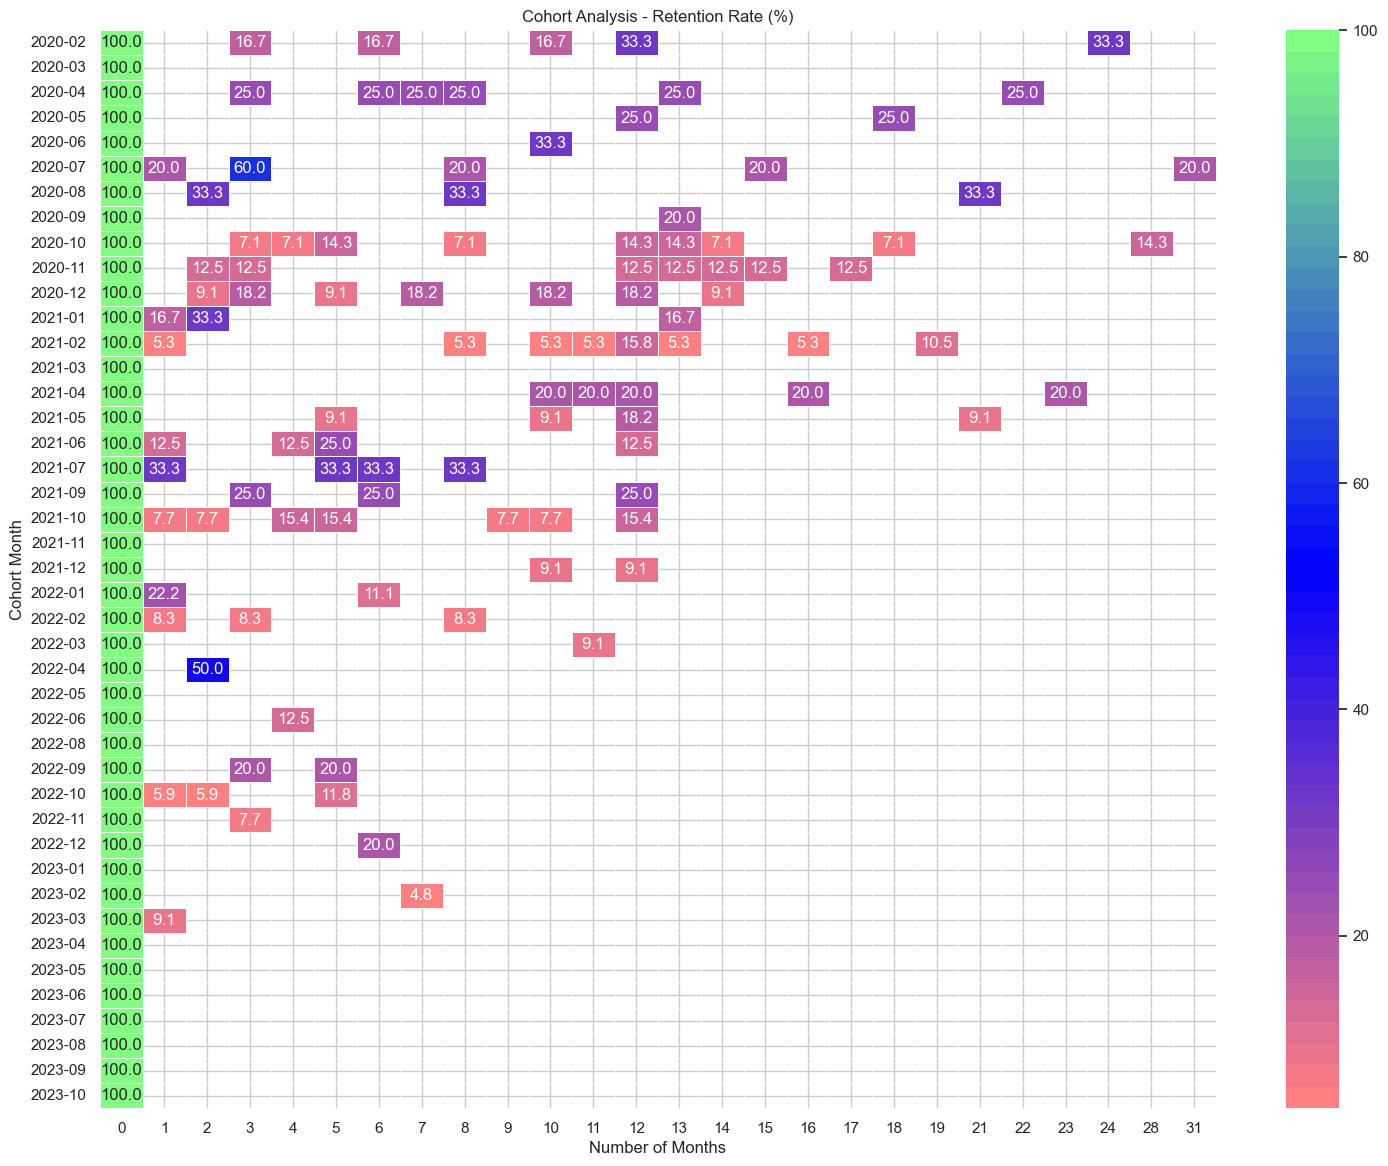

The average customer lifespan is: 3.5217391304347827 months
Customer lifetime value of this segment is:  6723675.627059142


In [1412]:
for i in range(nclusters):
    Cohort_Analysis_and_CLV(data_all[i])

In [1413]:
def gift_vs_occ(data_bills):
    merged_data = data_bills.merge(
        data_occasions, left_on='to_user_occasion_id', right_on='occasion_id', how='left'
    ).merge(
        data_relationships, left_on='to_user_relationship_id', right_on='relationship_id', how='left'
    )
    
    merged_data['month'] = merged_data['to_user_date'].dt.month
    
    analysis = merged_data.groupby(['occasion_name', 'relationship_name', 'month']).size().reset_index(name='gift_count')
    
    gifts_by_occasion = analysis.groupby('occasion_name')['gift_count'].sum().reset_index()
    gifts_by_occasion = gifts_by_occasion.sort_values('gift_count', ascending=False)
    
    plt.figure(figsize=(15, 7))
    sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')
    plt.xticks(rotation=90) 
    plt.title('Number of Gifts by Occasion')
    plt.xlabel('Occasion')
    plt.ylabel('Number of Gifts')
    plt.tight_layout() 
    plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1256790118.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')


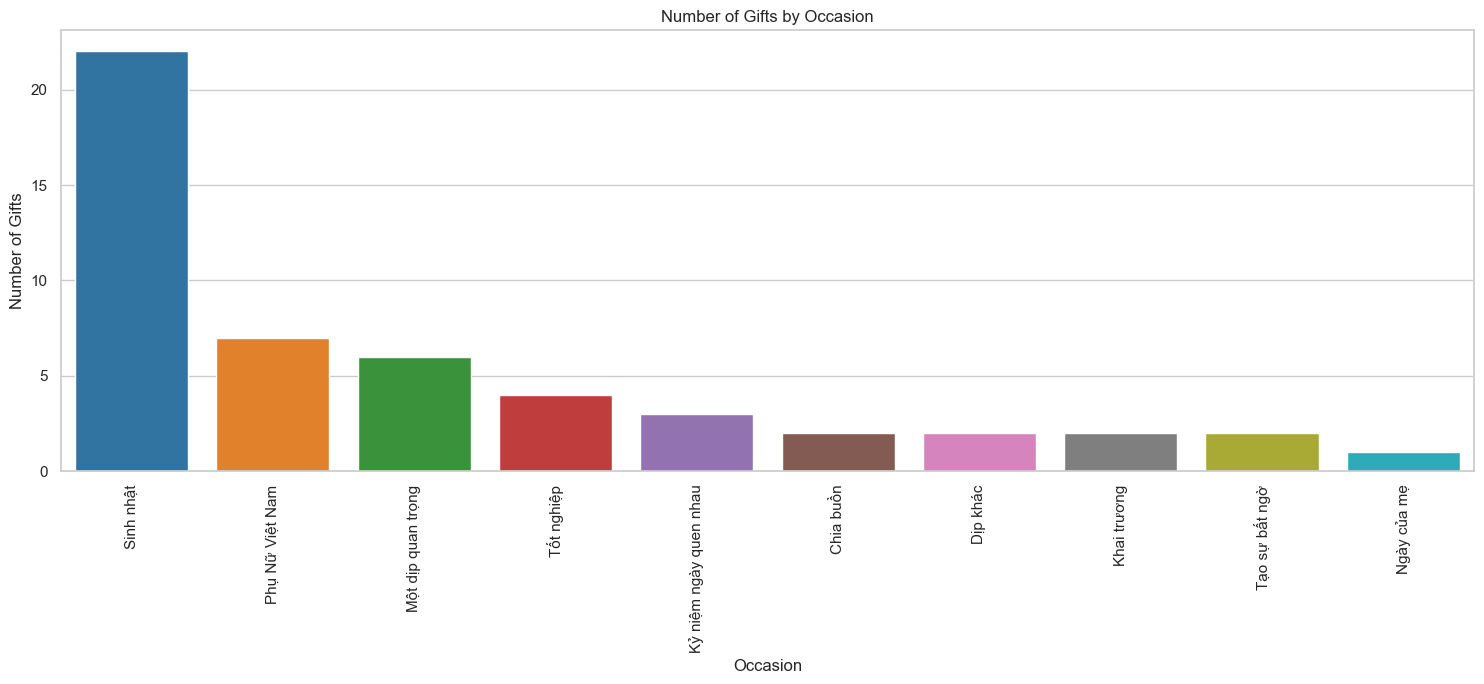

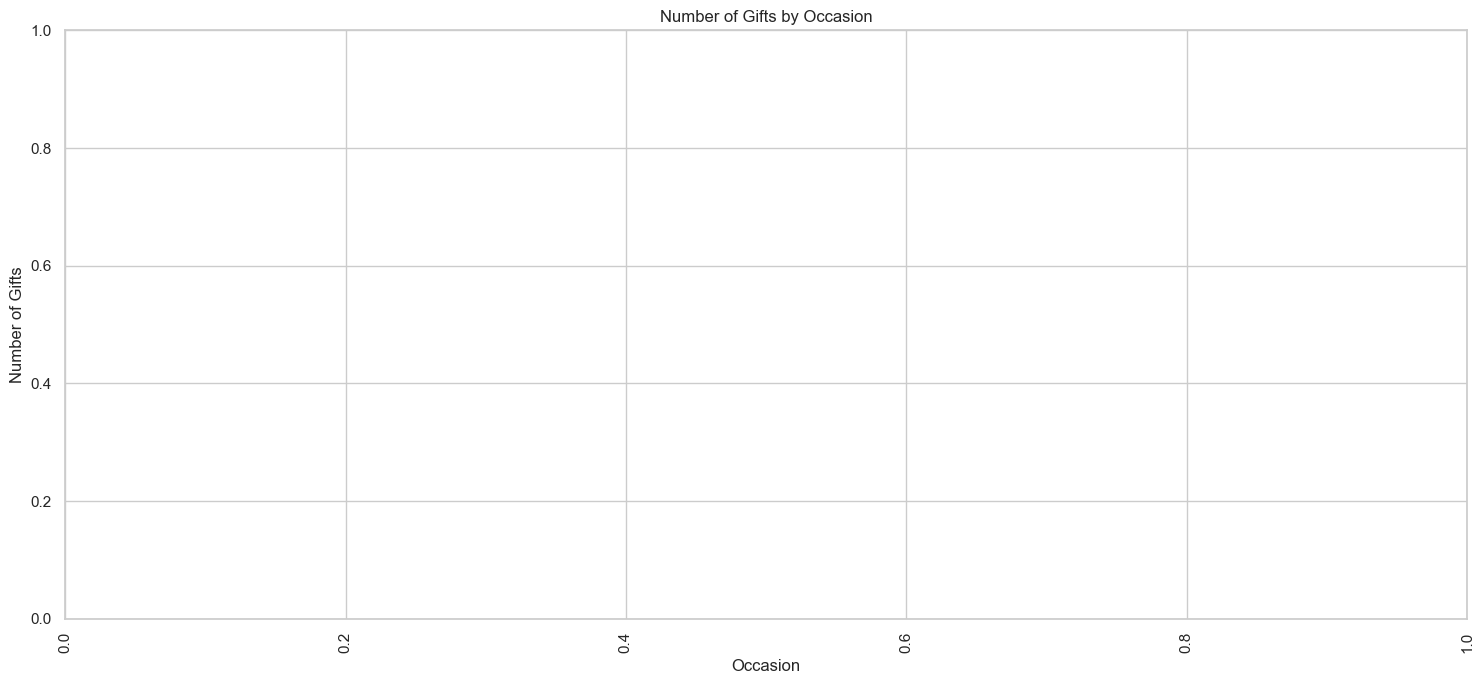

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1256790118.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')


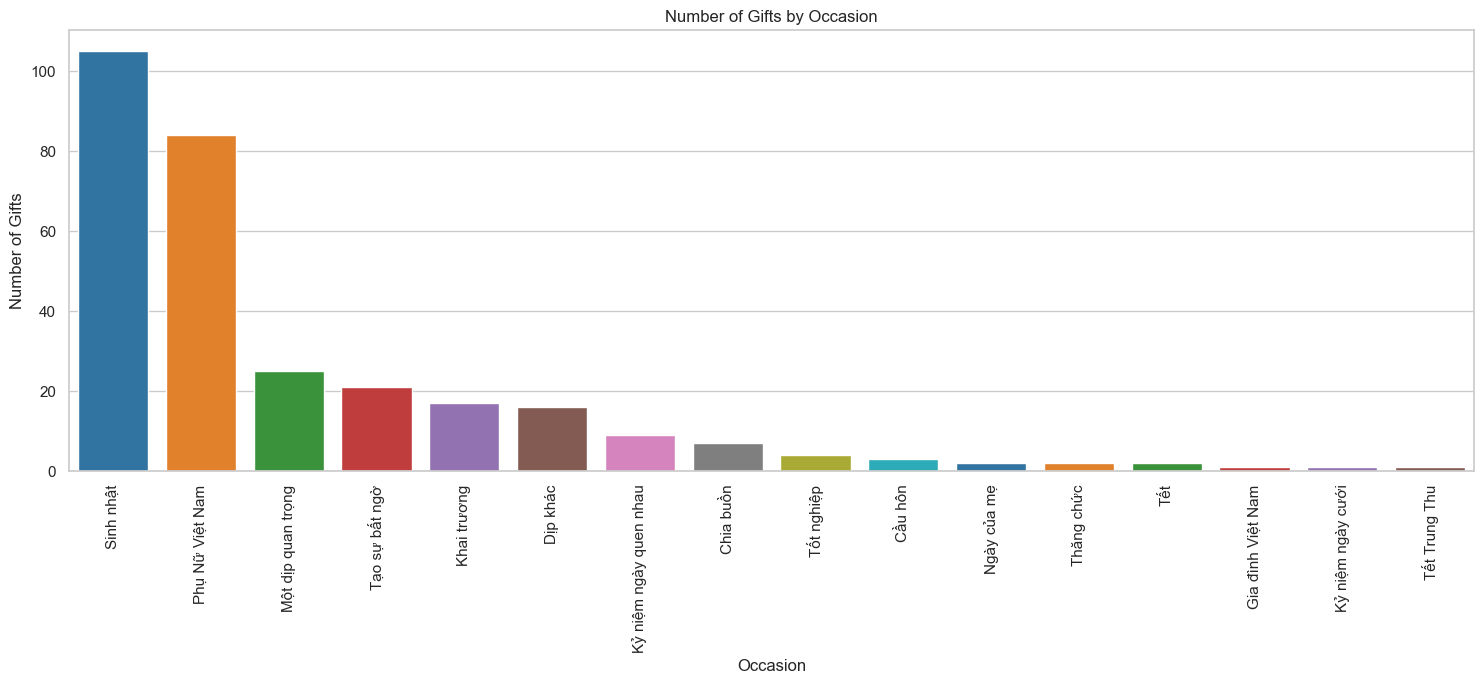

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1256790118.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')


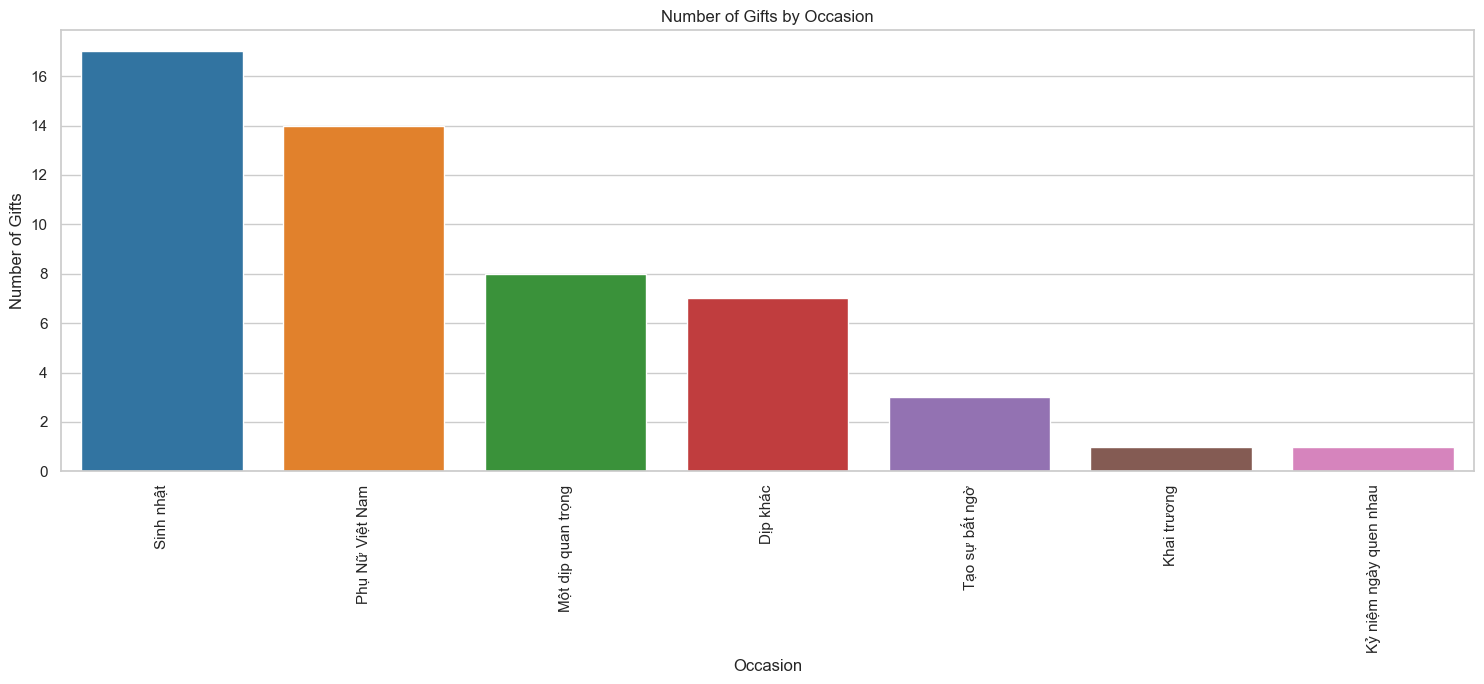

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1256790118.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='occasion_name', y='gift_count', data=gifts_by_occasion, palette='tab10')


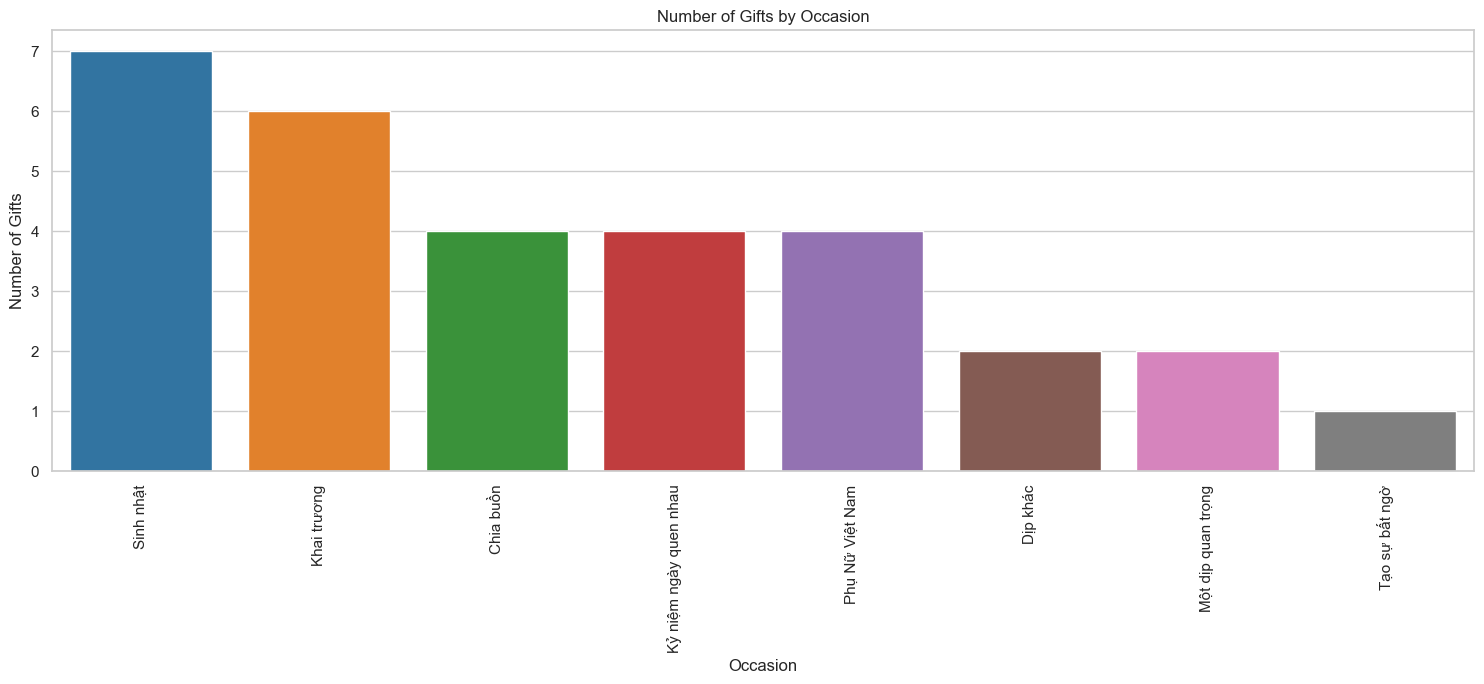

In [1414]:
for i in range(nclusters):
    gift_vs_occ(data_all[i])

In [1415]:
def gift_vs_rela(data_bills):
    merged_data = data_bills.merge(
        data_occasions, left_on='to_user_occasion_id', right_on='occasion_id', how='left'
    ).merge(
        data_relationships, left_on='to_user_relationship_id', right_on='relationship_id', how='left'
    )
    
    merged_data['month'] = merged_data['to_user_date'].dt.month
    
    analysis = merged_data.groupby(['occasion_name', 'relationship_name', 'month']).size().reset_index(name='gift_count')

    
    gifts_by_relationship = analysis.groupby('relationship_name')['gift_count'].sum().reset_index()
    gifts_by_relationship = gifts_by_relationship.sort_values('gift_count', ascending=False)
    
    plt.figure(figsize=(15, 7))
    sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')
    plt.xticks(rotation=90)
    plt.title('Number of Gifts by Relationship')
    plt.xlabel('Relationship')
    plt.ylabel('Number of Gifts')
    plt.tight_layout() 
    plt.show()

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1358619371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')


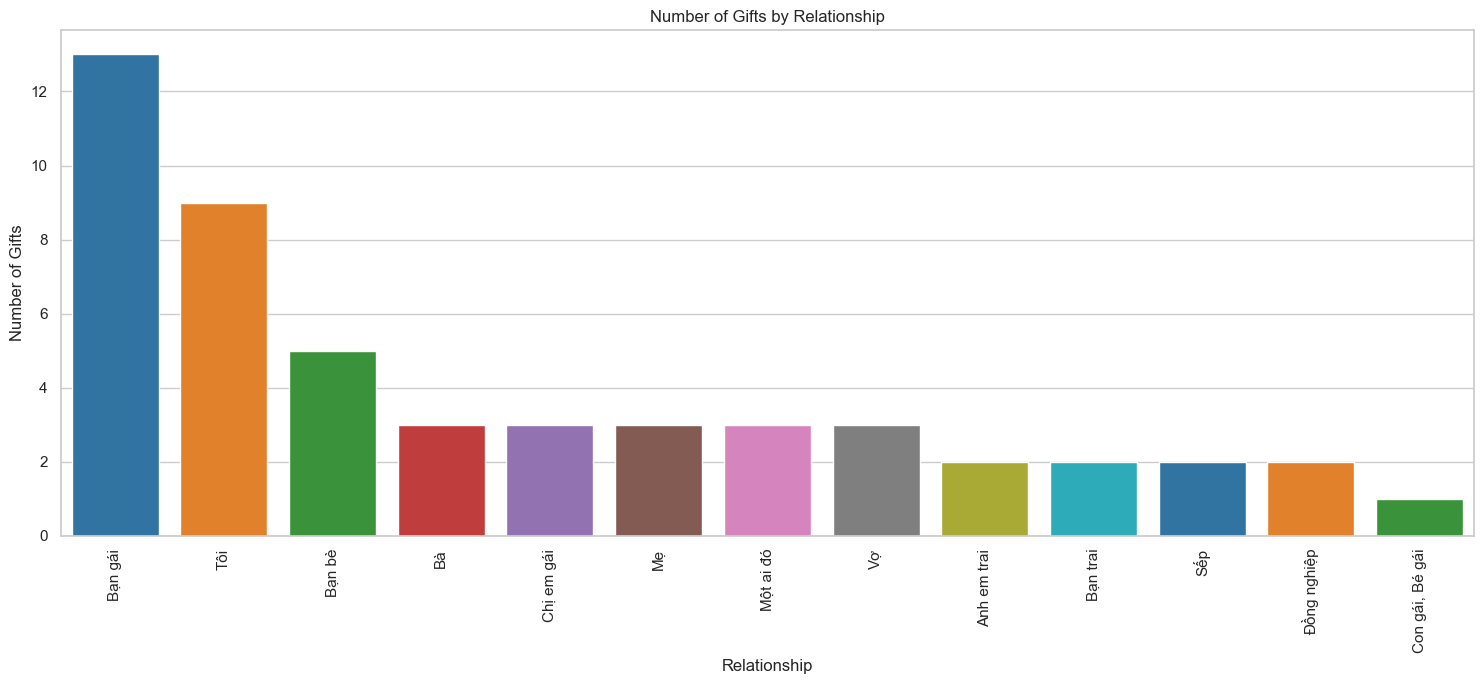

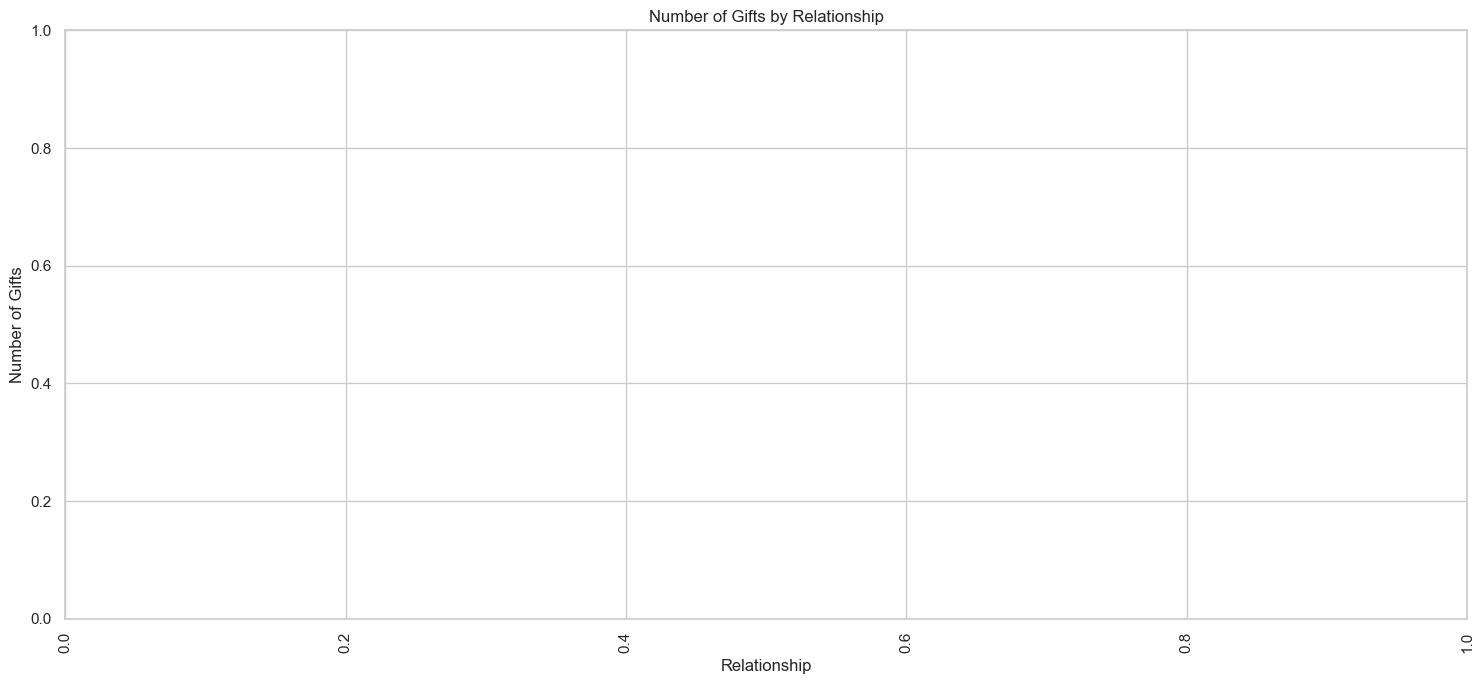

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1358619371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')


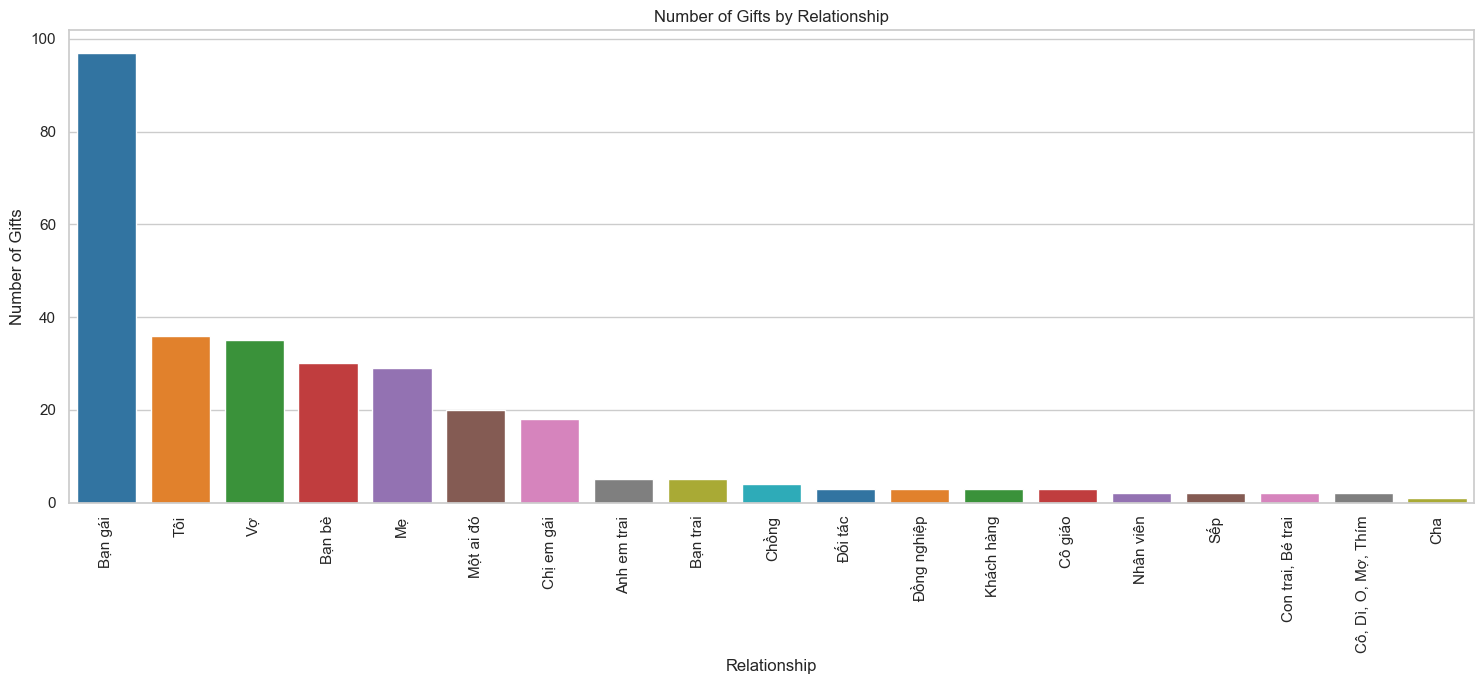

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1358619371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')


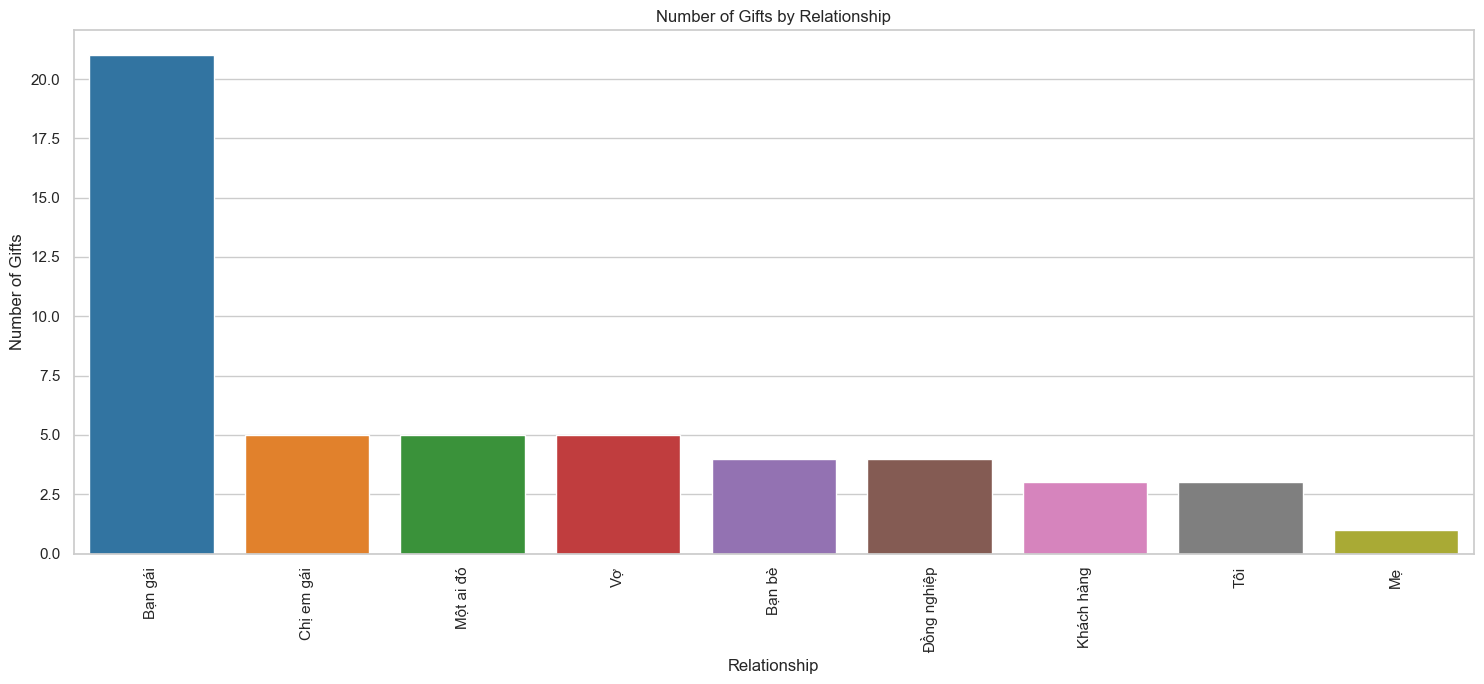

/var/folders/88/l6n2p6zj7k511lqxlc10jcvh0000gn/T/ipykernel_48989/1358619371.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='relationship_name', y='gift_count', data=gifts_by_relationship, palette='tab10')


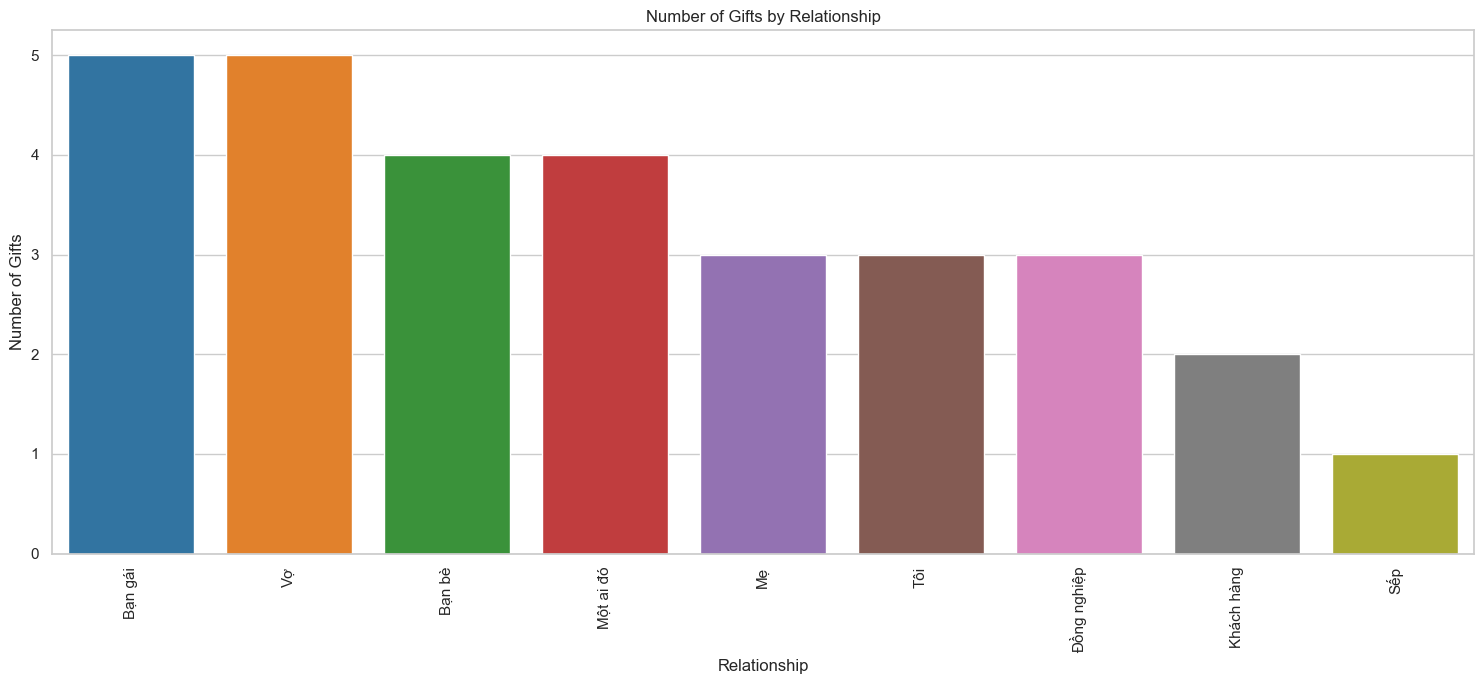

In [1416]:
for i in range(nclusters):
    gift_vs_rela(data_all[i])

In [1417]:
def Survival(data_3):
    data_3 = data_3.sort_values(['customer_id', 'create_info_created'])
    data_3['create_info_created'] = pd.to_datetime(data_3['create_info_created'])
    
    # Tạo cột 'next_purchase' thể hiện thời gian cho lần mua tiếp theo
    data_3['next_purchase'] = data_3.groupby('customer_id')['create_info_created'].shift(-1)
    
    # Tính 'duration' là khoảng thời gian giữa lần mua này và lần mua tiếp theo
    data_3['duration'] = (data_3['next_purchase'] - data_3['create_info_created']).dt.days
    
    # Tạo cột 'event_observed' mà trong đó 1 nếu có lần mua tiếp theo, còn lại là 0
    data_3['event_observed'] = 1
    data_3['event_observed'] = data_3['event_observed'].where(data_3['next_purchase'].notnull(), 0)
    
    data_for_survival = data_3[['_id', 'create_info_created', 'next_purchase', 'duration', 'event_observed']].copy()
    
    # Loại bỏ các dòng có giá trị NaN trong cột 'duration' hoặc 'next_purchase'
    data_for_survival.dropna(subset=['duration', 'next_purchase'], inplace=True)
    
    from lifelines import KaplanMeierFitter
    
    # KaplanMeierFitter
    kmf = KaplanMeierFitter()
    T = data_for_survival['duration']
    E = data_for_survival['event_observed']
    
    kmf.fit(T, event_observed=E)
    
    kmf.plot_survival_function()

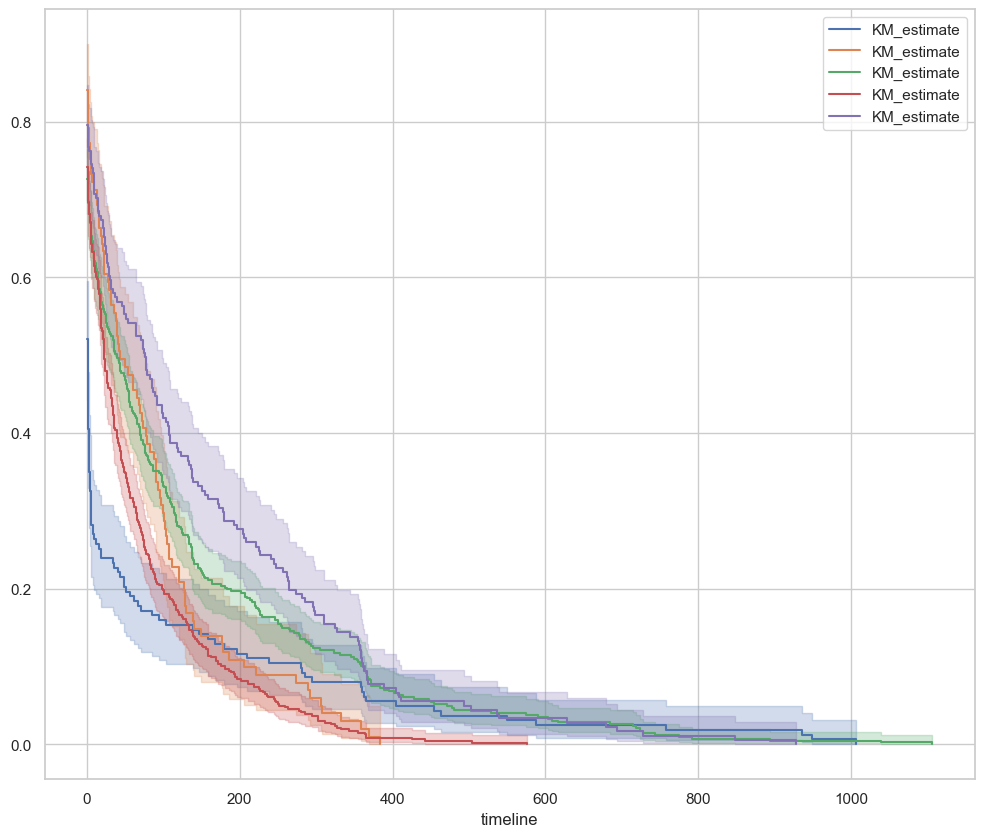

In [1418]:
for i in range(nclusters):
    Survival(data_all[i])

In [1419]:
data_all[3]

_id               customer_id  \
0    5e44ea8df8063662168b4569  5e44ea8bf8063662168b4567   
1    60214cfbc48fb25eac6e993b  5e44ea8bf8063662168b4567   
2    60a57ae1568f171e70519521  5e44ea8bf8063662168b4567   
3    5f7870831b83be373050d456  5e44ea8bf8063662168b4567   
4    615d42af7b6beb0fdb13ceb1  5e44ea8bf8063662168b4567   
..                        ...                       ...   
505  644217841c20eff33d007aa7  633cc3d4b0e8d989ed04a8b0   
506  64421b764c8ddf925b005a54  633cc3d4b0e8d989ed04a8b0   
507  64593e813c338575e316135e  633cc3d4b0e8d989ed04a8b0   
508  6459b1b7edee069e350dc12d  633cc3d4b0e8d989ed04a8b0   
509  646f2e70a2877676a90b07df  633cc3d4b0e8d989ed04a8b0   

                   product_id country_id  s_grand_total  s_discount_money  \
0    6066c157066c9a03055f2b10         VN      1330000.0               0.0   
1    6066c157066c9a03055f2b10         VN      1100000.0               0.0   
2    6066c157066c9a03055f2b10         VN      1010000.0               0.0   
3    6066c157066c9a03055f2b10         VN       972300.0               0.0   
4    6066c157066c9a03055f2b10         VN      1190000.0               0.0   
..                        ...        ...            ...               ...   
505  6066c157066c9a03055f2b10         VN       168500.0           30000.0   
506  6066c157066c9a03055f2b10         VN       248000.0               0.0   
507  6066c157066c9a03055f2b10         VN       207000.0           30000.0   
508  6066c157066c9a03055f2b10         VN       345000.0           30000.0   
509  6066c157066c9a03055f2b10         VN       208000.0           10000.0   

     s_commission  s_shipfee       to_user_province_id  \
0        260000.0    30000.0  5016fd6b7f8b9ac842000000   
1        128280.0   120000.0  5016fd6b7f8b9ac842000000   
2        128400.0    30000.0  5016fd6b7f8b9ac842000000   
3         94700.0   120000.0  5016fd6b7f8b9ac842000000   
4        176000.0   130000.0  5016fd6b7f8b9ac842000000   
..            ...        ...                       ...   
505      -22575.0    50000.0  5016fd6b7f8b9ac842000000   
506        9900.0    50000.0  5016fd6b7f8b9ac842000000   
507      -20650.0    50000.0  5016fd6b7f8b9ac842000000   
508      -13750.0    50000.0  5016fd6b7f8b9ac842000000   
509       -1600.0    50000.0  5016fd6b7f8b9ac842000000   

      to_user_relationship_id       to_user_occasion_id  \
0                         NaN                         0   
1                         NaN  62374e382511770c643d9a5a   
2                         NaN  623b0503de0bb45dd62792aa   
3                         NaN                       NaN   
4                         NaN  623b0503de0bb45dd62792aa   
..                        ...                       ...   
505  62374b9f9279506d3f2cbe85  62b445e29612dcb691028846   
506                       NaN                         0   
507                       NaN                         0   
508                       NaN                         0   
509                       NaN                         0   

          to_user_relative_id              to_user_date  \
0    62bc653256bcb11219004e5d 2020-02-13 12:00:00+00:00   
1    62bc652156bcb11219004e59 2021-02-14 05:00:00+00:00   
2    62bc652156bcb11219004e59 2021-05-20 01:00:00+00:00   
3    62bc652156bcb11219004e59 2020-10-06 09:00:00+00:00   
4    62bc652156bcb11219004e59 2021-10-06 09:00:00+00:00   
..                        ...                       ...   
505  634dc1997eaba06346049ee2 2023-04-27 01:00:00+00:00   
506  634dc1997eaba06346049ee2 2023-04-23 01:00:00+00:00   
507  634dc1997eaba06346049ee2 2023-05-09 05:00:00+00:00   
508  634dc1997eaba06346049ee2 2023-05-20 01:00:00+00:00   
509  634dc1997eaba06346049ee2 2023-05-25 09:00:00+00:00   

                 create_info_created     to_province  s_profit shipfee_group  
0   2020-02-13 06:19:55.920000+00:00  TP Hồ Chí Minh  260000.0           > 0  
1   2021-02-10 13:13:07.750000+00:00  TP Hồ Chí Minh  128280.0           > 0  
2   2021-05-20 01:24:24.702000+00:00  TP

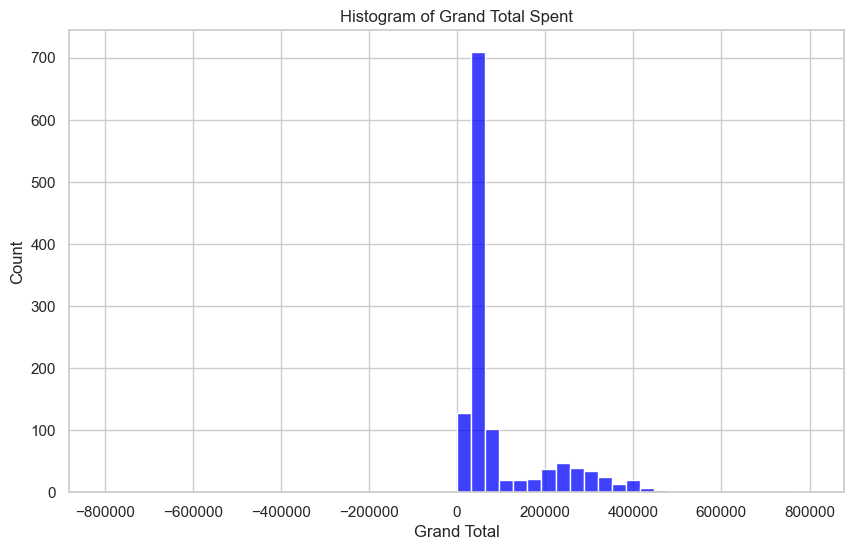

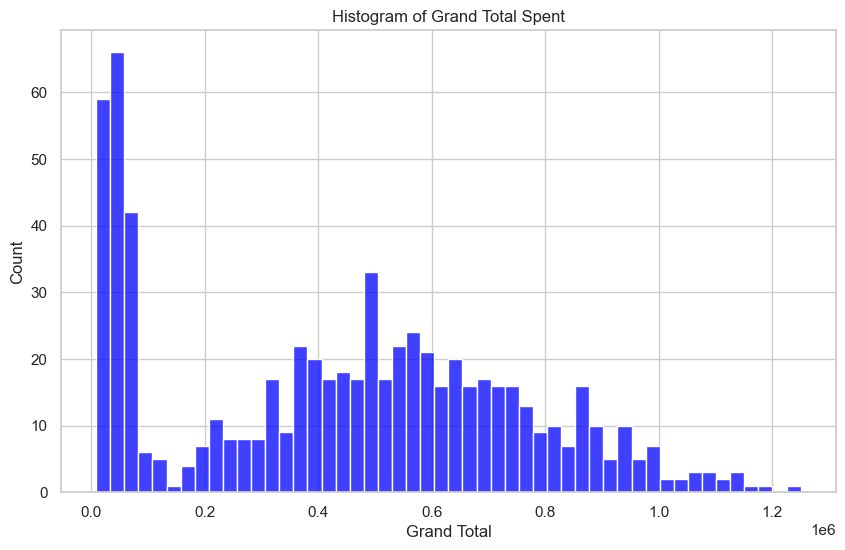

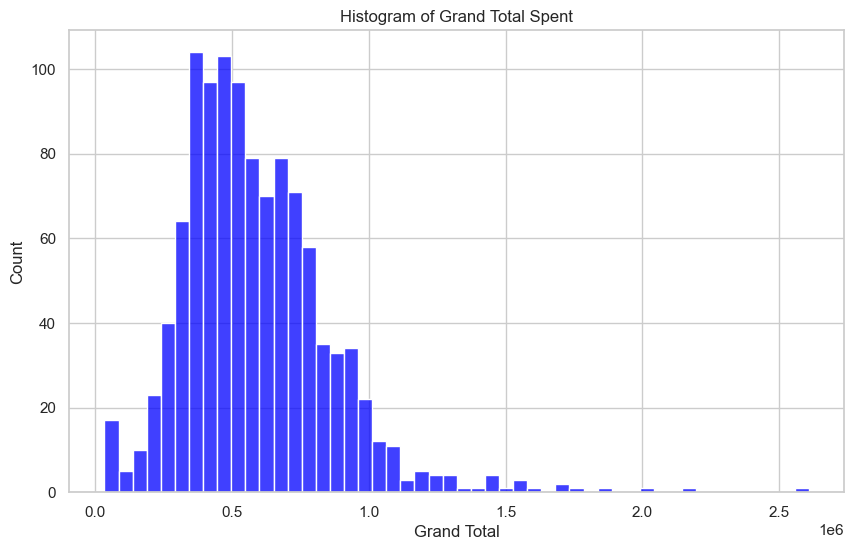

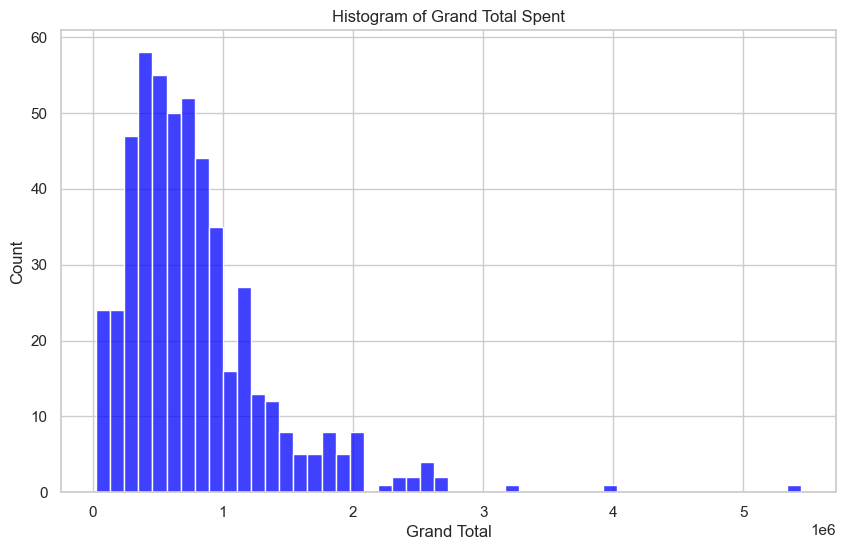

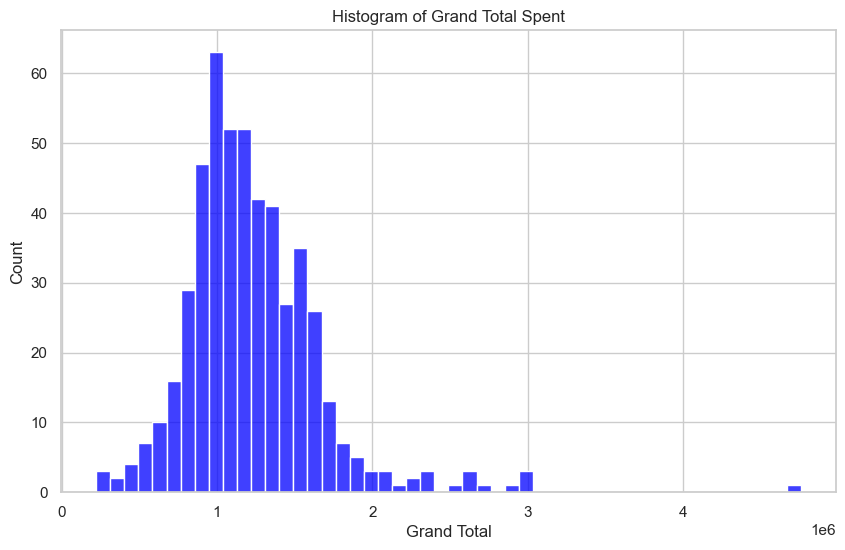

In [1424]:
def hist_grand_total(data_bills):
    plt.figure(figsize=(10, 6))
    sns.histplot(data_bills['s_grand_total'].dropna(), bins=50, kde=False, color='blue')  # includes dropna() to handle NaNs
    plt.title('Histogram of Grand Total Spent')
    plt.xlabel('Grand Total')
    plt.ylabel('Count')
    plt.show()

for i in range(nclusters):
    hist_grand_total(data_all[i])

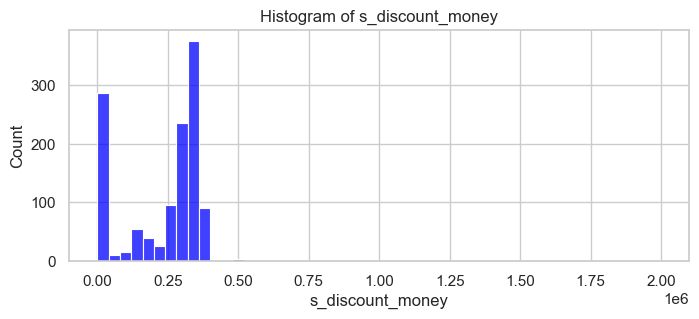

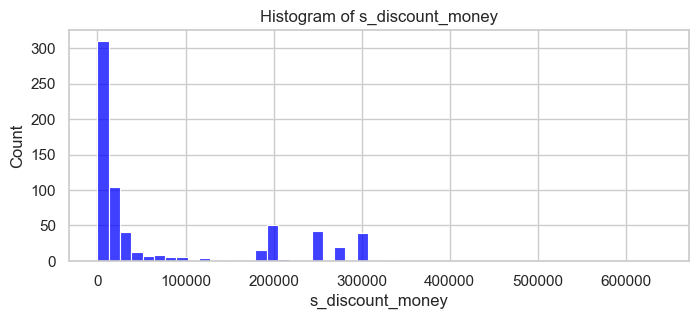

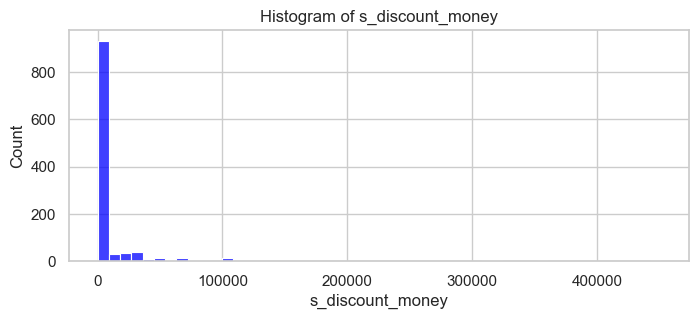

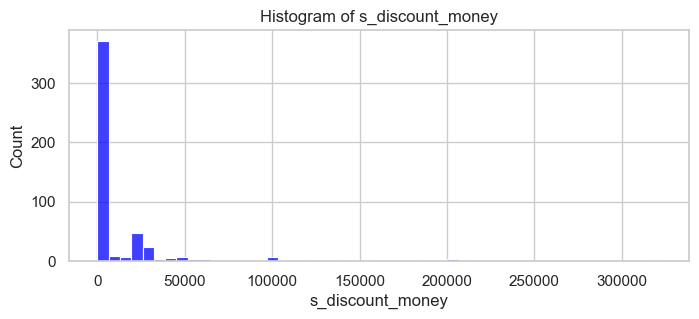

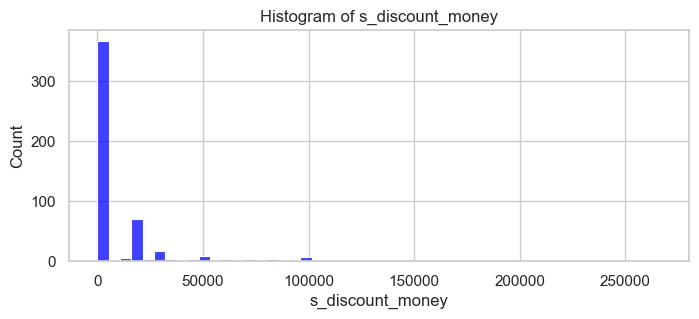

In [1426]:
def hist_s_dc(data_bills):
    # Create a histogram for s_grand_total using Seaborn
    plt.figure(figsize=(8, 3))
    sns.histplot(data_bills['s_discount_money'].dropna(), bins=50, kde=False, color='blue')  # includes dropna() to handle NaNs
    plt.title('Histogram of s_discount_money')
    plt.xlabel('s_discount_money')
    plt.ylabel('Count')
    plt.show()

for i in range(nclusters):
    hist_s_dc(data_all[i])

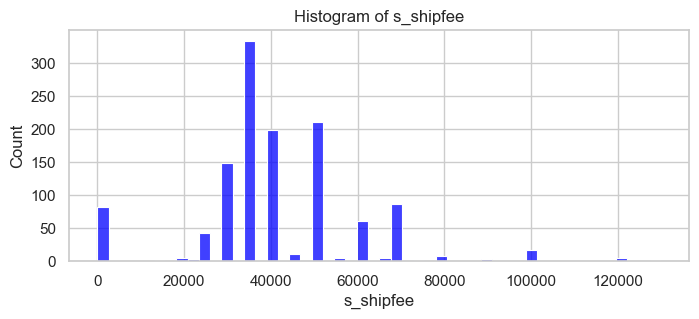

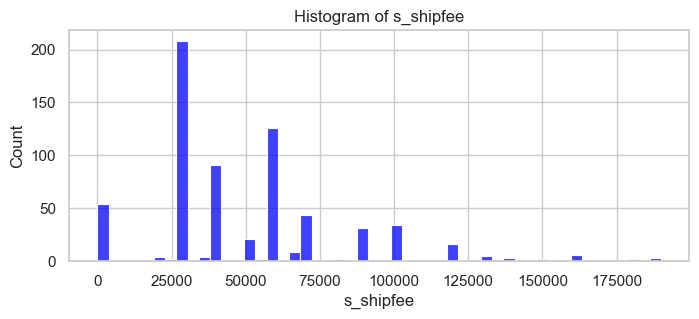

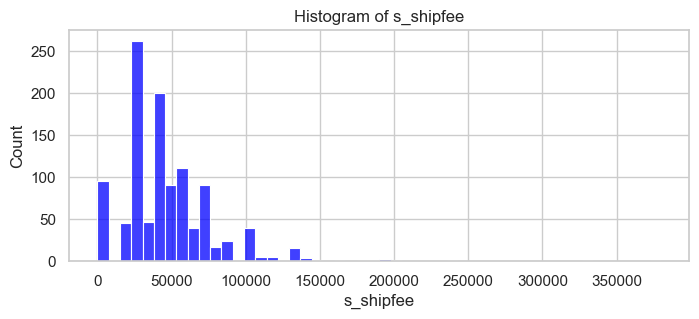

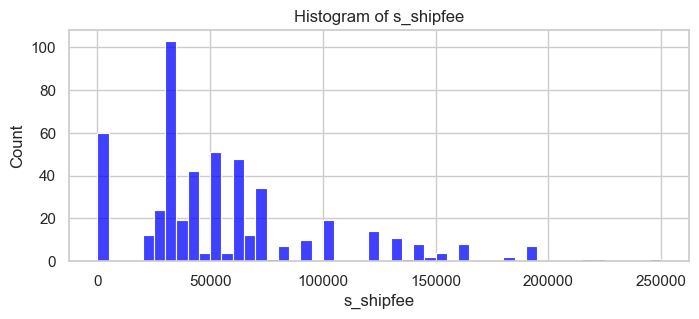

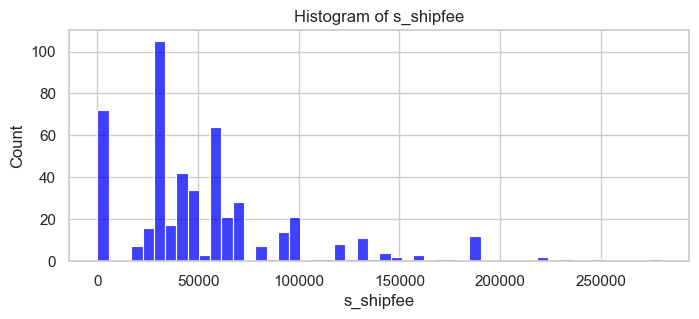

In [1430]:
def hist_s_shipee(data_bills):
    # Create a histogram for s_grand_total using Seaborn
    plt.figure(figsize=(8, 3))
    sns.histplot(data_bills['s_shipfee'].dropna(), bins=50, kde=False, color='blue')  # includes dropna() to handle NaNs
    plt.title('Histogram of s_shipfee')
    plt.xlabel('s_shipfee')
    plt.ylabel('Count')
    plt.show()

for i in range(nclusters):
    hist_s_shipee(data_all[i])

In [1428]:
def product_vs_rev(data_bills):
    merged_data = pd.merge(data_bills, data_products, on='product_id')
    
    merged_data = merged_data.dropna(subset=['s_grand_total'])
    
    product_totals = merged_data.groupby('product_name')['s_grand_total'].sum().reset_index()
    
    plt.figure(figsize=(12,6))
    plt.bar(product_totals['product_name'], product_totals['s_grand_total'])
    
    plt.title('Phân bố Sản phẩm vs. Số Tiền Tổng')
    plt.xlabel('Tên Sản phẩm')
    plt.ylabel('Số Tiền Tổng')
    plt.xticks(rotation=90) 
    plt.show()

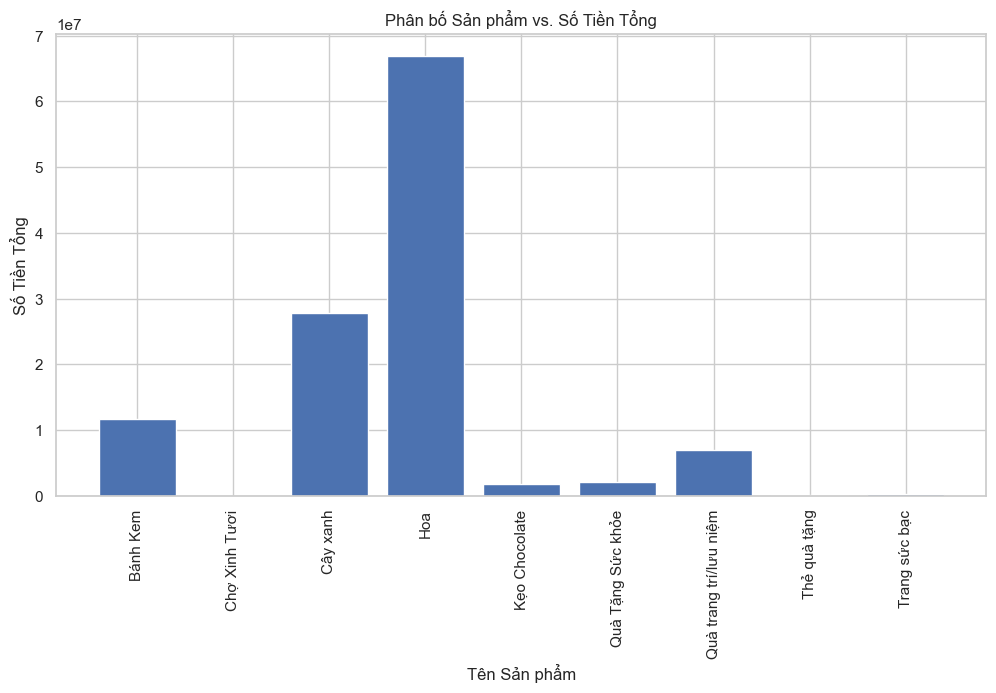

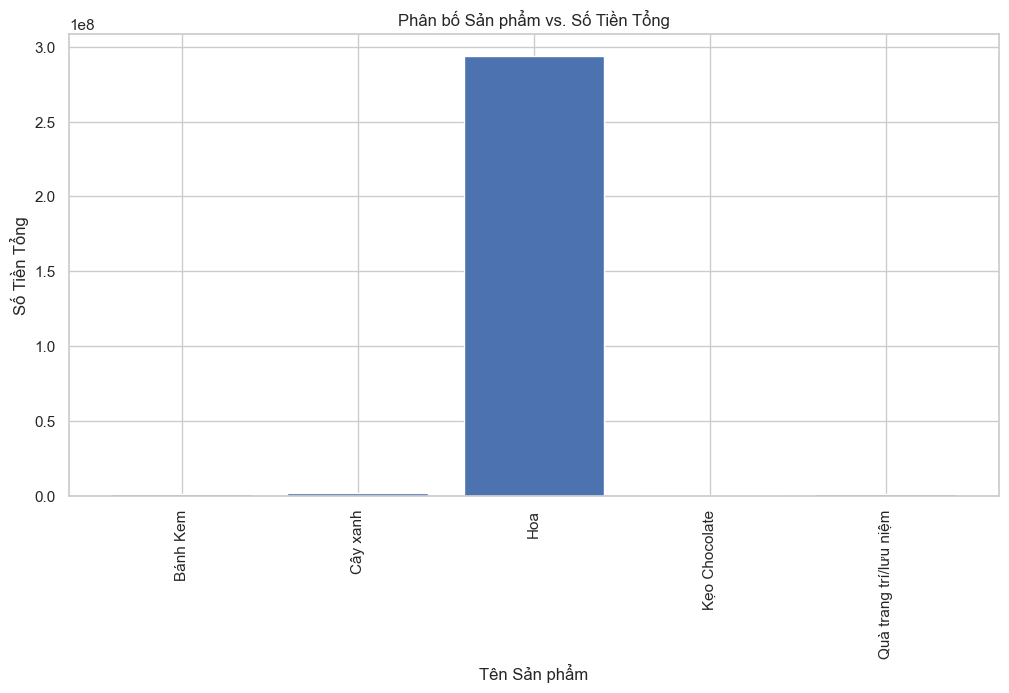

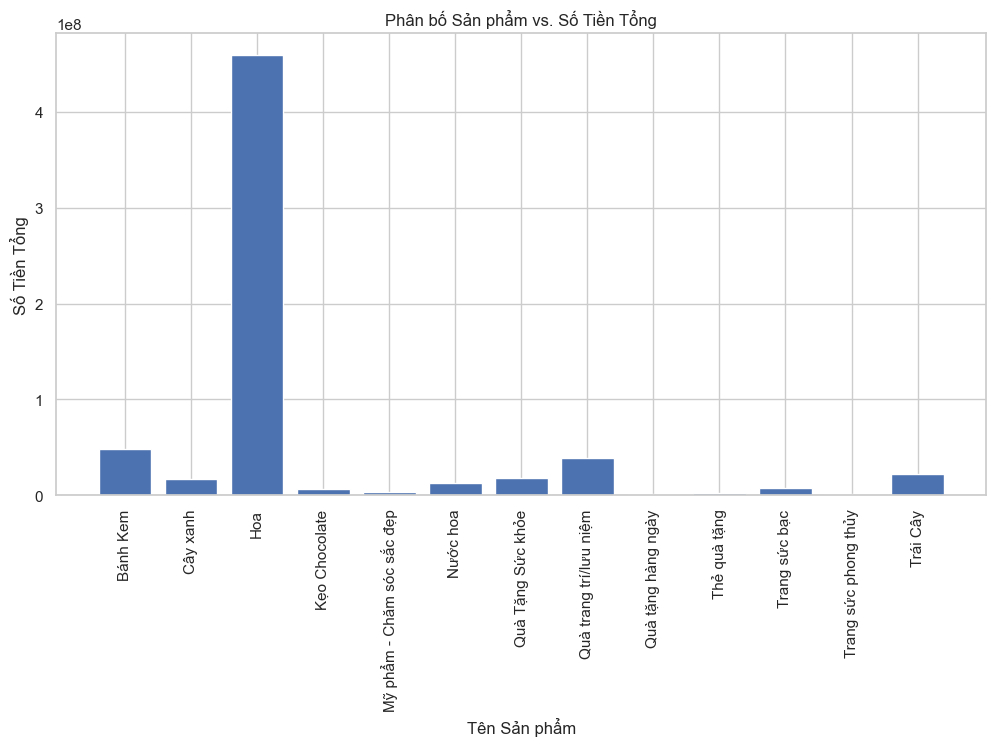

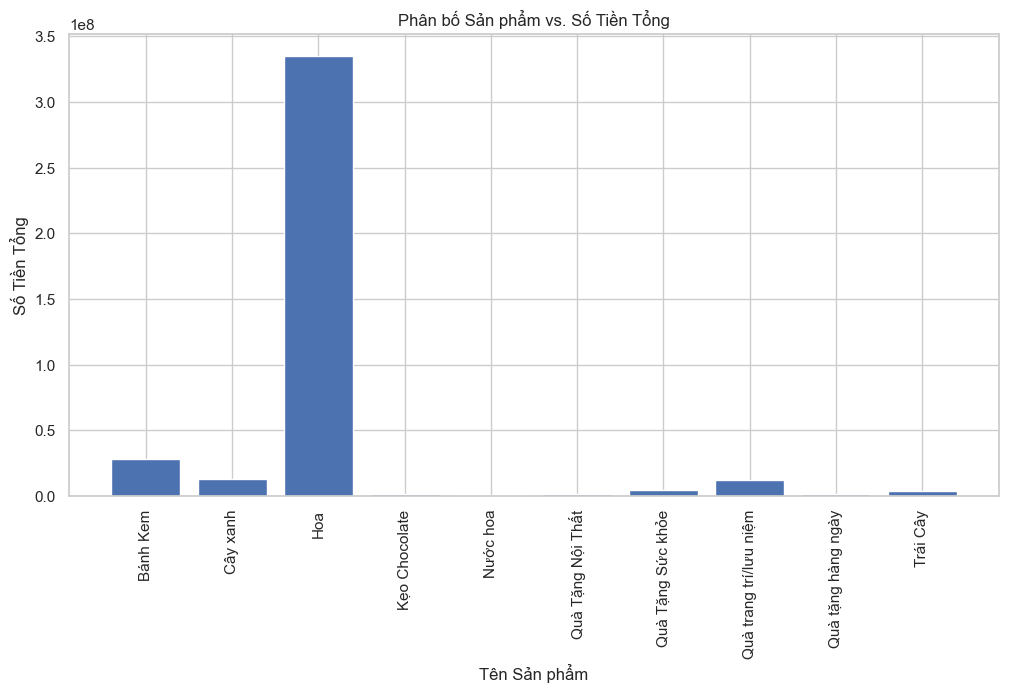

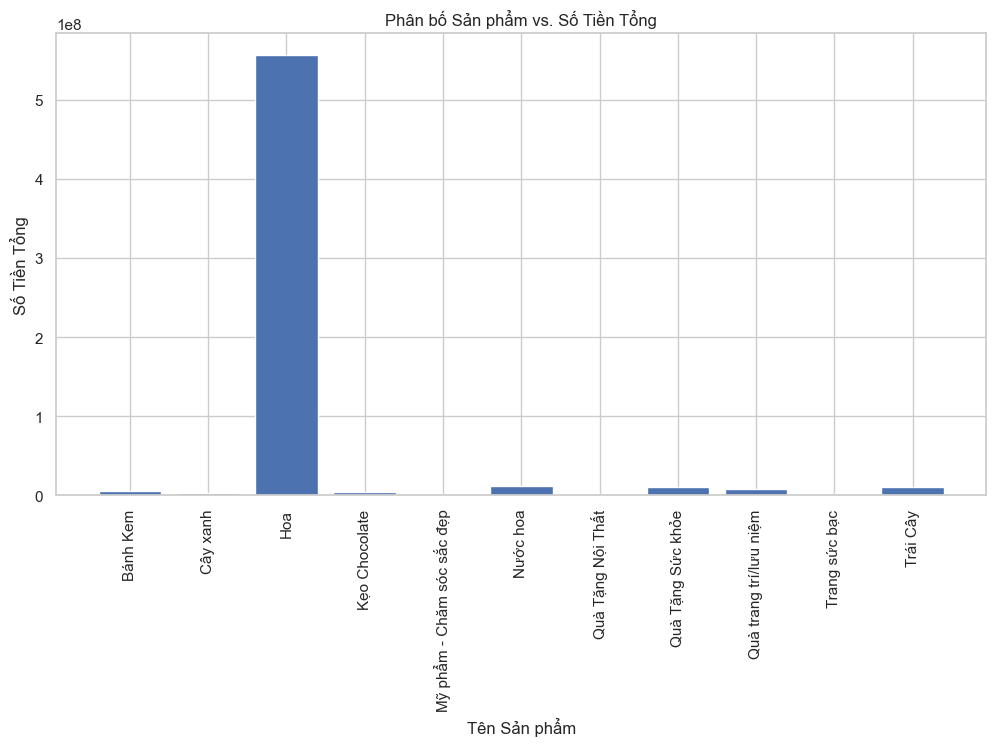

In [1429]:
for i in range(nclusters):
    product_vs_rev(data_all[i])

## IV/ <a id='final-result'></a>Final result

<img src="final_result_1.png"/> 

<img src="final_result_2.png"/> 